# Preprocessing

In [1]:
import cv2
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import time
import motors
import cv2
import pyzed.sl as sl
import math
import numpy as np
import sys
import threading
import matplotlib.pyplot as plt

In [2]:
def extract_yellow(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    lower_bound = np.array([30,40,120])
    upper_bound = np.array([75, 255, 255])

    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    return cv2.bitwise_and(frame, frame, mask=mask), mask

In [3]:
def centre_rope(frame, mask):
    contours,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)

        x,y,w,h = cv2.boundingRect(largest_contour)
        
        rope_centre_x = x + w // 2
        #return cropped_image, (centre_x, centre_y)
        return rope_centre_x, mask
    return None, mask

# Camera

In [4]:
#create widgets for the displaying of the image
display_color = widgets.Image(format='jpeg', width='30%') #determine the width of the color image
display_depth = widgets.Image(format='jpeg', width='30%')  #determine the width of the depth image
layout=widgets.Layout(width='100%')
sidebyside = widgets.HBox([display_color, display_depth],layout=layout) #horizontal 
display(sidebyside)

class Camera():
    def __init__(self):
        super(Camera, self).__init__()

        self.zed = sl.Camera()
        # Create a InitParameters object and set configuration parameters
        init_params = sl.InitParameters()
        init_params.camera_resolution = sl.RESOLUTION.VGA #VGA(672*376), HD720(1280*720), HD1080 (1920*1080) or ...
        init_params.depth_mode = sl.DEPTH_MODE.ULTRA  # Use ULTRA depth mode
        init_params.coordinate_units = sl.UNIT.MILLIMETER  # Use meter units (for depth measurements)

        # Open the camera
        status = self.zed.open(init_params)
        if status != sl.ERROR_CODE.SUCCESS: #Ensure the camera has opened succesfully
            print("Camera Open : "+repr(status)+". Exit program.")
            self.zed.close()
            exit(1)

         # Create and set RuntimeParameters after opening the camera
        self.runtime = sl.RuntimeParameters()

        #flag to control the thread
        self.thread_runnning_flag = False

        # Get the height and width
        camera_info = self.zed.get_camera_information()
        self.width = camera_info.camera_configuration.resolution.width
        self.height = camera_info.camera_configuration.resolution.height
        self.image = sl.Mat(self.width,self.height,sl.MAT_TYPE.U8_C4, sl.MEM.CPU)
        self.depth = sl.Mat(self.width,self.height,sl.MAT_TYPE.F32_C1, sl.MEM.CPU)
        self.point_cloud = sl.Mat(self.width,self.height,sl.MAT_TYPE.F32_C4, sl.MEM.CPU)
        self.output = None
        self.color_value = None

        self.count = 0

    def _capture_frames(self):
        while(self.thread_runnning_flag==True): #continue until the thread_runnning_flag is set to be False
           
            if self.zed.grab(self.runtime) == sl.ERROR_CODE.SUCCESS:
                
                
                # Retrieve Left image
                self.zed.retrieve_image(self.image, sl.VIEW.LEFT)
                # Retrieve depth map. Depth is aligned on the left image
                self.zed.retrieve_measure(self.depth, sl.MEASURE.DEPTH)
                # Retrieve colored point cloud. Point cloud is aligned on the left image.
                self.zed.retrieve_measure(self.point_cloud, sl.MEASURE.XYZRGBA)

                self.color_value = self.image.get_data()
                cv2.putText(self.color_value, 'o', (self.width//2,self.height//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                display_color.value = bgr8_to_jpeg(self.color_value)

                
                #self.output.write(self.color_value)
                self.depth_image = np.asanyarray(self.depth.get_data())
                depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(self.depth_image, alpha=0.03), cv2.COLORMAP_JET) 
                cv2.putText(depth_colormap, str(self.depth_image[self.height//2,self.width//2]), (self.width//2,self.height//2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                display_depth.value = bgr8_to_jpeg(depth_colormap)
                
                # # We measure the distance camera - object using Euclidean distance
                x = round(self.width / 2)
                y = round(self.height / 2)
                err, point_cloud_value = self.point_cloud.get_value(x, y)  
                # Your mission here 
    
    def start(self): #start the data capture thread
        if self.thread_runnning_flag == False: #only process if no thread is running yet
            self.thread_runnning_flag=True #flag to control the operation of the _capture_frames function
            self.thread = threading.Thread(target=self._capture_frames) #link thread with the function
            self.thread.start() #start the thread       

    def stop(self): #stop the data capture thread
        if self.thread_runnning_flag == True:
            self.thread_runnning_flag = False #exit the while loop in the _capture_frames
            self.thread.join() #wait the exiting of the thread    
            self.output.release() 

    def get_image(self):
        image = self.color_value
        return image

def bgr8_to_jpeg(value):#convert numpy array to jpeg coded data for displaying 
    return bytes(cv2.imencode('.jpg',value)[1])

# Movement

In [5]:
def move_robot(rope_centre_x, frame_width, image, count, threshold=50):
    screen_centre_x = frame_width // 2
    
    if rope_centre_x is None:
        robot.stop()
        return
    if abs(rope_centre_x - screen_centre_x) < threshold:
        robot.forward(0.2)
        time.sleep(0.2)
        cv2.imwrite(f"forward_{str(count)}.png", image)
        return
    elif rope_centre_x < screen_centre_x:
        robot.left(0.1)
        time.sleep(0.1)
        cv2.imwrite(f"left_{str(count)}.png", image)
        return
    else: 
        robot.right(0.1)
        time.sleep(0.1)
        cv2.imwrite(f"right_{str(count)}.png", image)
        return

In [6]:

"""def move_robot(image, rope_centre_x, rope_centre_y, margin_width=200, margin_height=50):
    if rope_centre_x and rope_centre_y:
        frame_centre_x = image.shape[1] // 2
        frame_centre_y = image.shape[0] // 2

        movement_x = rope_centre_x - frame_centre_x
        movement_y = rope_centre_y - frame_centre_y

        if abs(movement_x) > margin_width // 2:
            if movement_x > 0:
                robot.left(0.1)
                time.sleep(0.1)
            else:
                robot.right(0.1)
                time.sleep(0.1)
        if abs(movement_y) > margin_height // 2:
            if movement_y > 0:
                robot.forward(0.1)
                time.sleep(0.1)
            else:
                robot.stop()

        return movement_x, movement_y

    else:
        robot.stop()
        """

'def move_robot(image, rope_centre_x, rope_centre_y, margin_width=200, margin_height=50):\n    if rope_centre_x and rope_centre_y:\n        frame_centre_x = image.shape[1] // 2\n        frame_centre_y = image.shape[0] // 2\n\n        movement_x = rope_centre_x - frame_centre_x\n        movement_y = rope_centre_y - frame_centre_y\n\n        if abs(movement_x) > margin_width // 2:\n            if movement_x > 0:\n                robot.left(0.1)\n                time.sleep(0.1)\n            else:\n                robot.right(0.1)\n                time.sleep(0.1)\n        if abs(movement_y) > margin_height // 2:\n            if movement_y > 0:\n                robot.forward(0.1)\n                time.sleep(0.1)\n            else:\n                robot.stop()\n\n        return movement_x, movement_y\n\n    else:\n        robot.stop()\n        '

# Putting it all together

In [7]:
robot = motors.MotorsYukon(mecanum=False)
camera = Camera()
camera.start()

[2025-03-26 09:55:38 UTC][ZED][INFO] Logging level INFO
[2025-03-26 09:55:38 UTC][ZED][INFO] Logging level INFO
[2025-03-26 09:55:38 UTC][ZED][INFO] Logging level INFO
[2025-03-26 09:55:39 UTC][ZED][INFO] [Init]  Depth mode: ULTRA
[2025-03-26 09:55:40 UTC][ZED][INFO] [Init]  Camera successfully opened.
[2025-03-26 09:55:40 UTC][ZED][INFO] [Init]  Camera FW version: 1523
[2025-03-26 09:55:40 UTC][ZED][INFO] [Init]  Video mode: VGA@100
[2025-03-26 09:55:40 UTC][ZED][INFO] [Init]  Serial Number: S/N 32675467


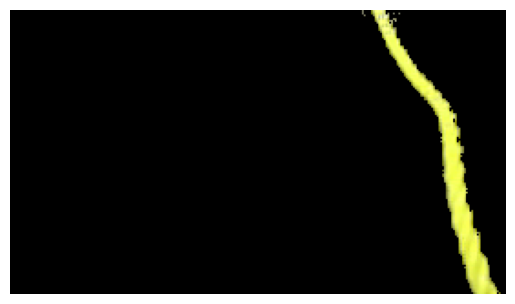

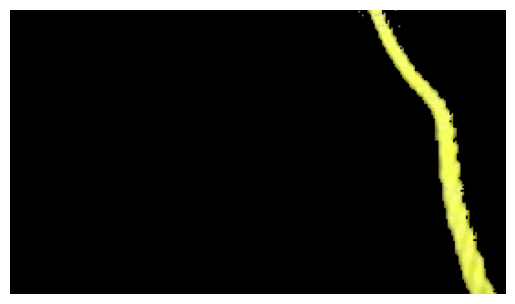

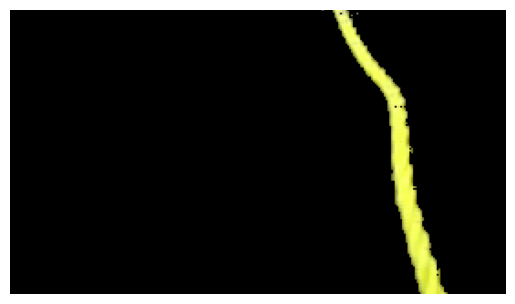

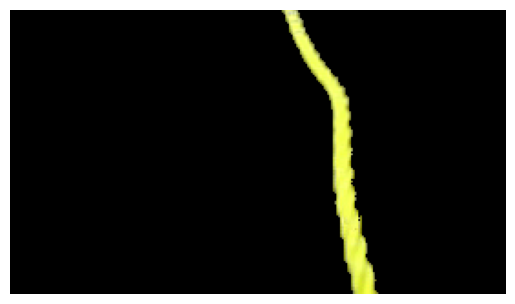

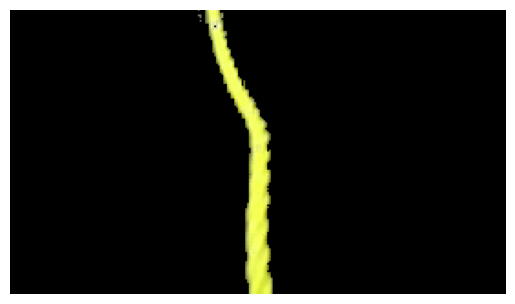

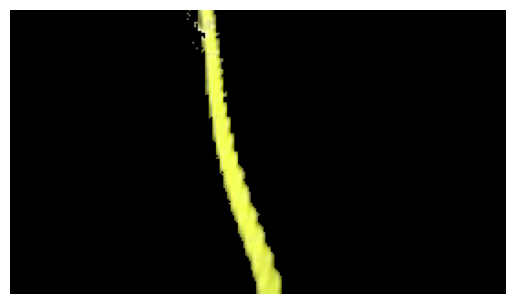

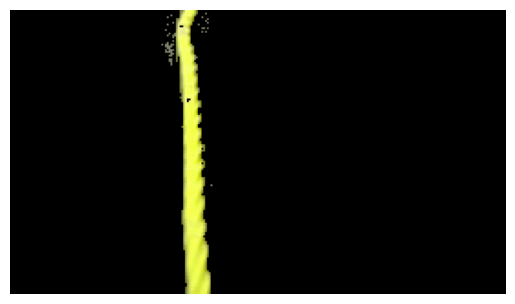

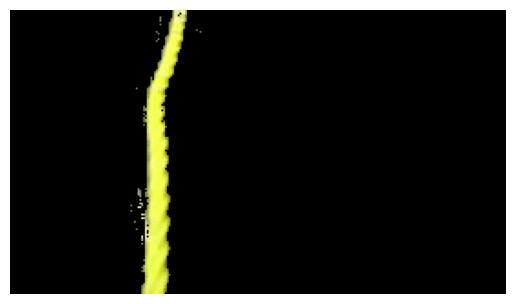

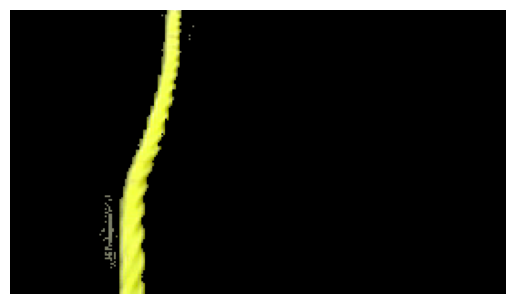

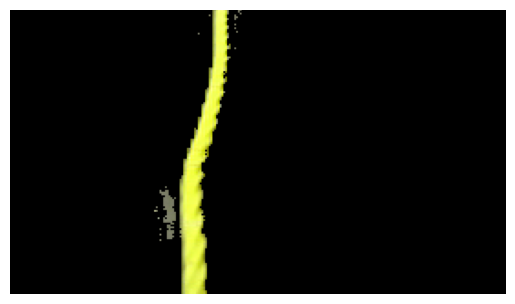

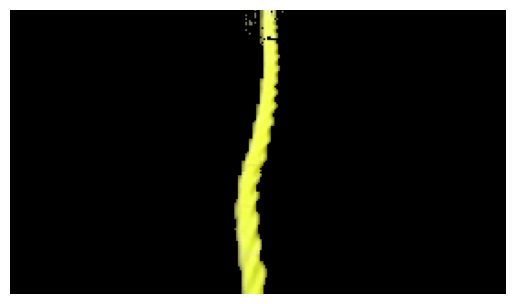

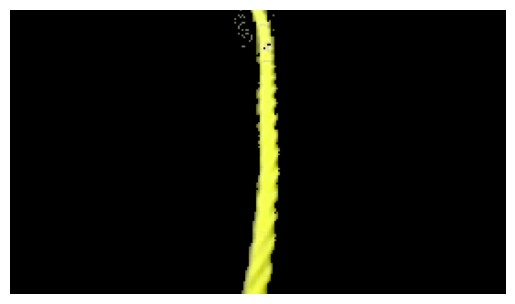

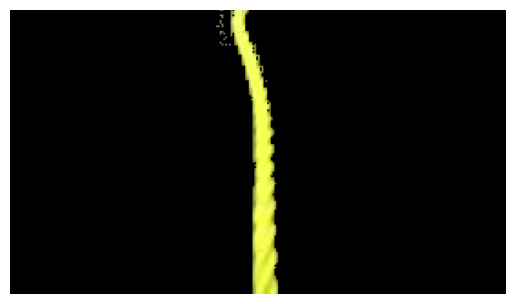

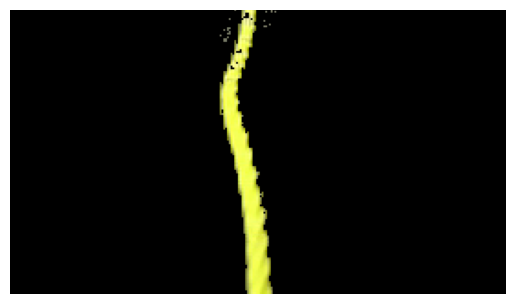

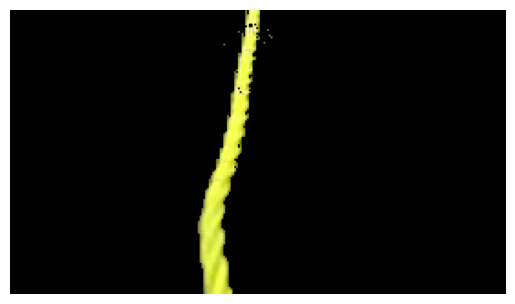

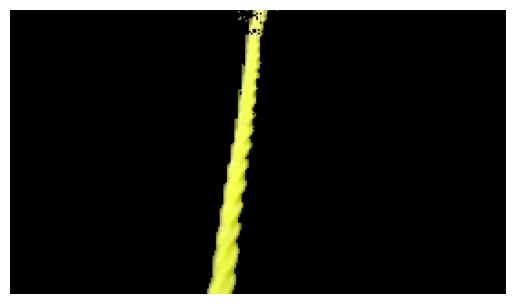

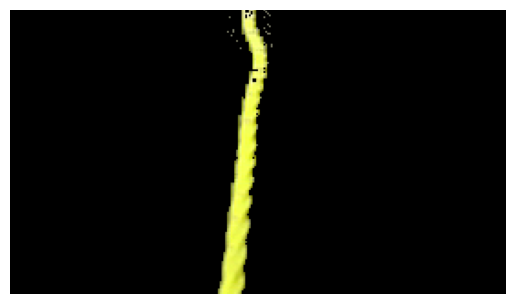

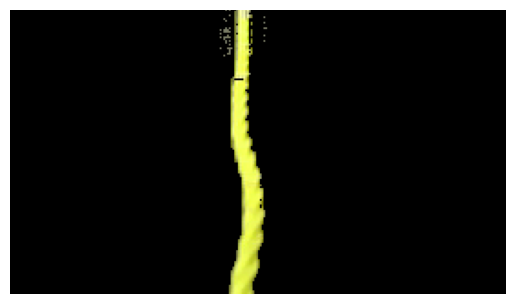

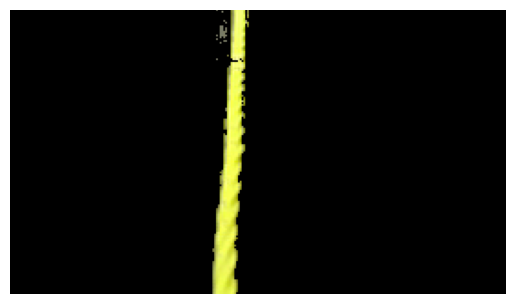

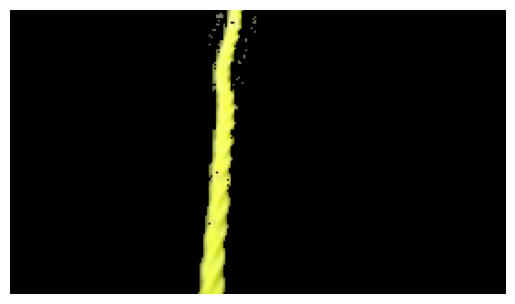

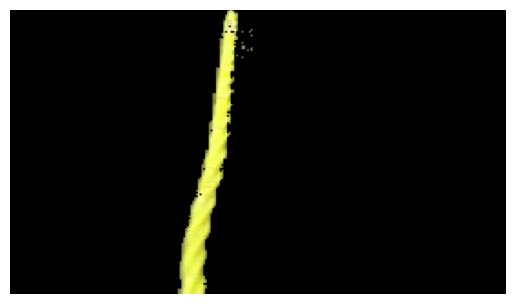

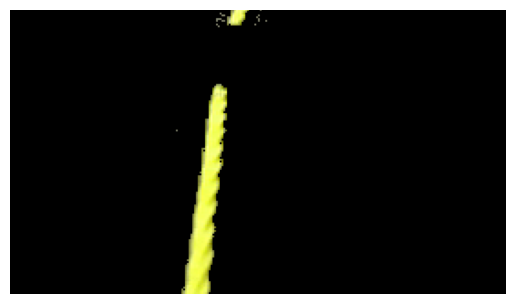

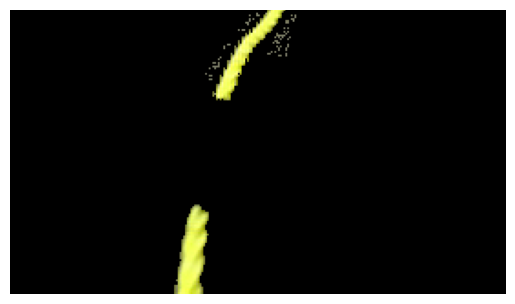

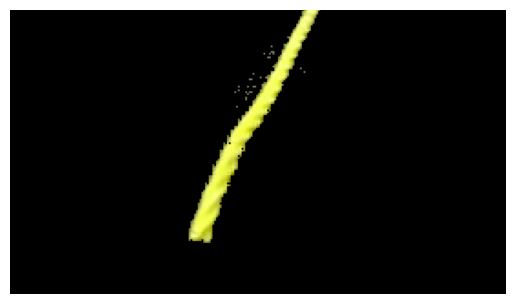

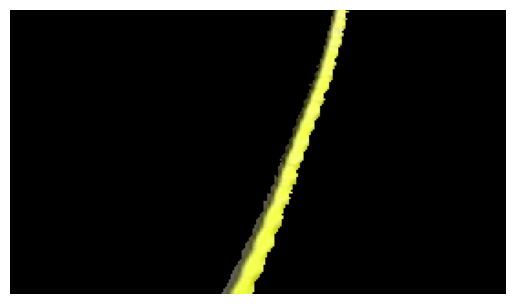

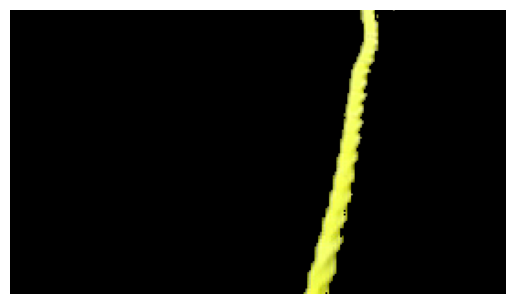

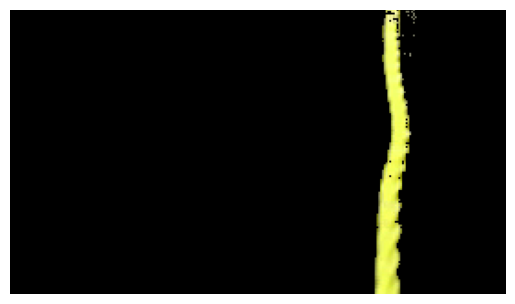

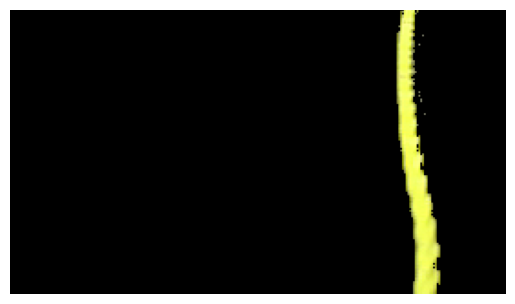

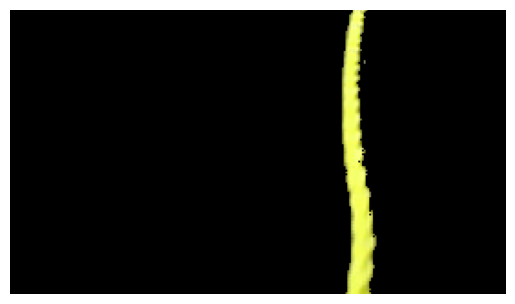

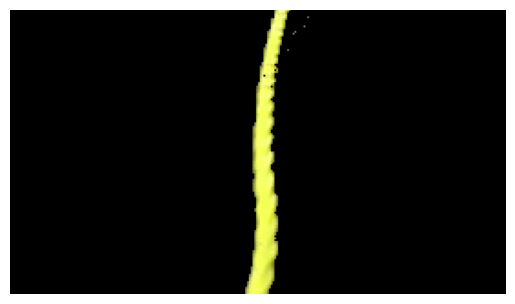

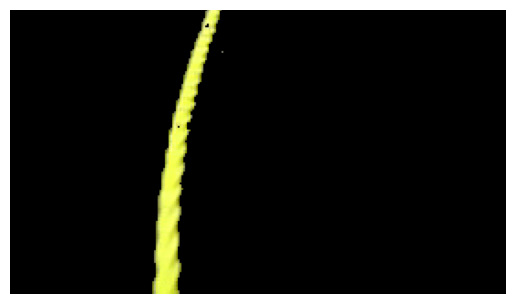

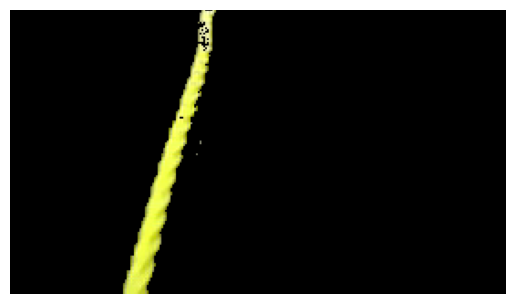

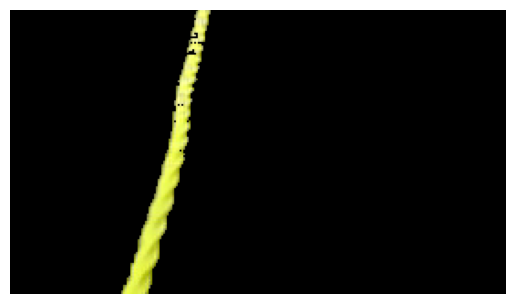

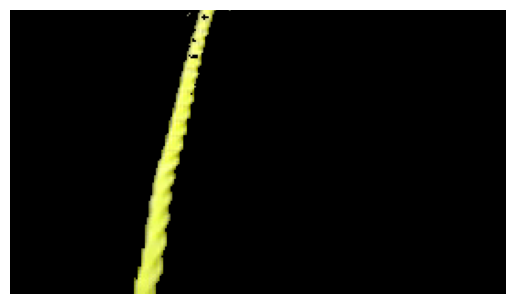

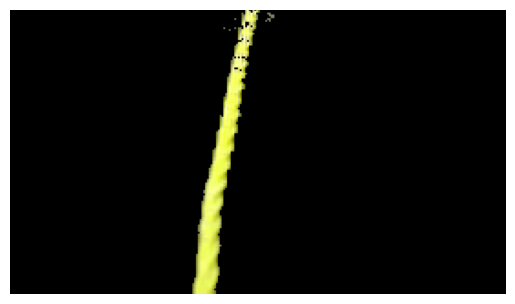

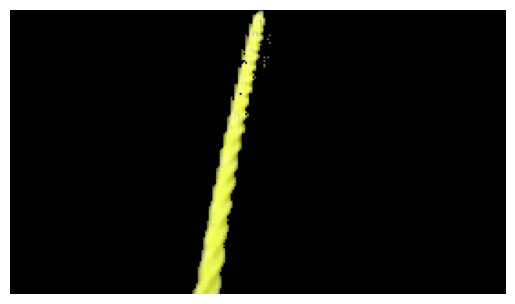

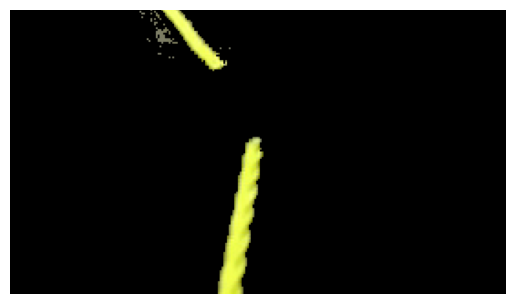

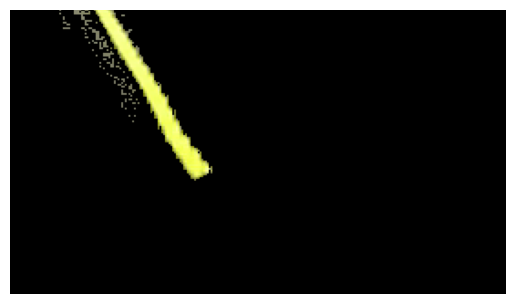

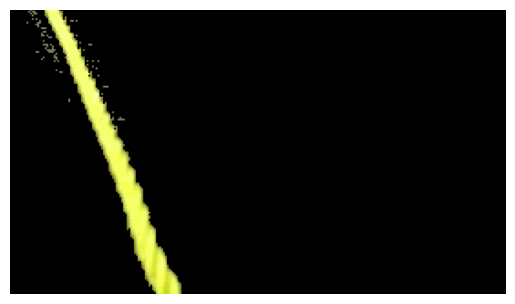

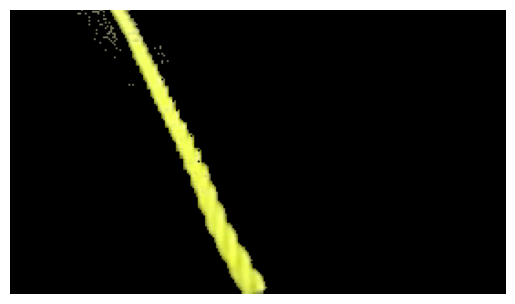

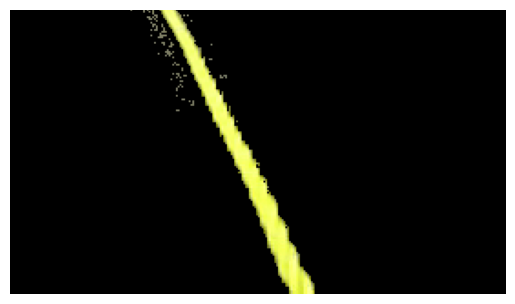

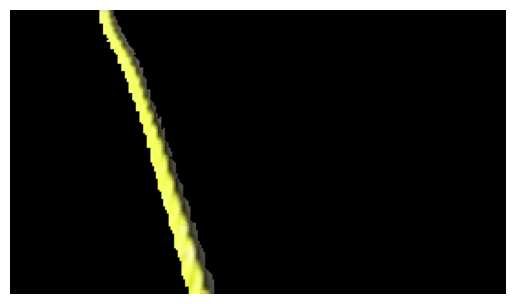

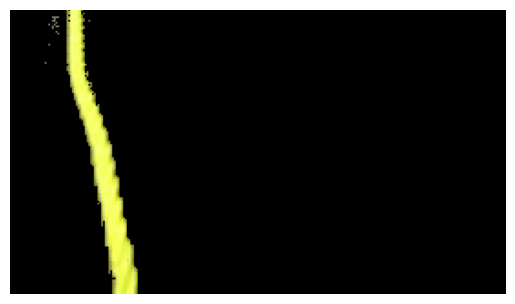

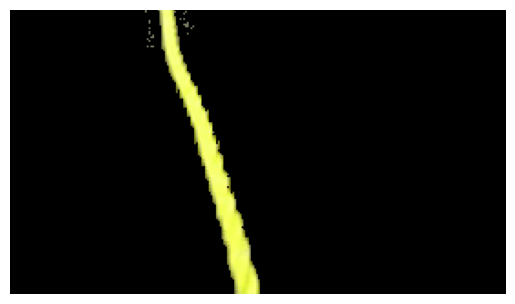

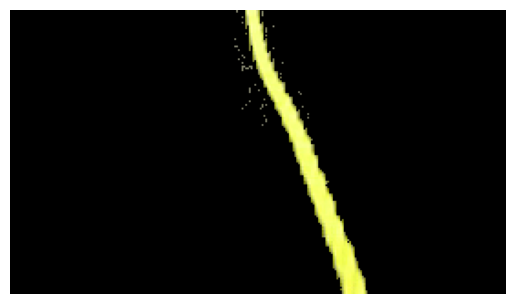

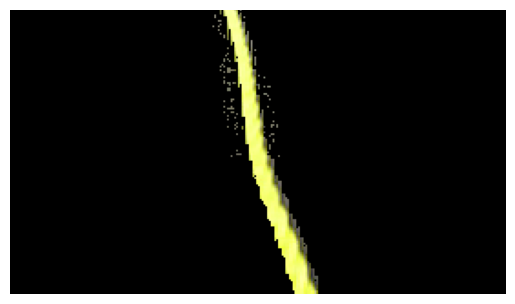

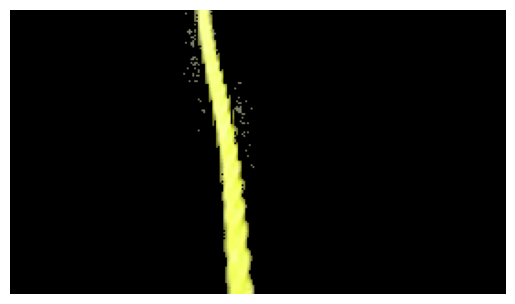

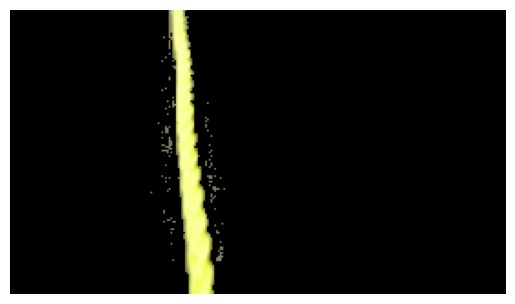

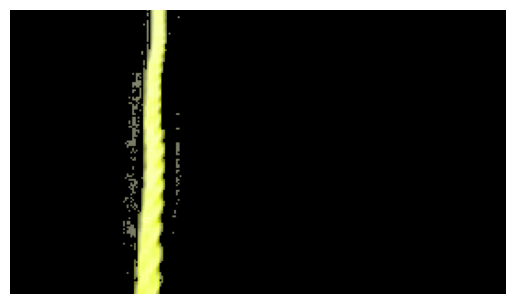

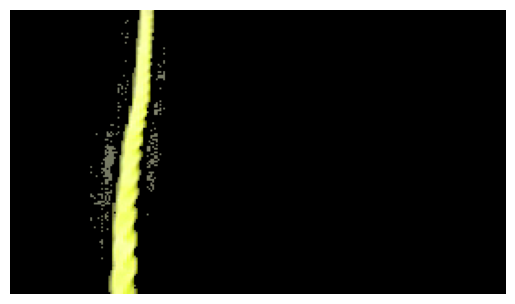

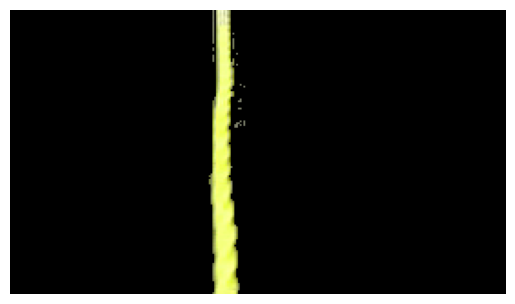

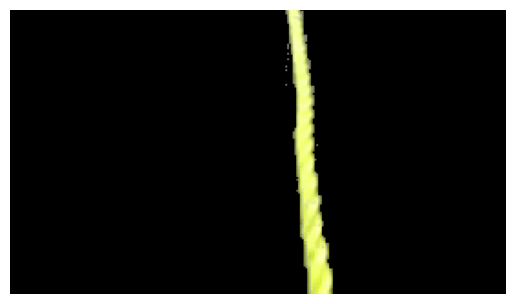

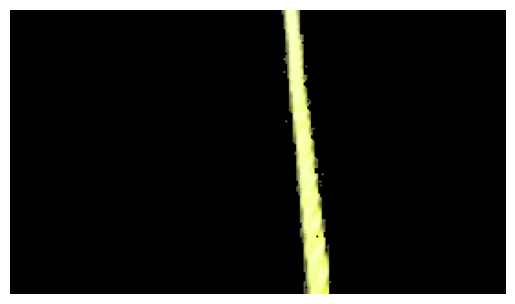

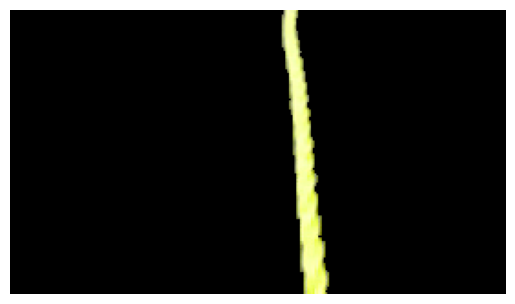

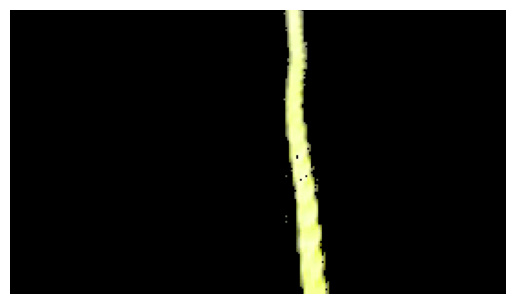

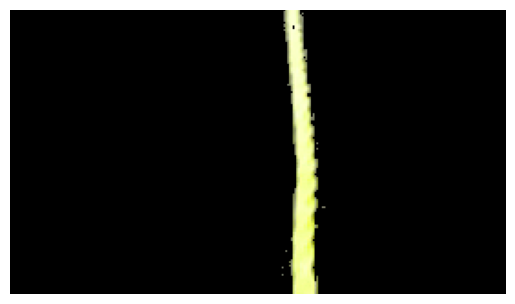

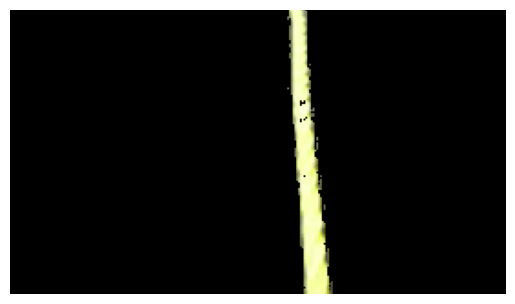

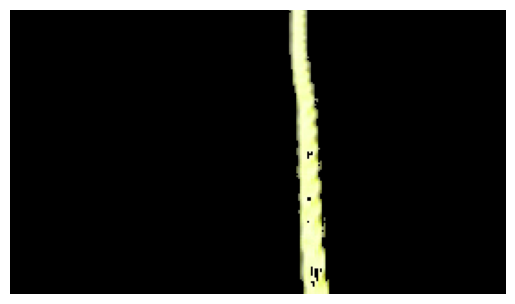

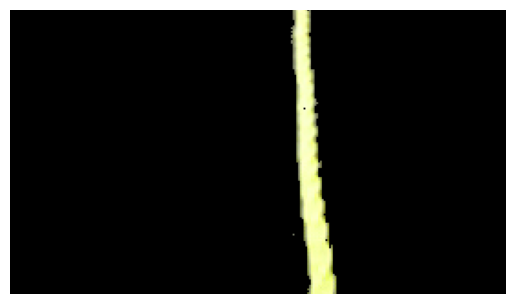

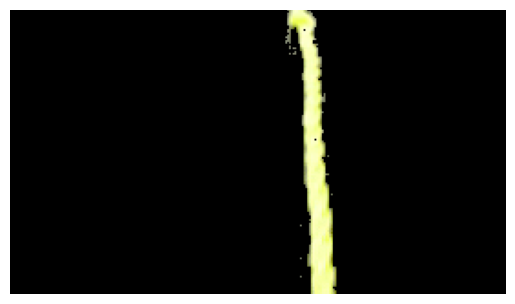

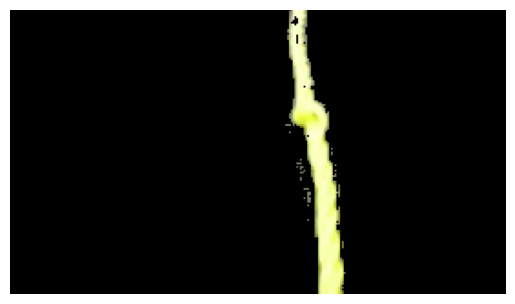

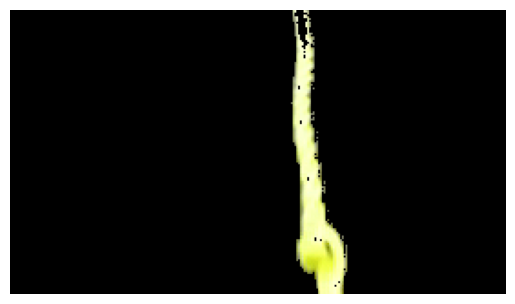

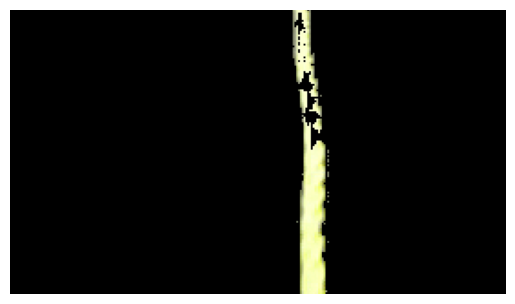

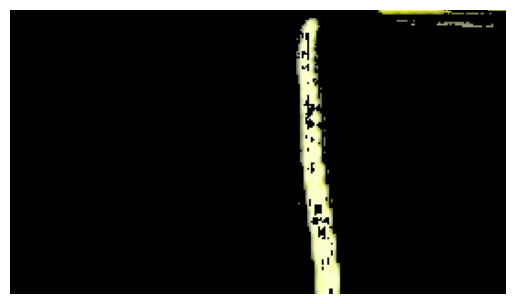

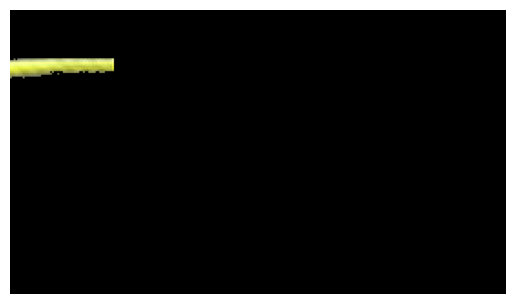

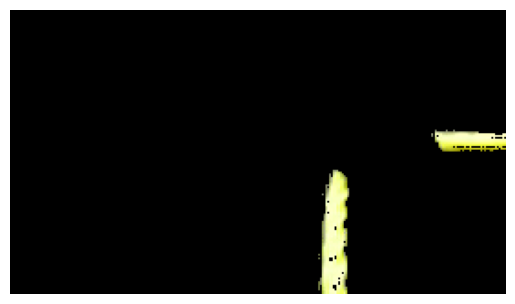

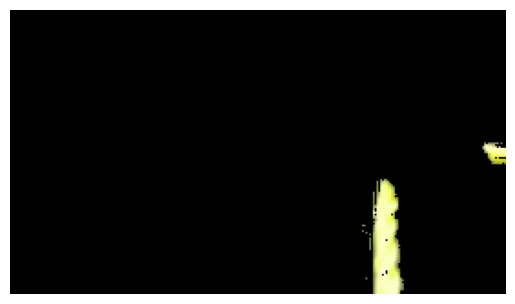

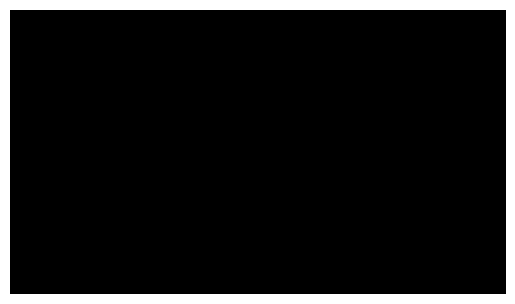

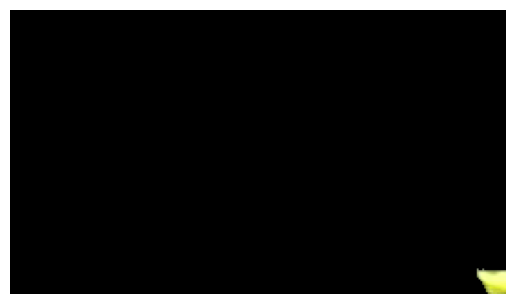

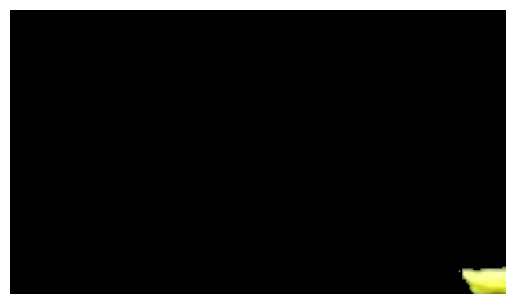

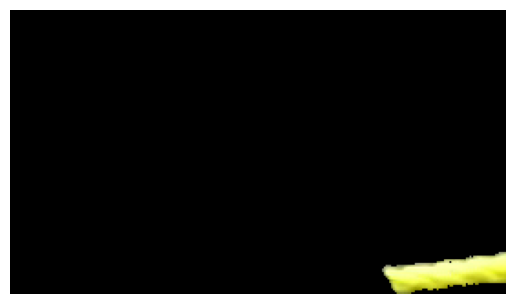

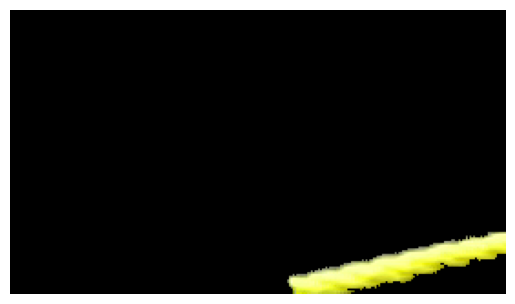

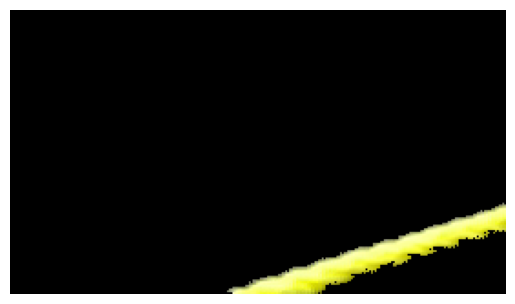

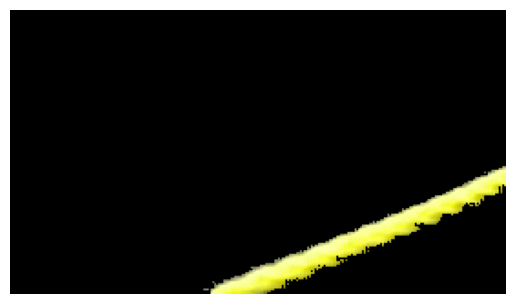

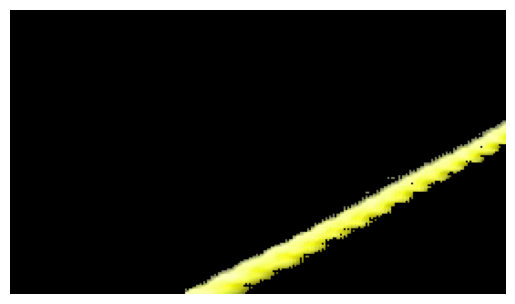

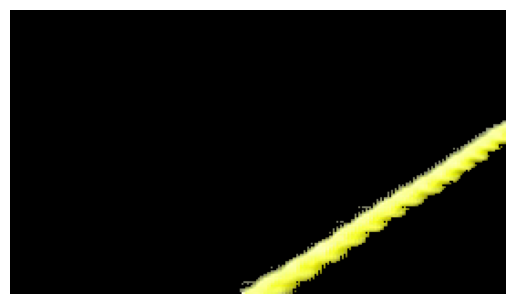

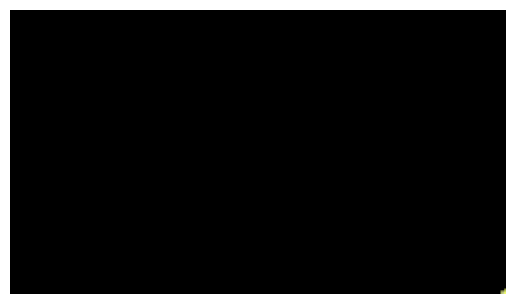

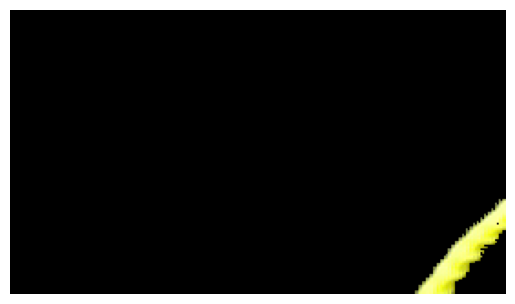

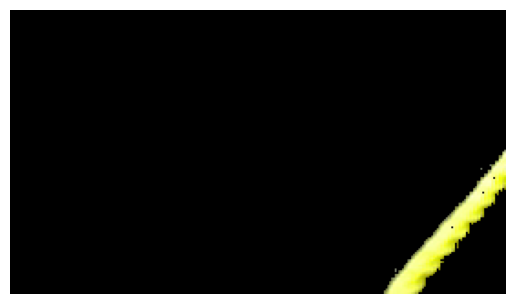

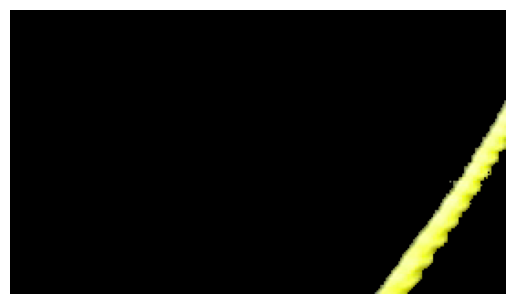

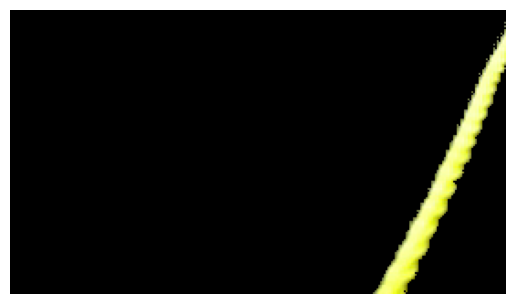

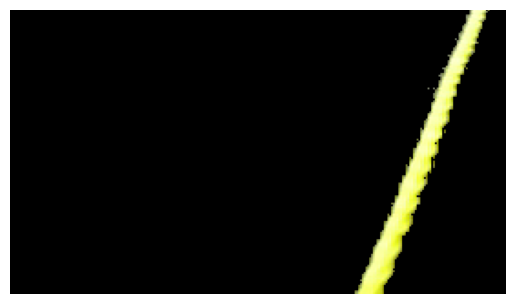

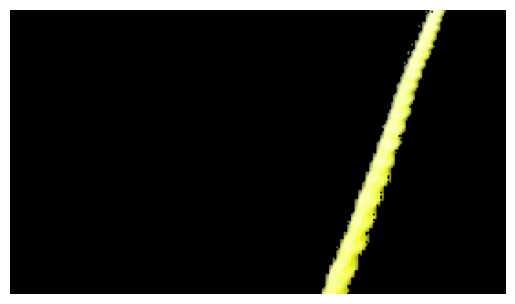

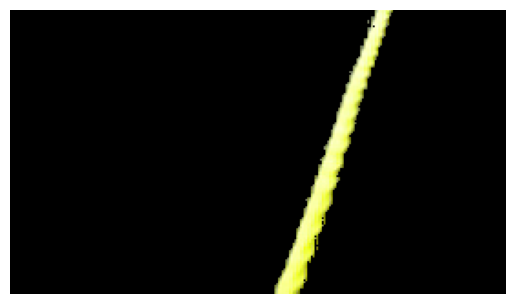

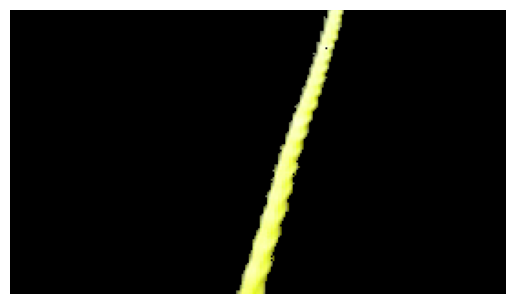

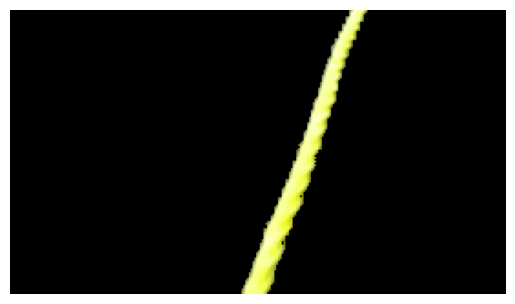

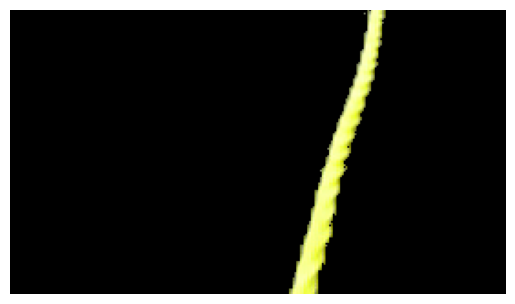

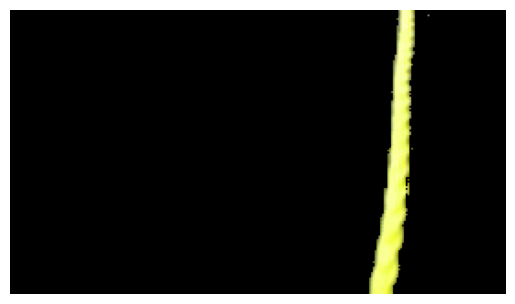

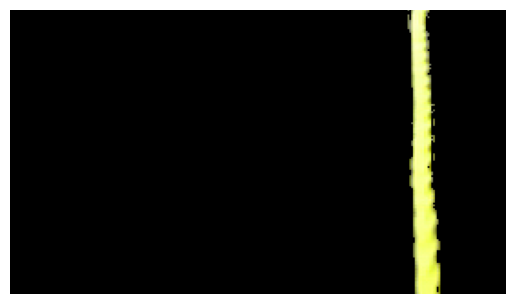

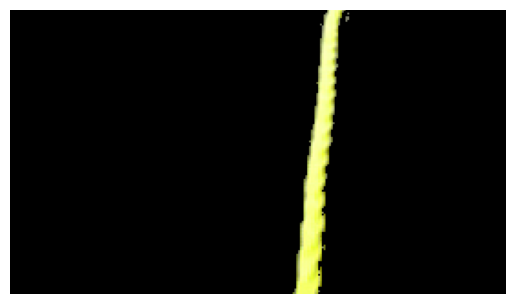

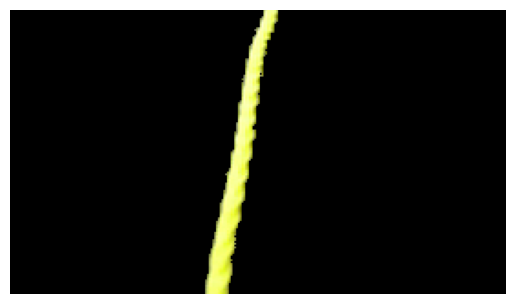

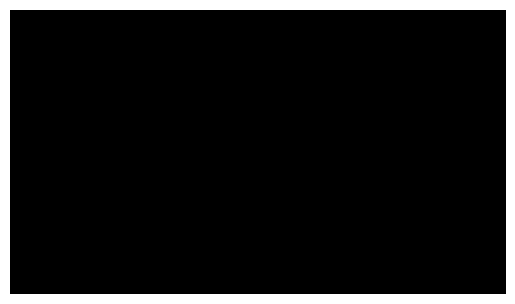

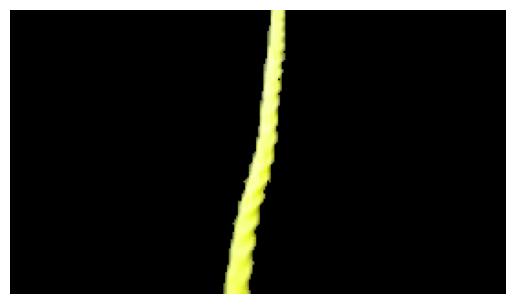

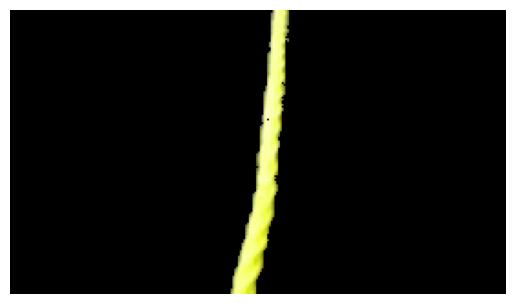

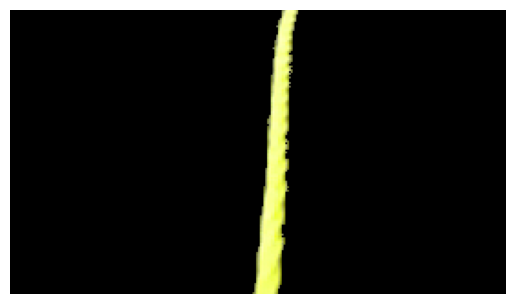

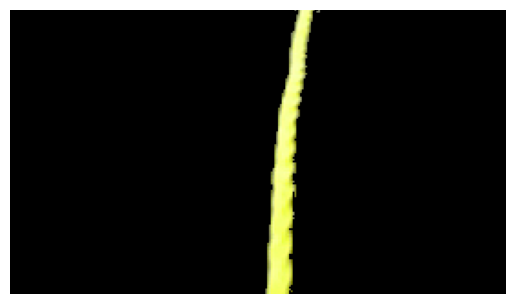

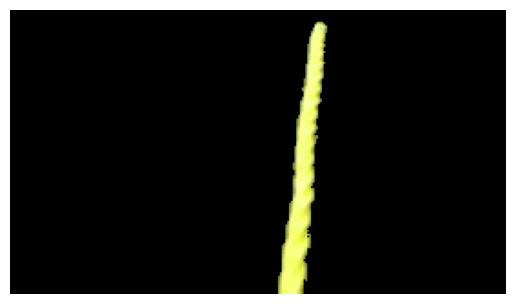

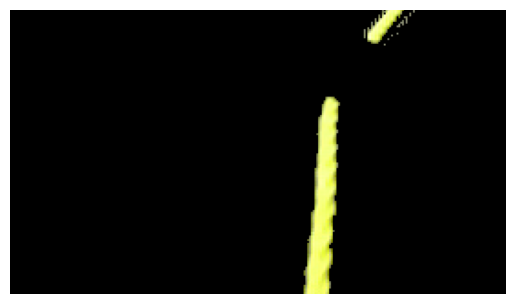

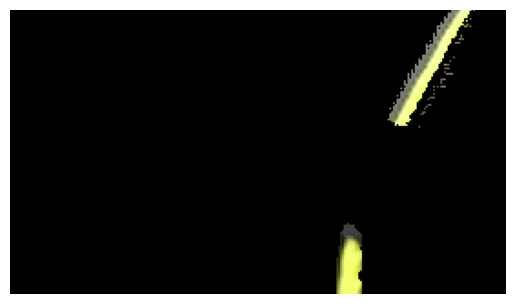

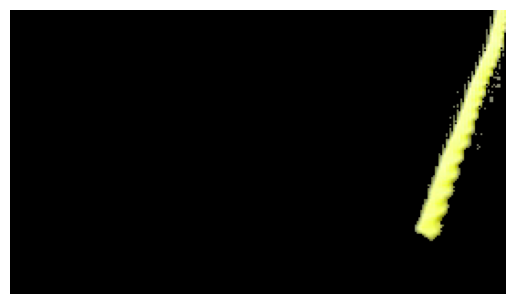

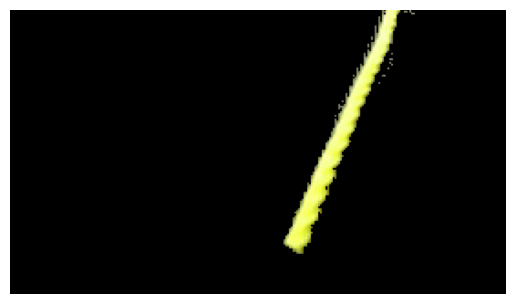

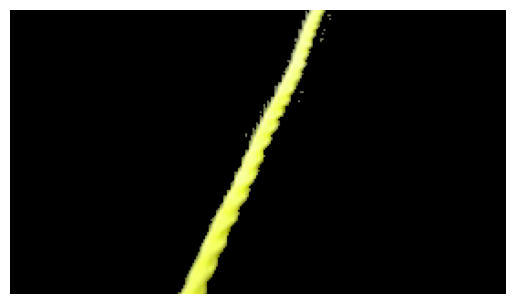

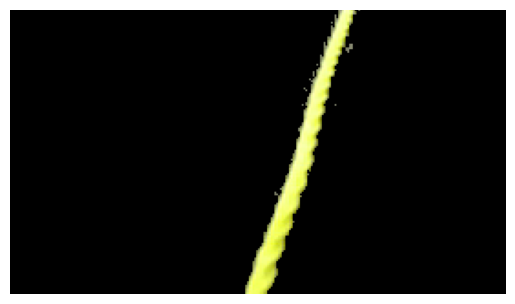

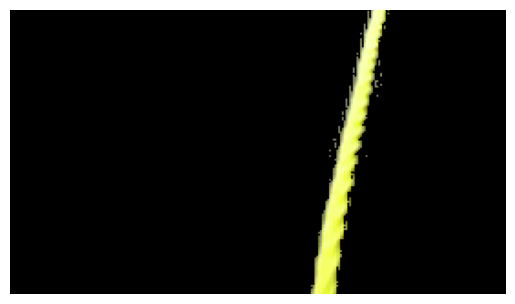

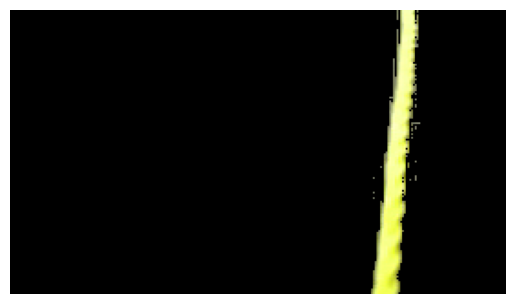

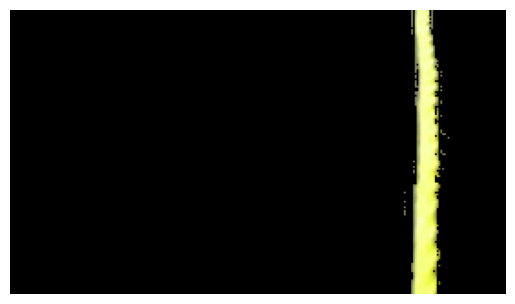

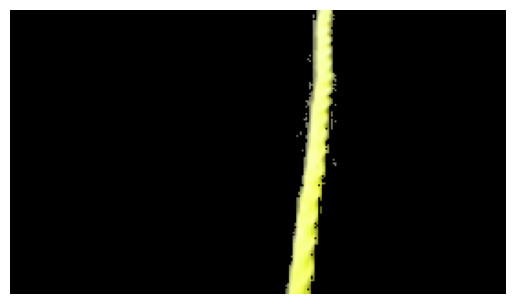

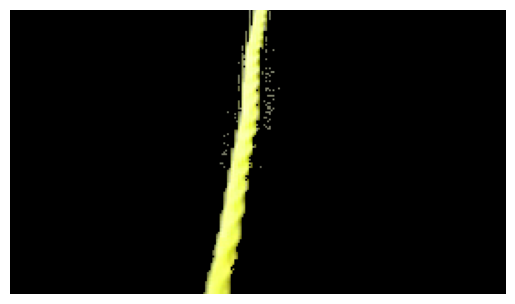

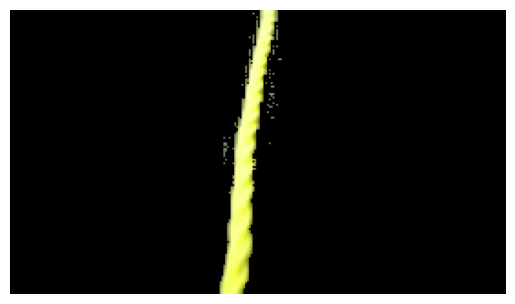

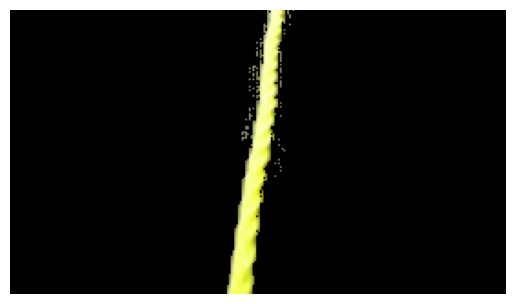

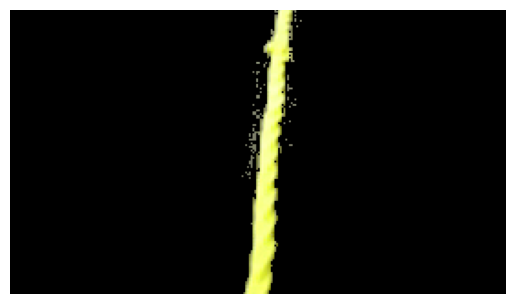

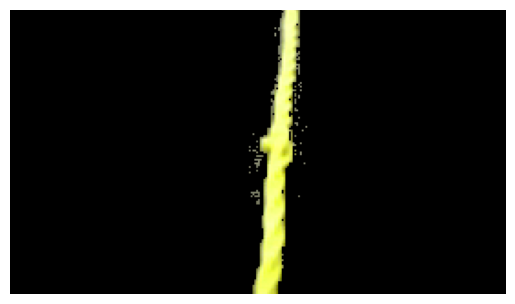

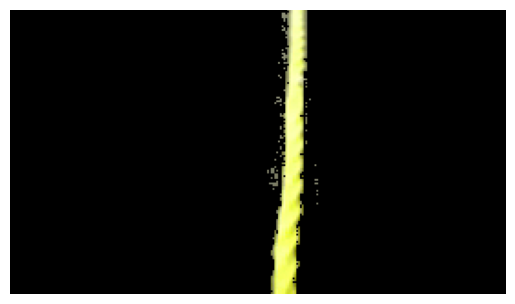

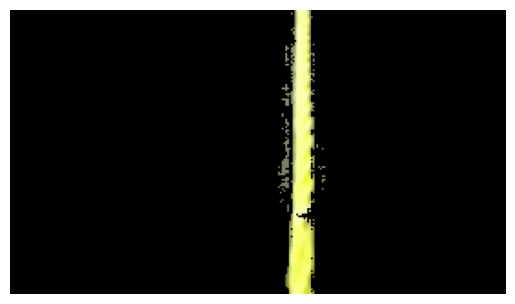

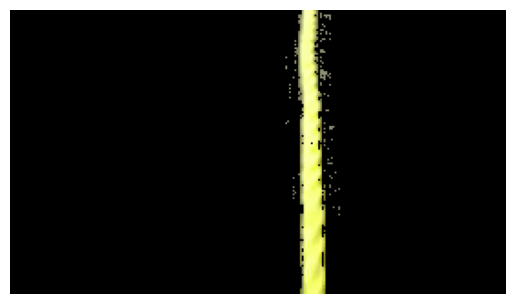

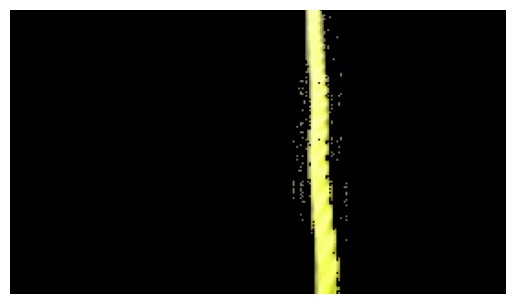

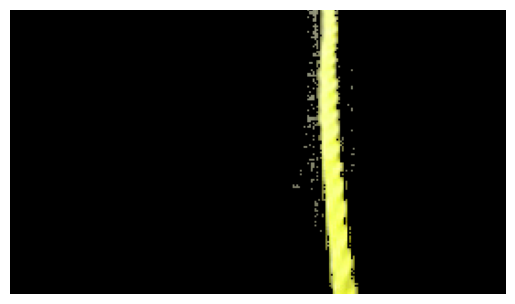

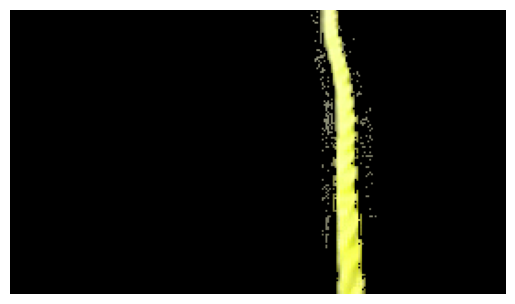

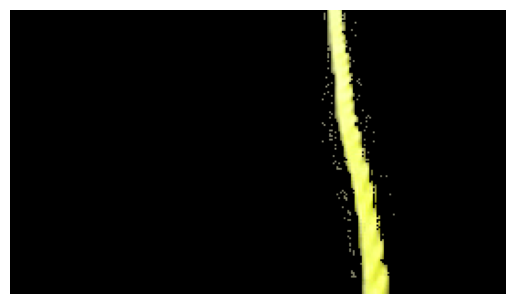

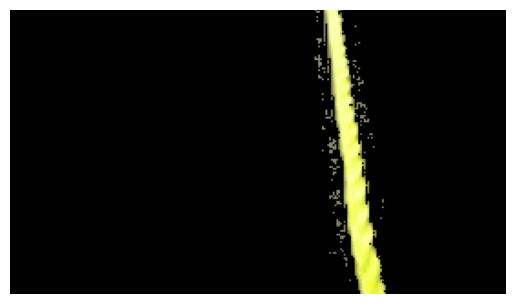

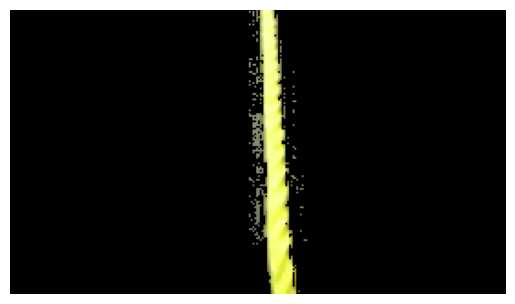

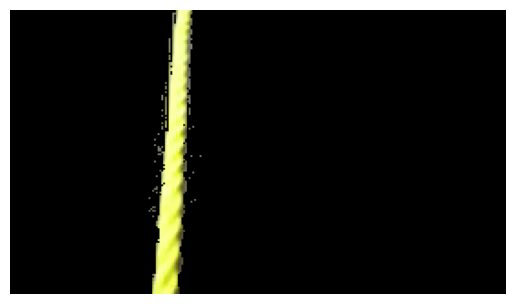

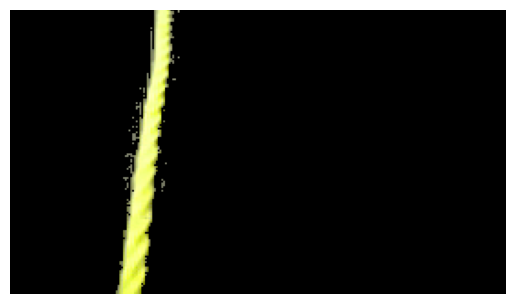

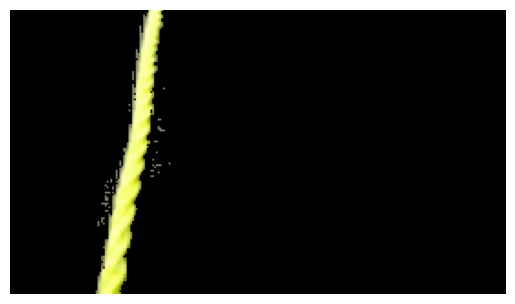

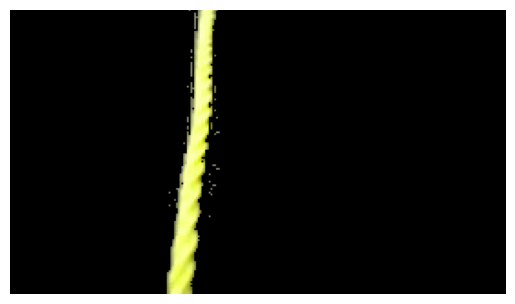

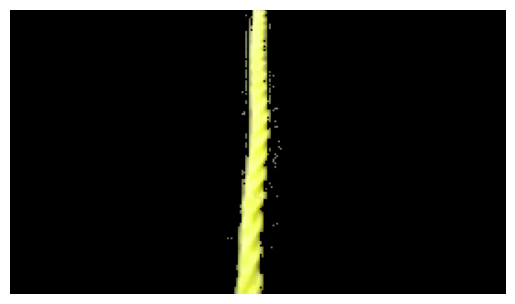

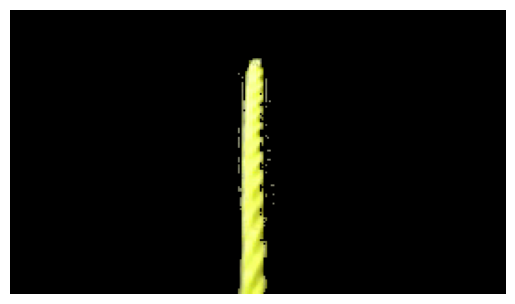

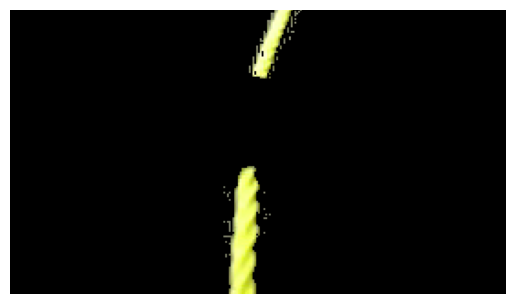

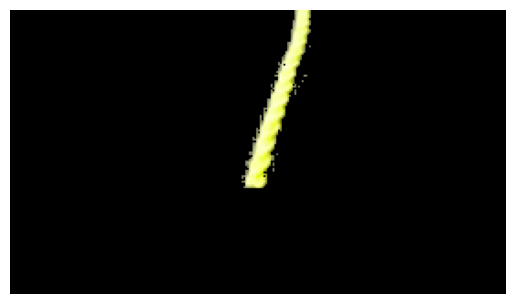

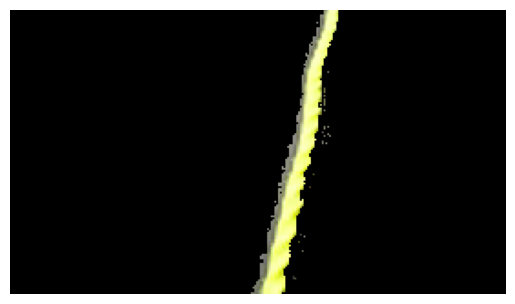

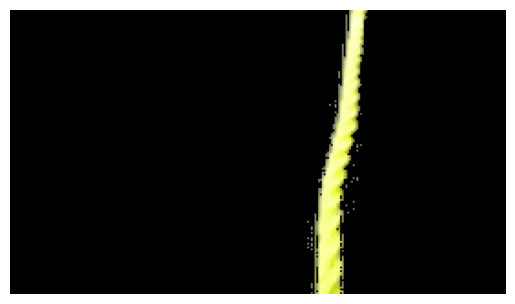

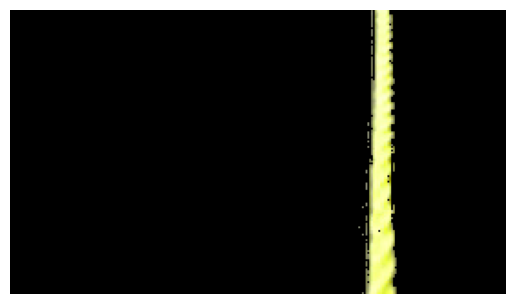

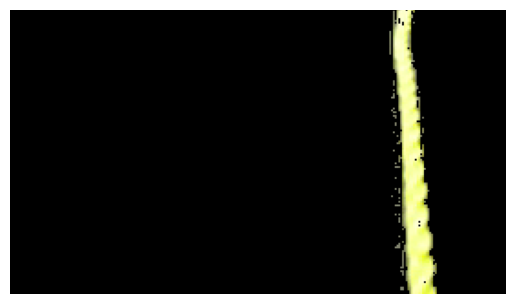

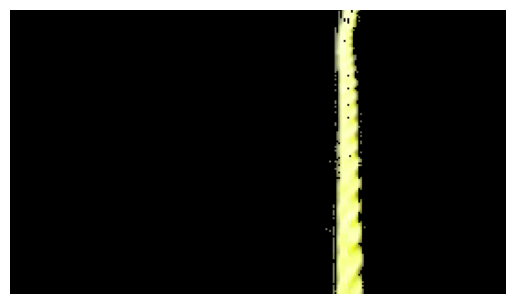

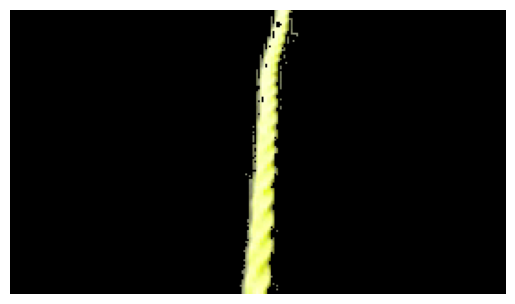

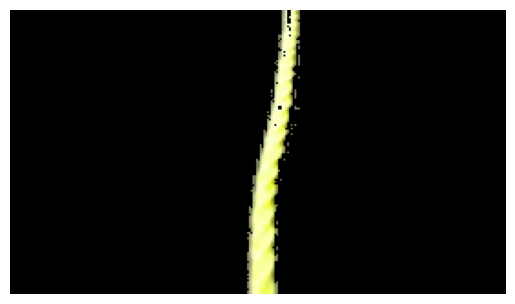

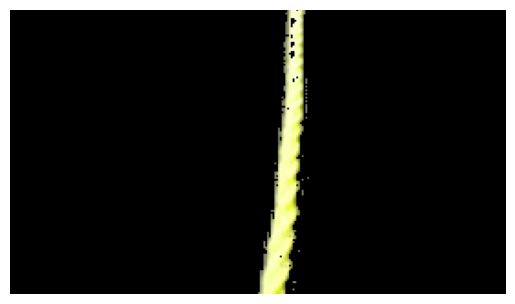

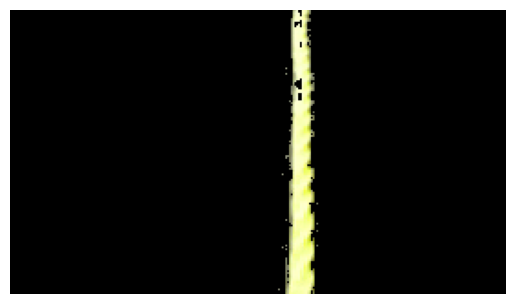

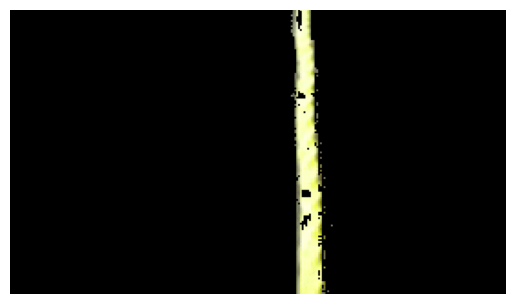

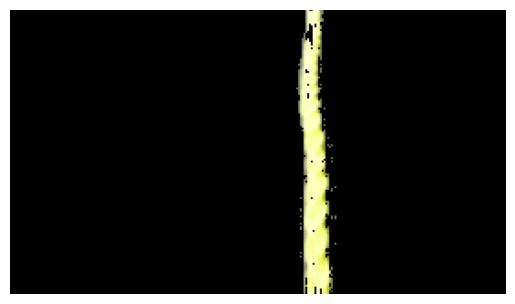

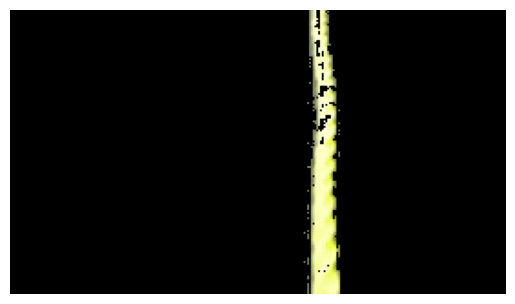

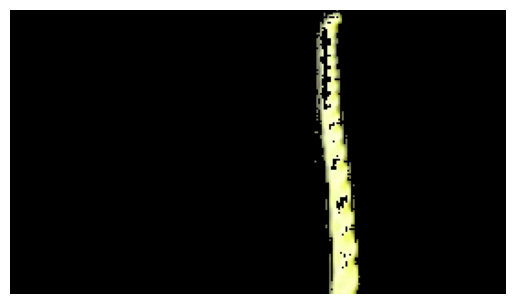

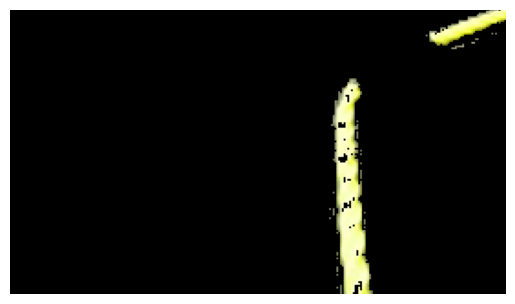

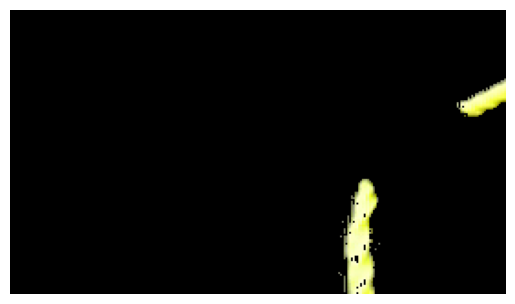

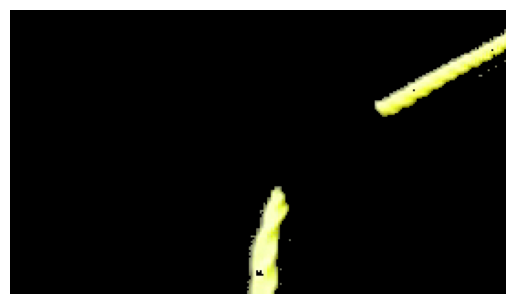

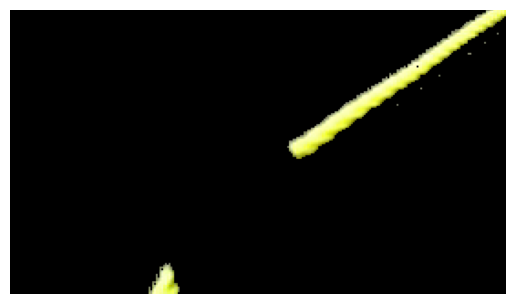

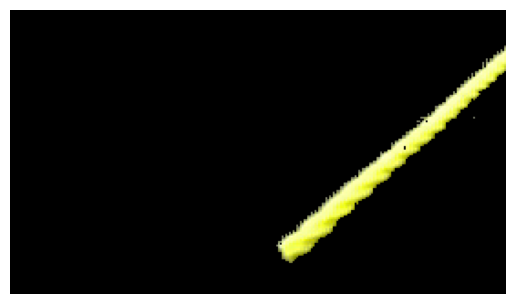

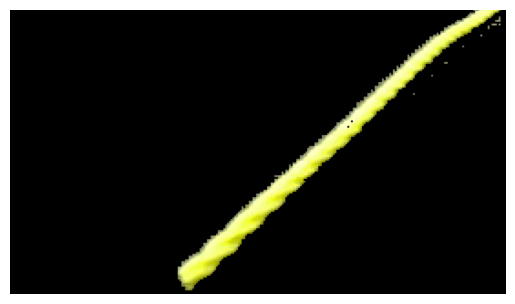

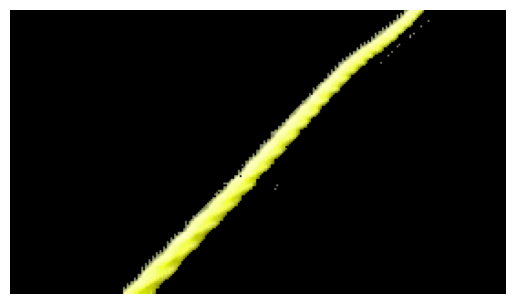

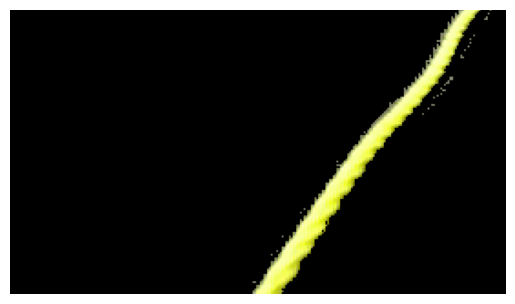

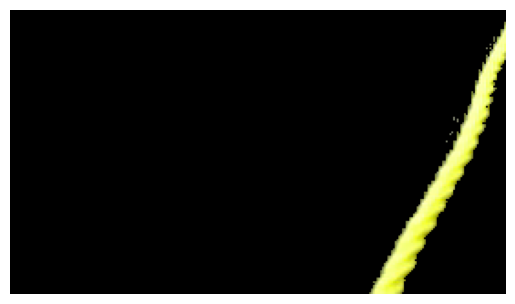

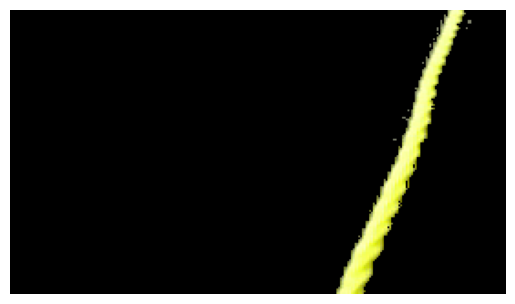

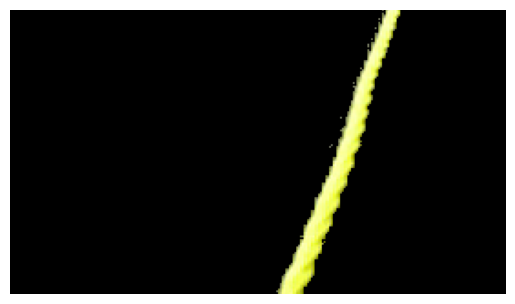

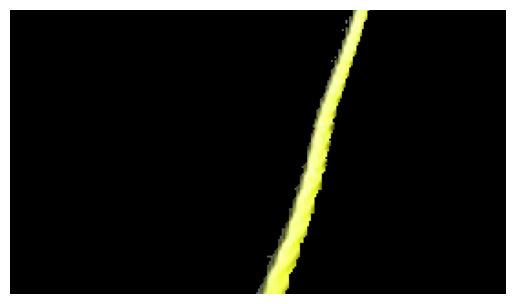

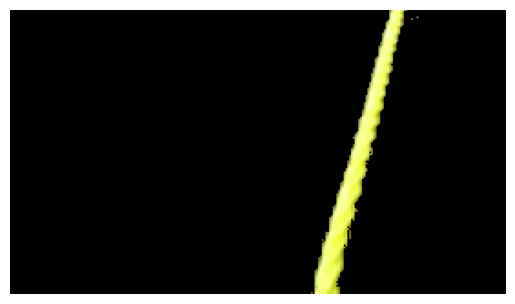

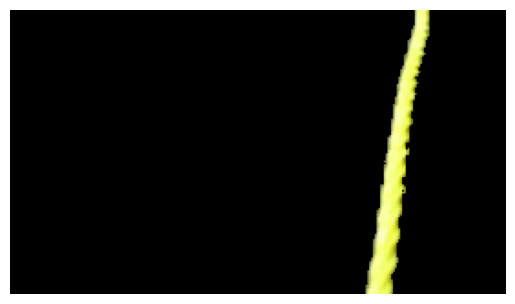

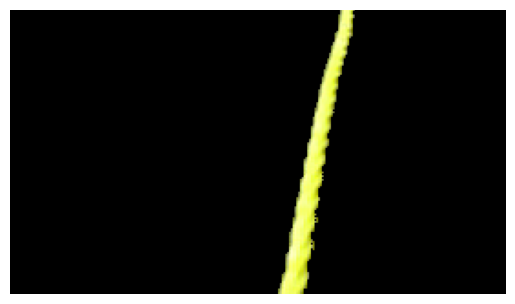

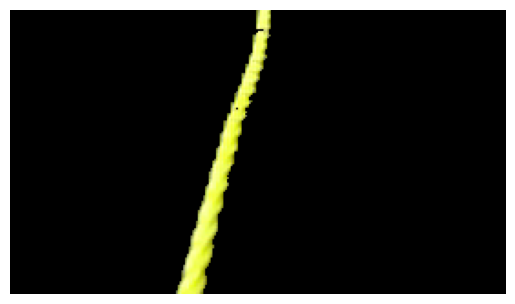

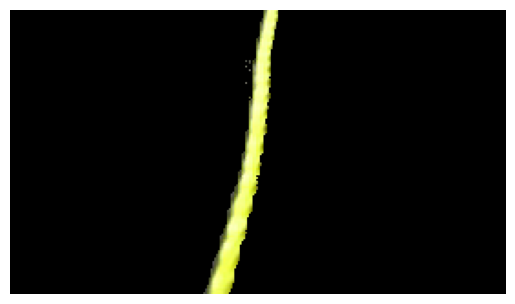

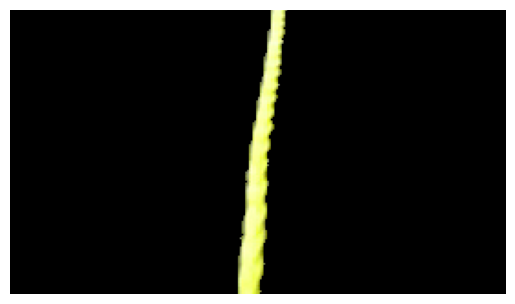

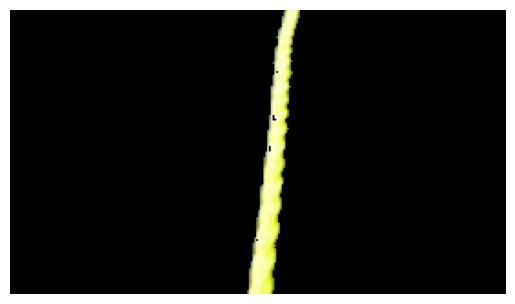

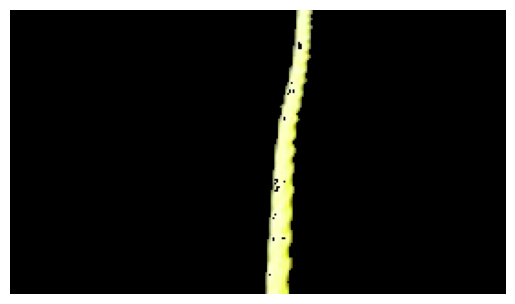

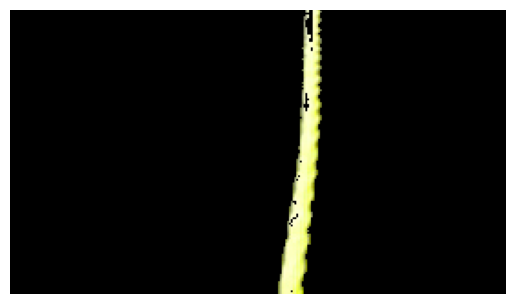

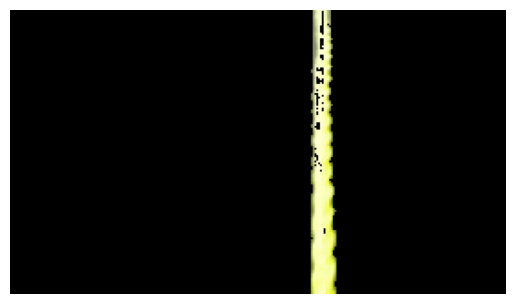

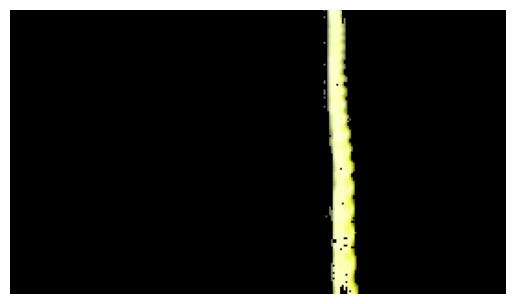

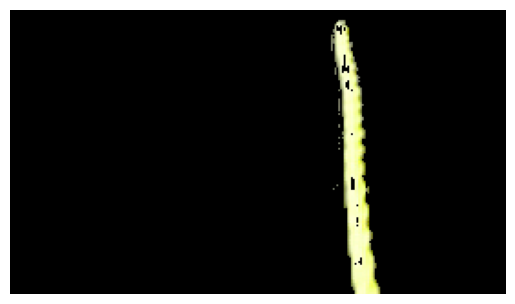

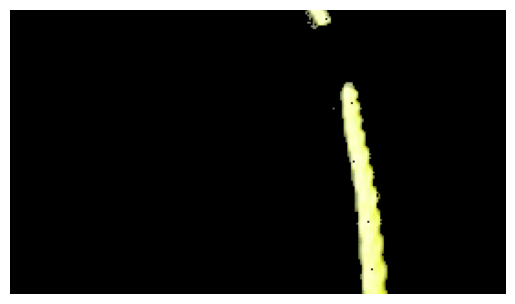

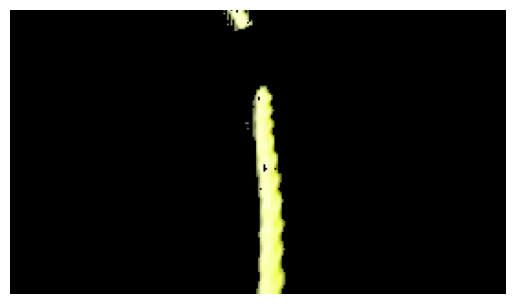

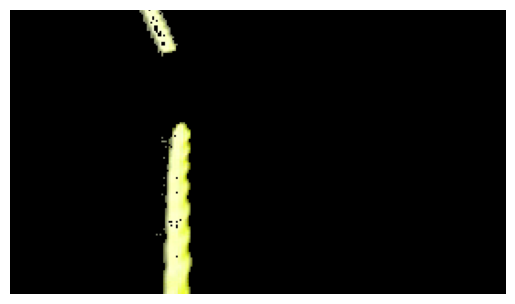

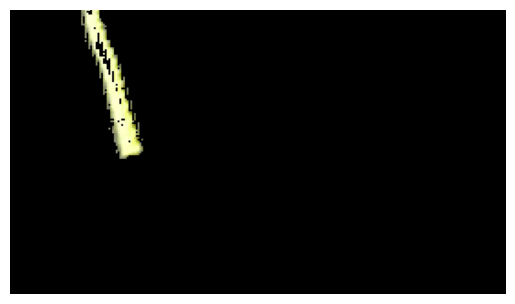

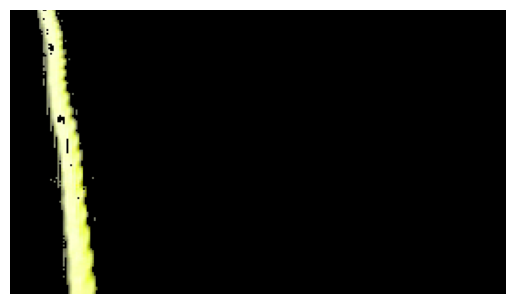

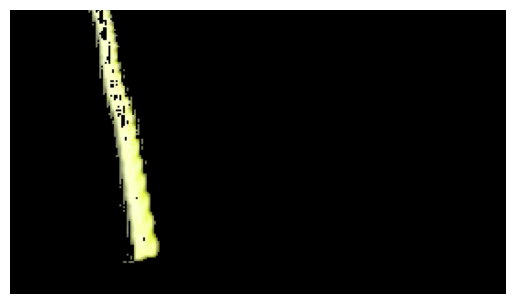

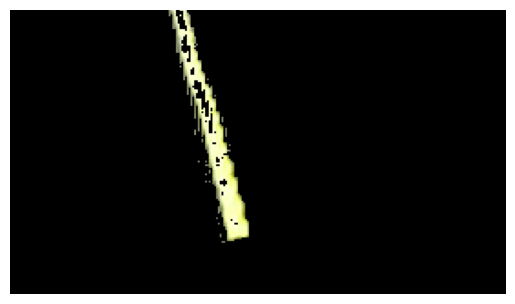

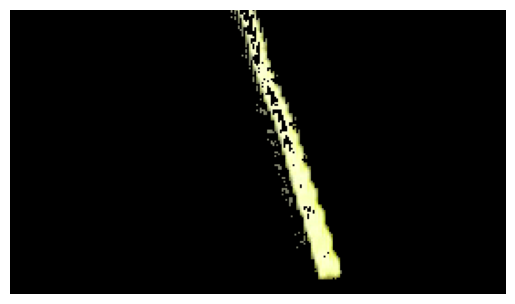

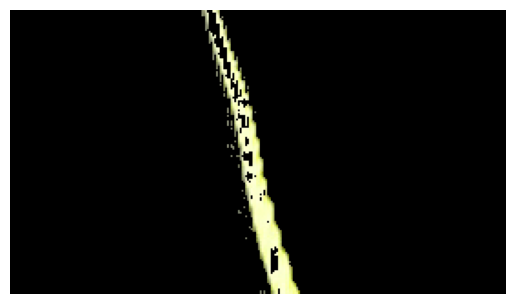

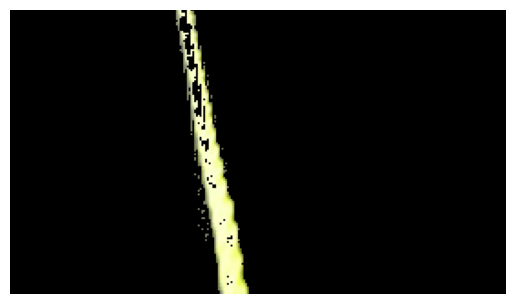

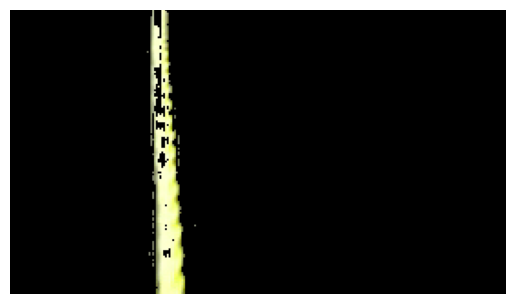

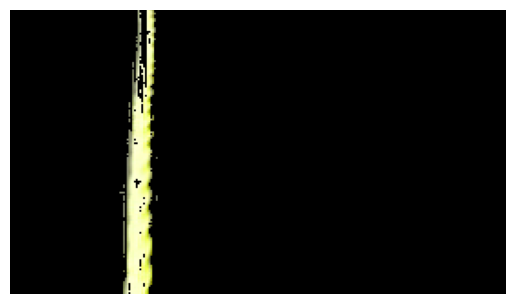

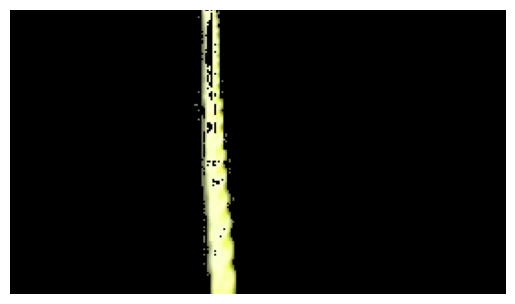

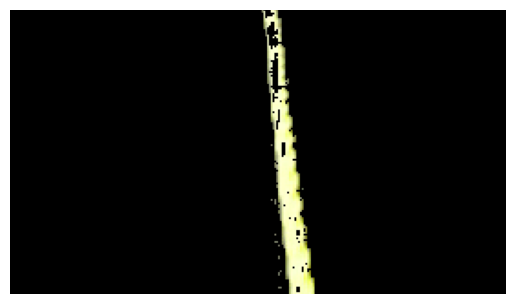

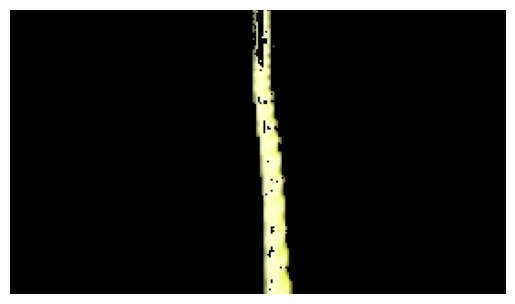

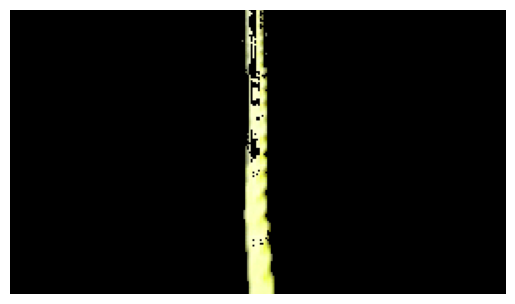

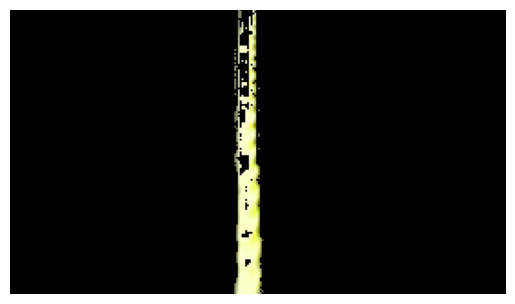

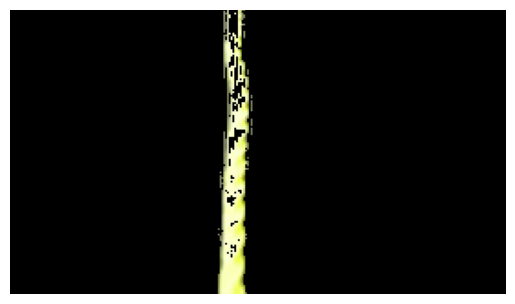

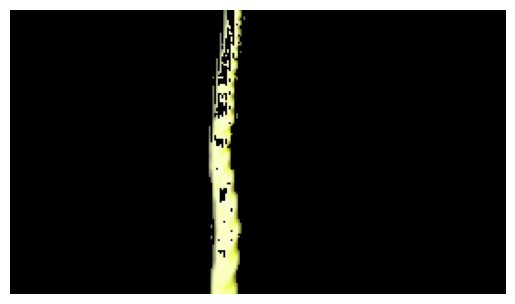

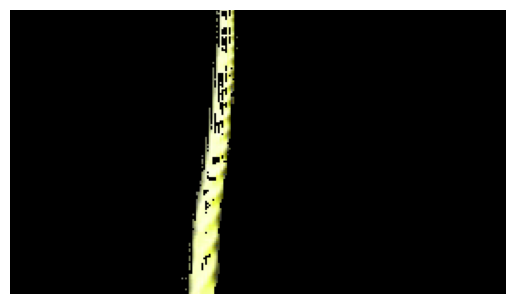

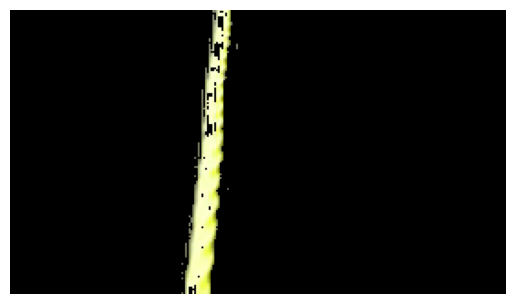

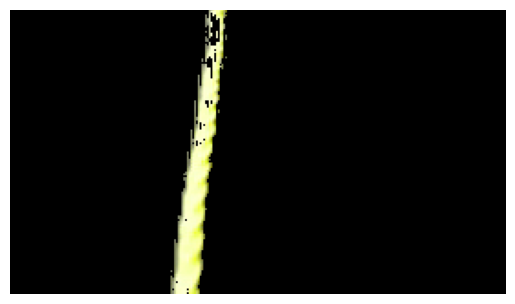

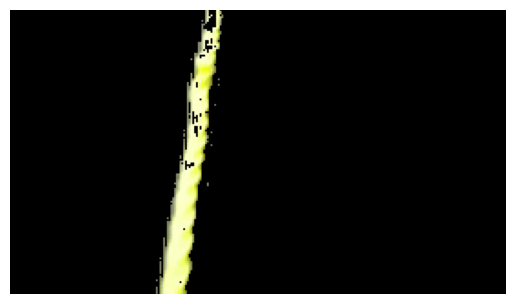

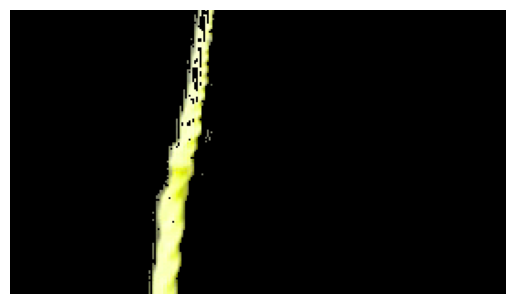

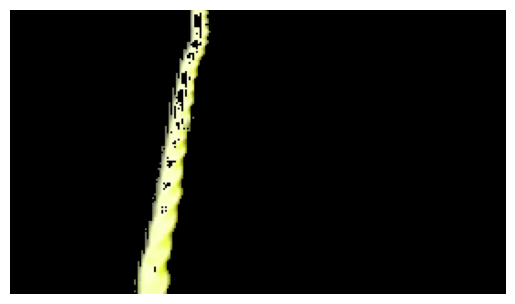

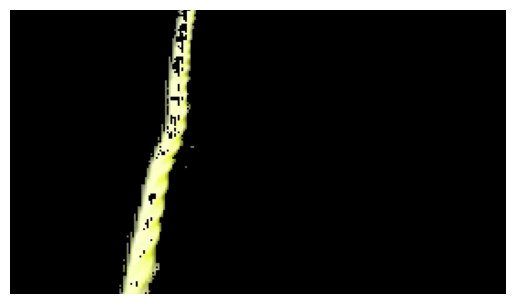

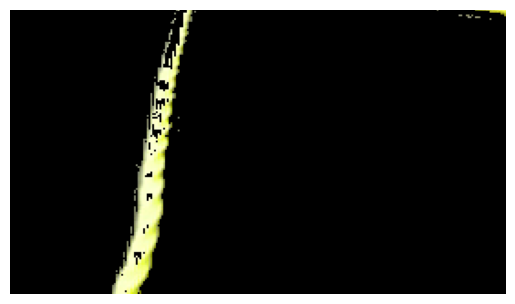

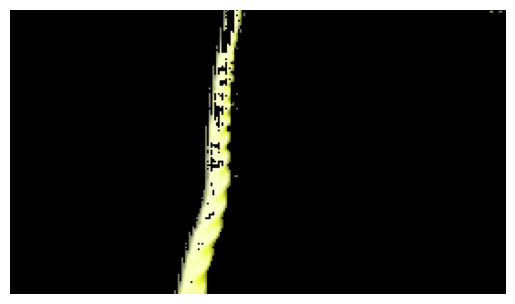

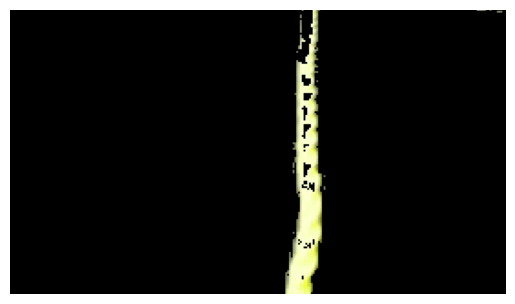

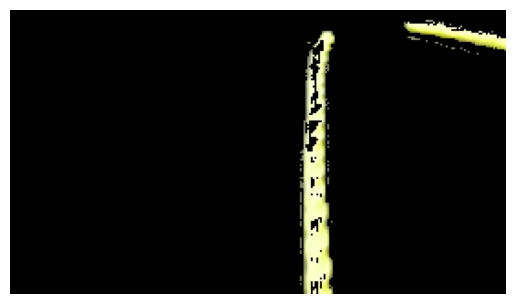

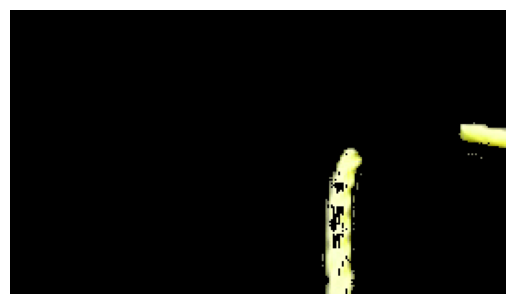

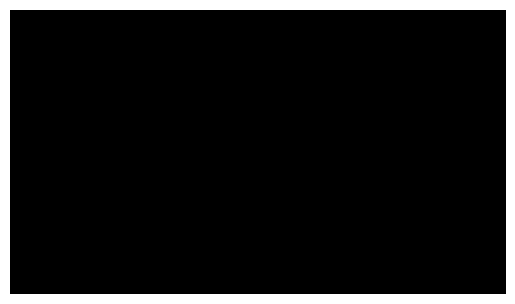

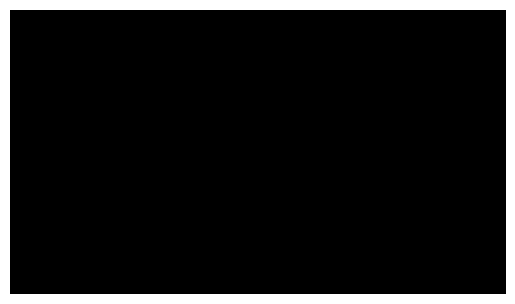

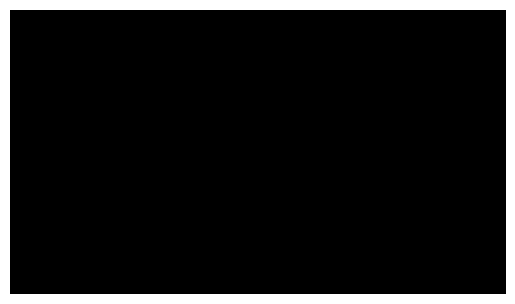

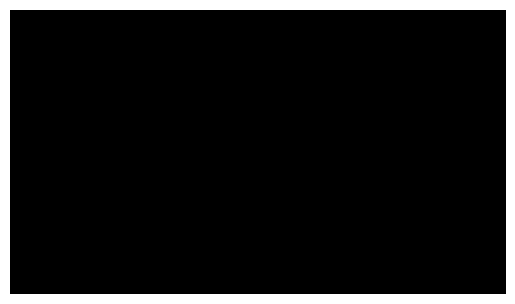

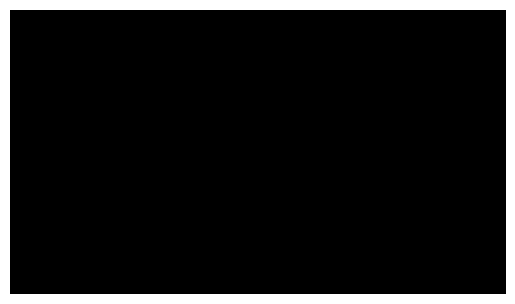

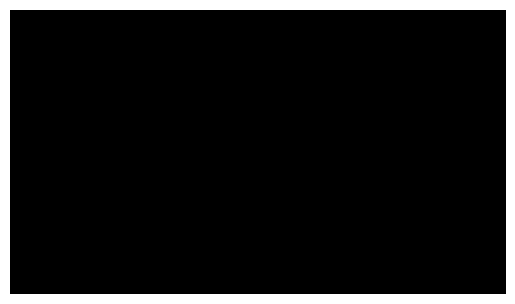

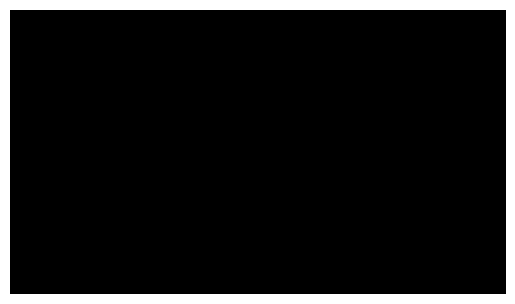

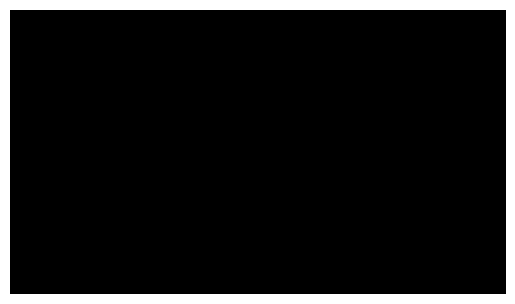

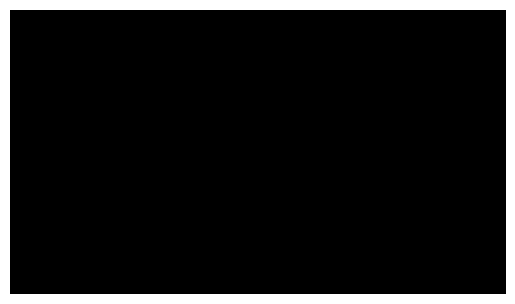

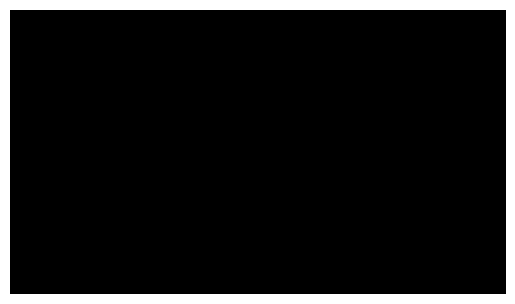

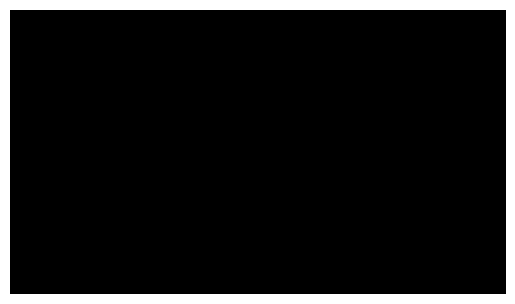

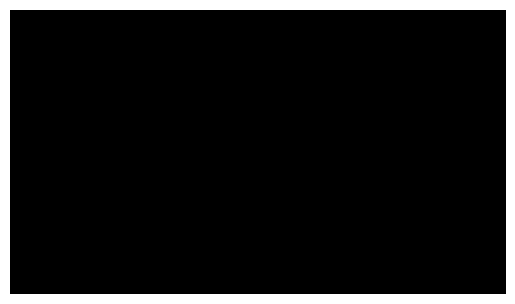

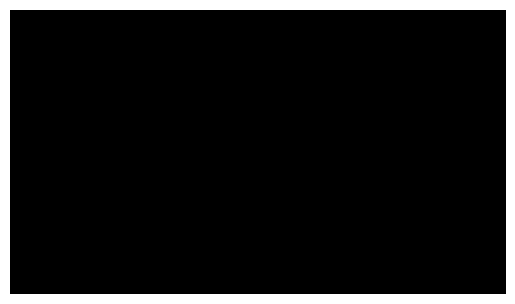

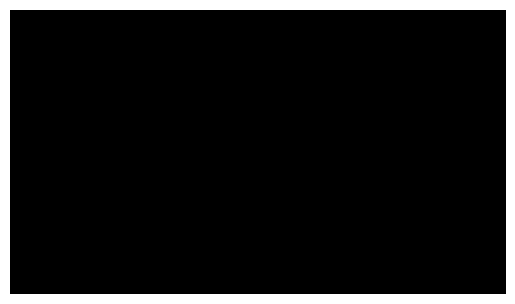

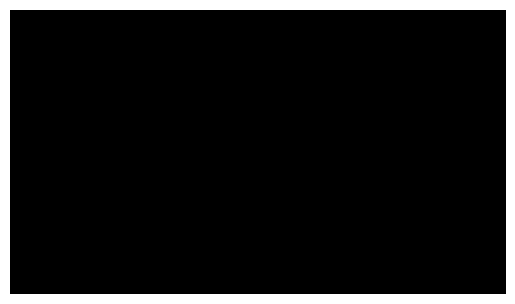

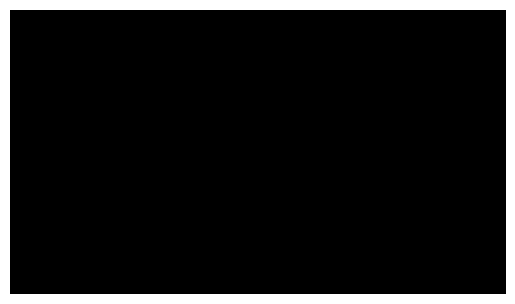

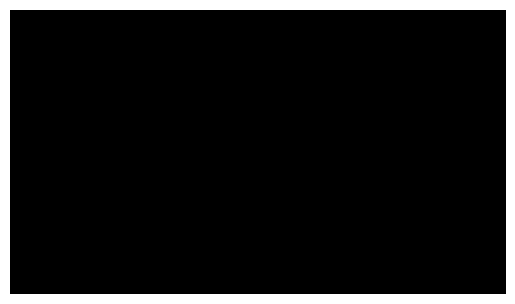

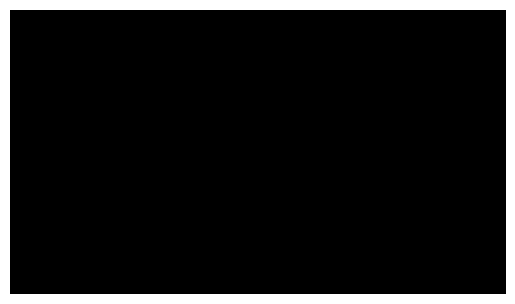

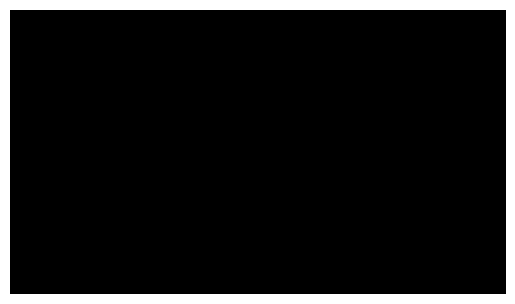

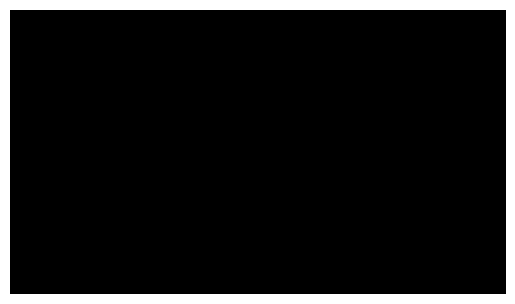

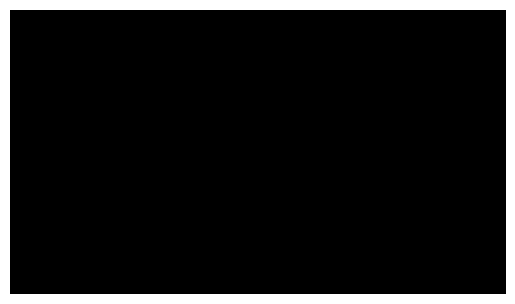

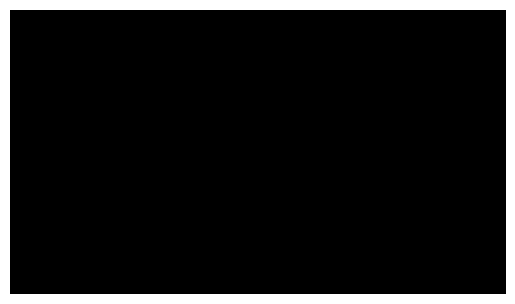

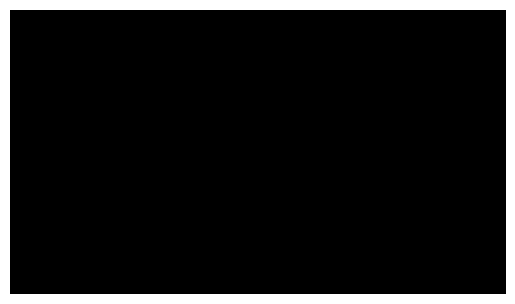

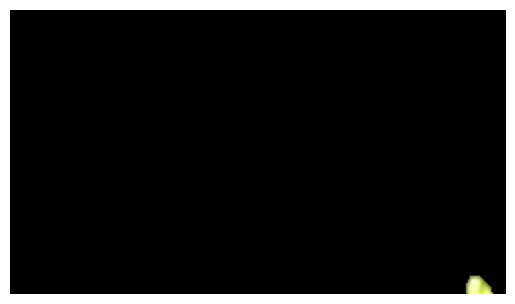

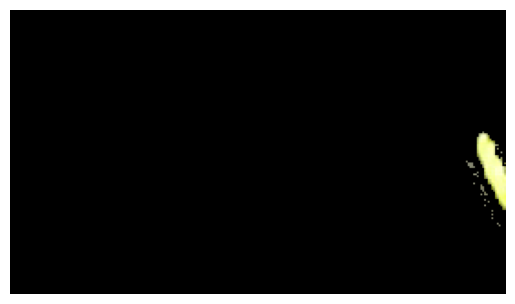

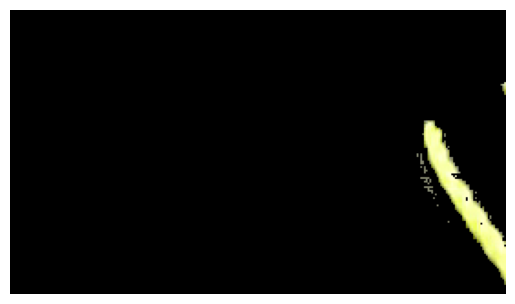

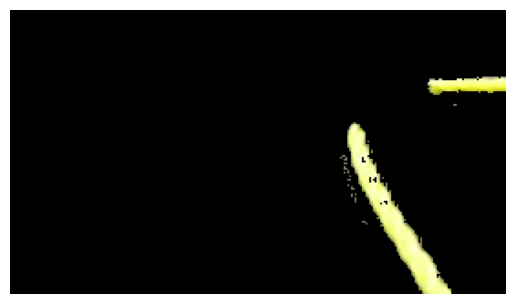

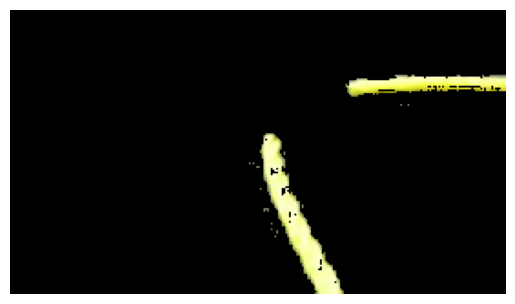

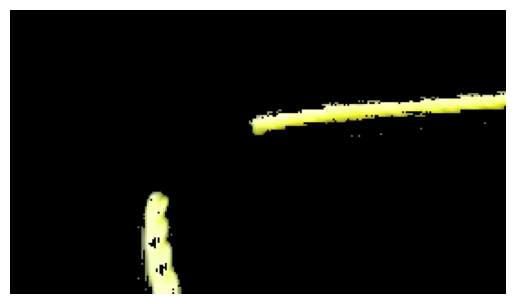

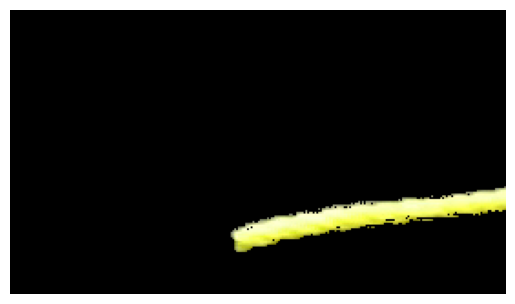

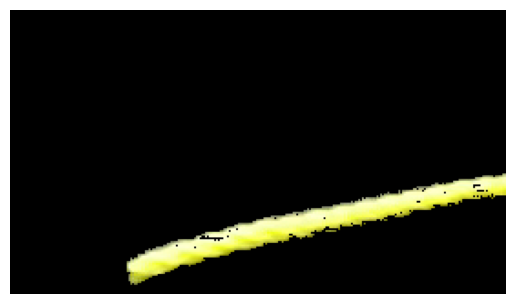

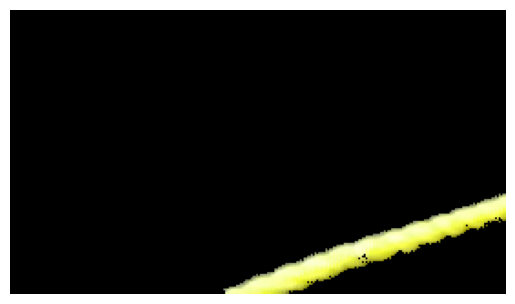

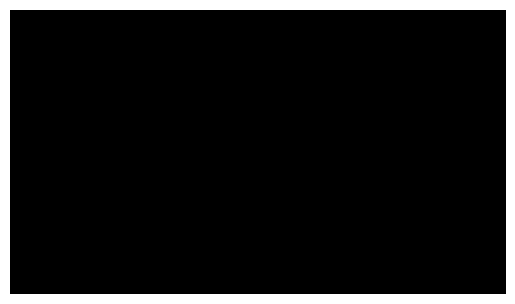

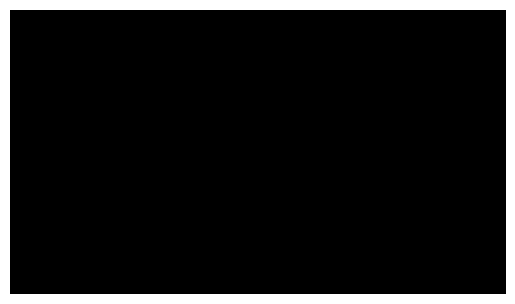

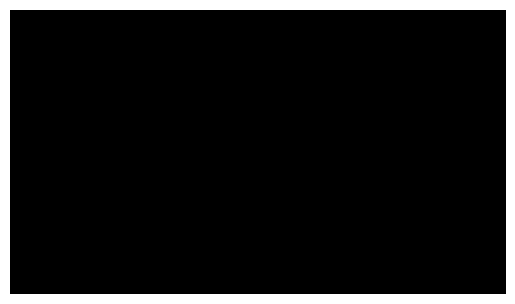

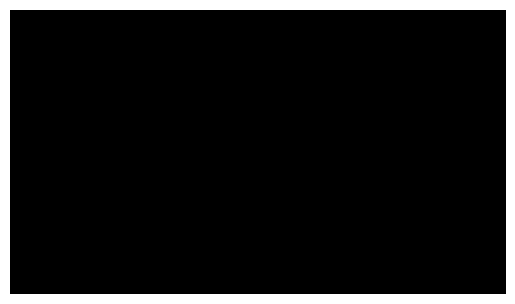

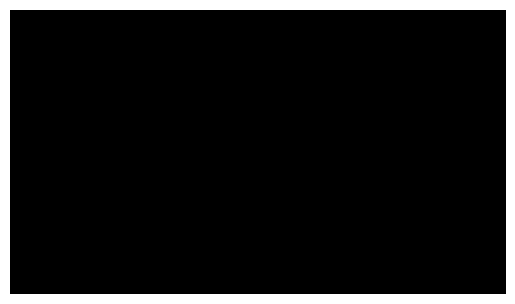

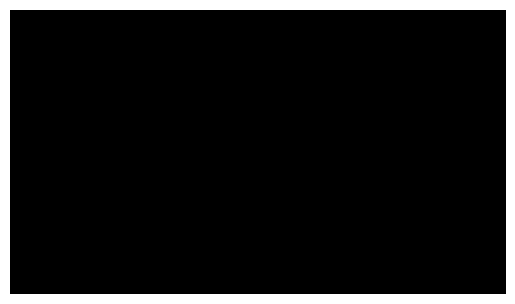

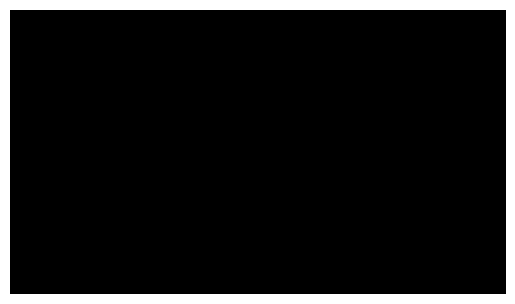

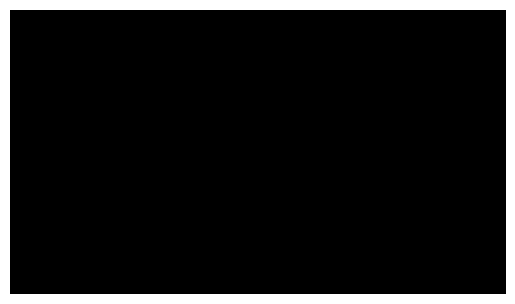

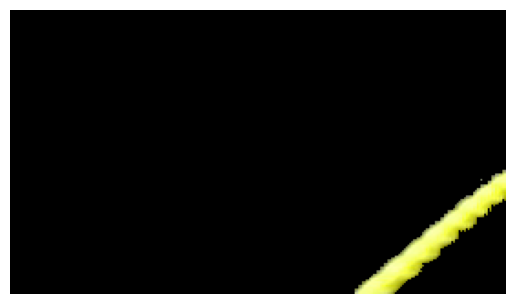

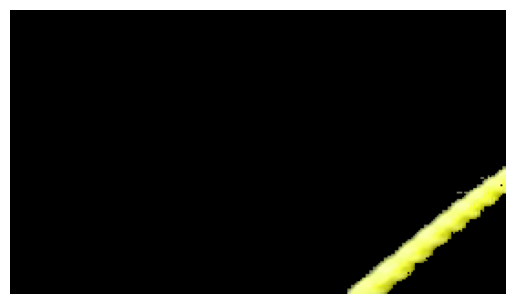

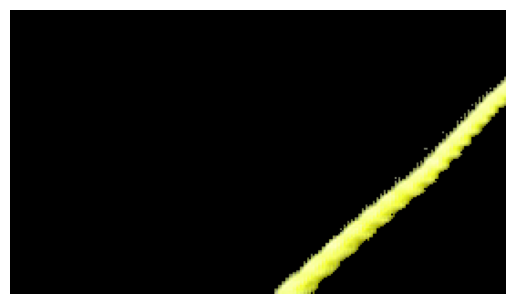

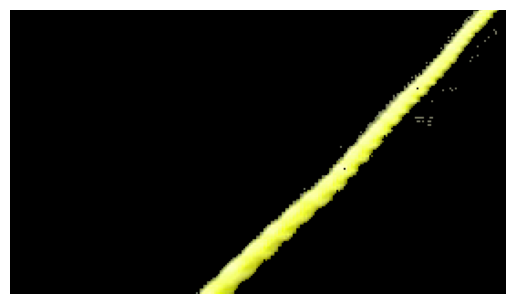

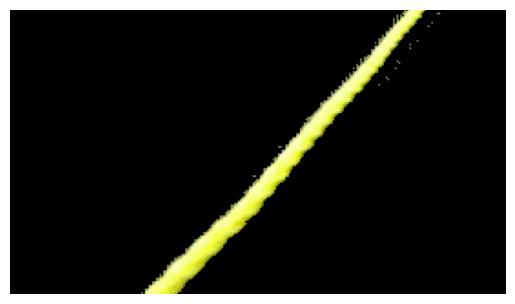

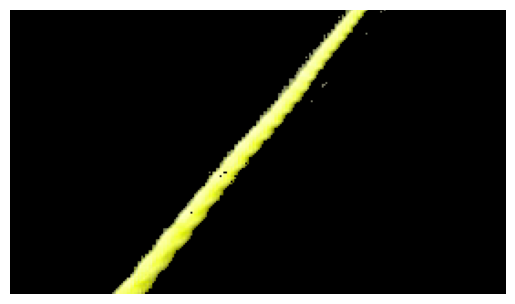

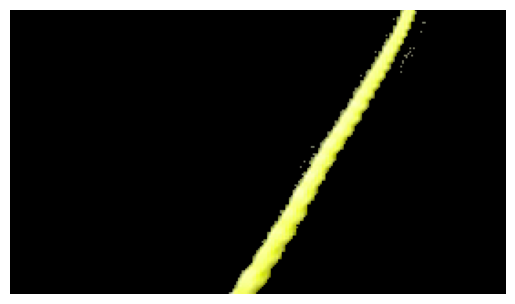

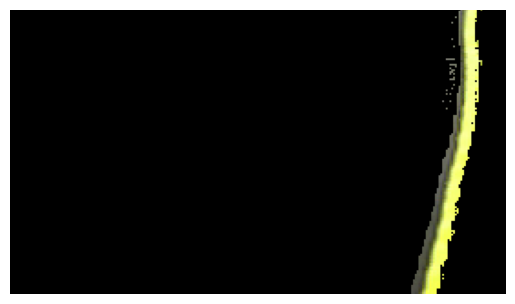

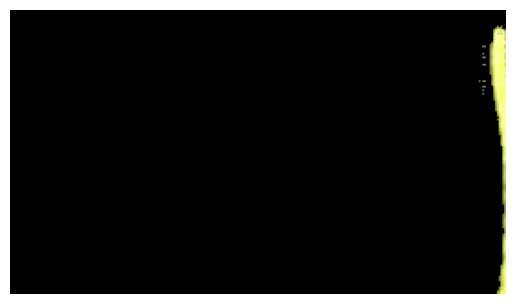

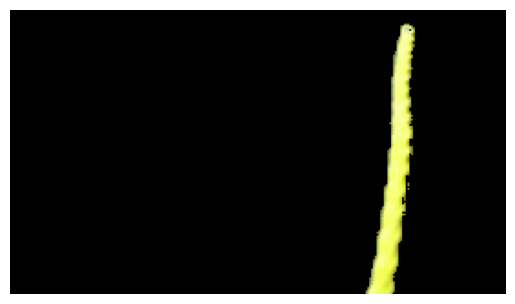

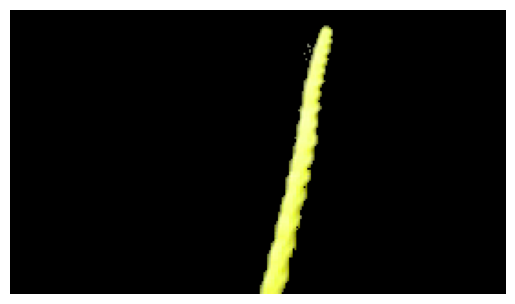

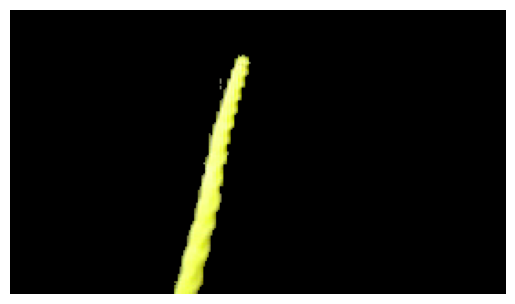

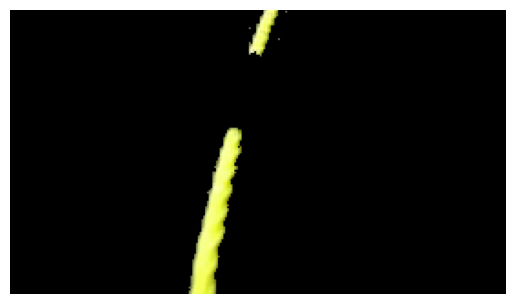

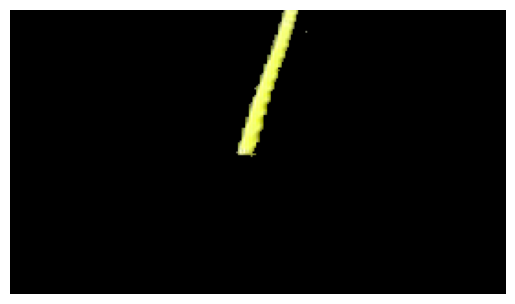

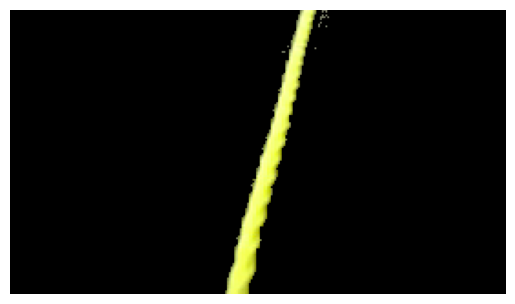

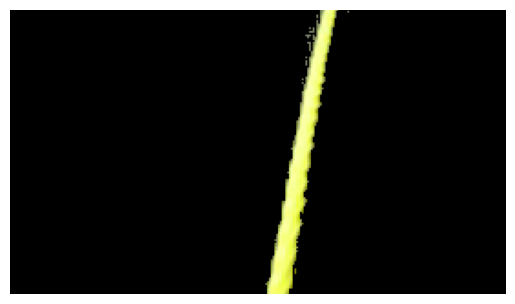

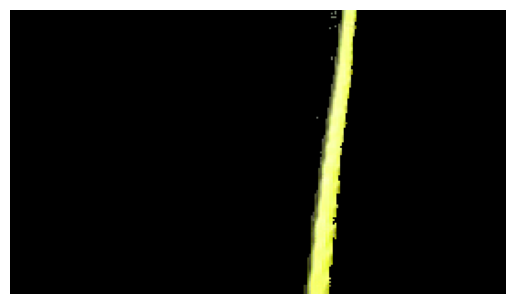

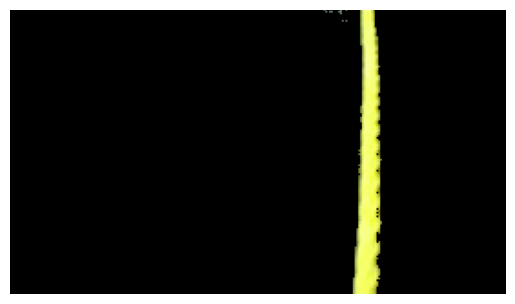

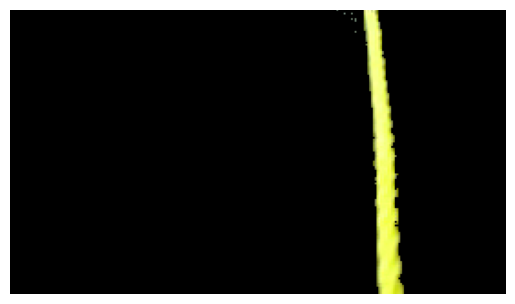

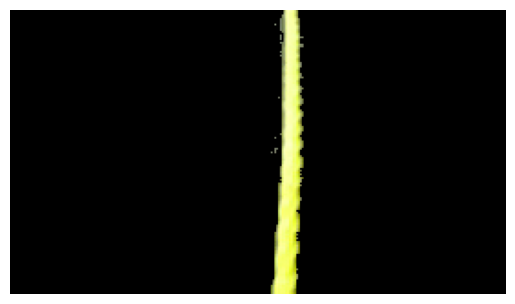

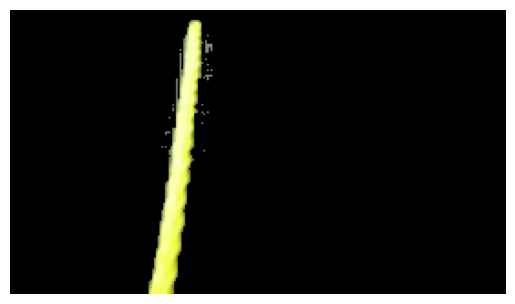

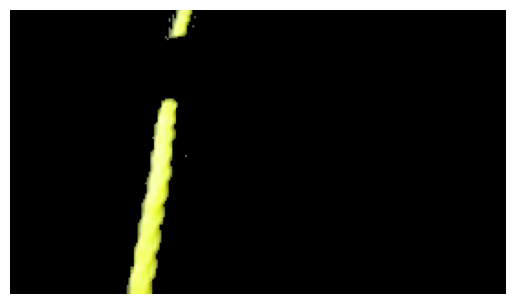

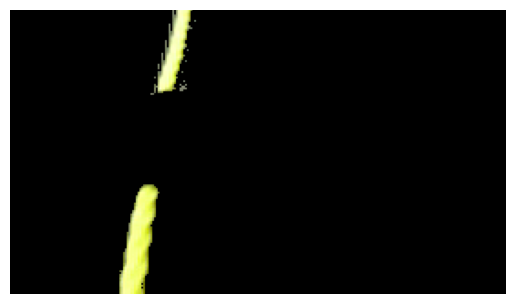

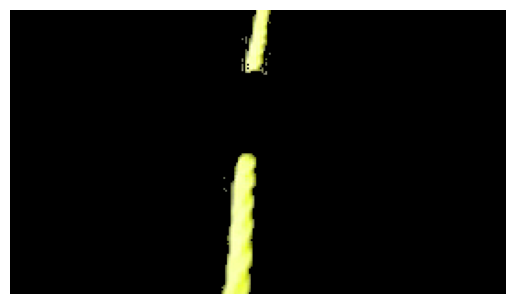

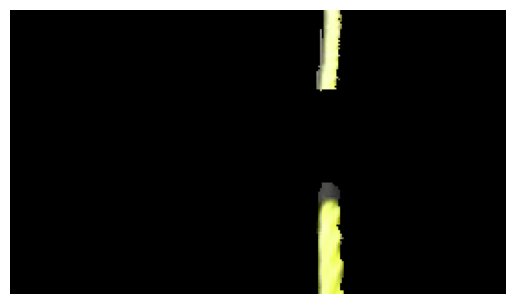

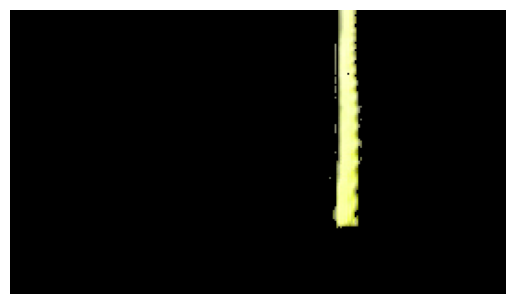

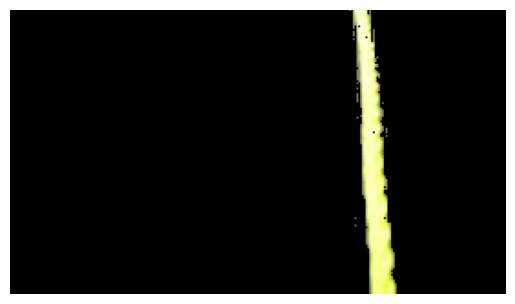

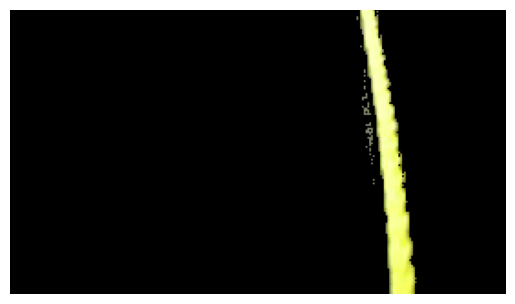

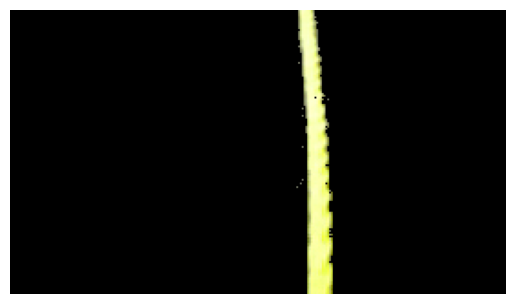

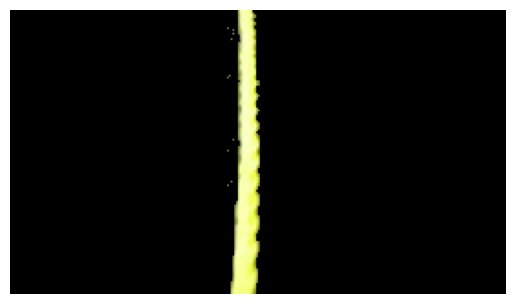

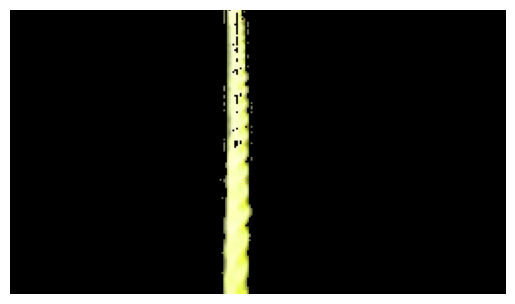

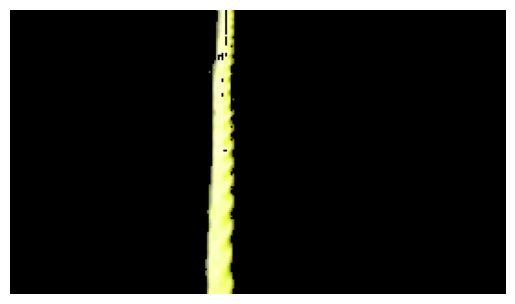

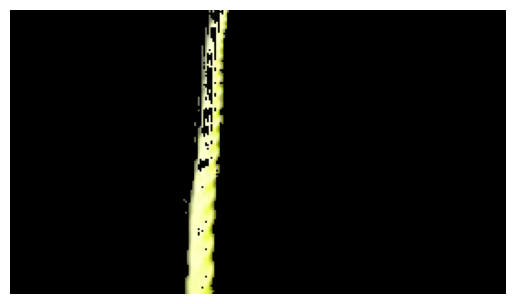

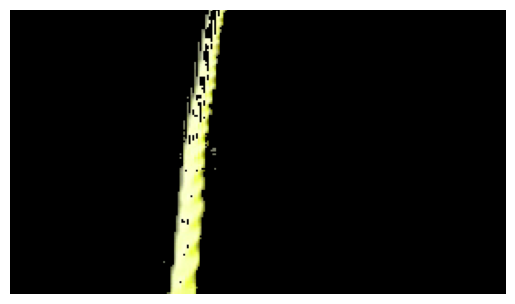

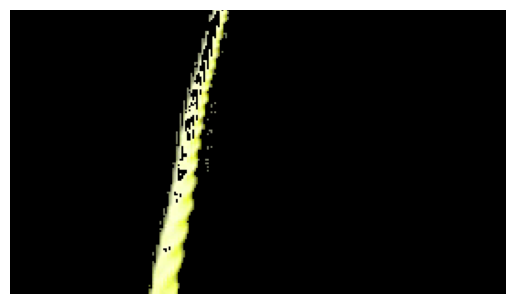

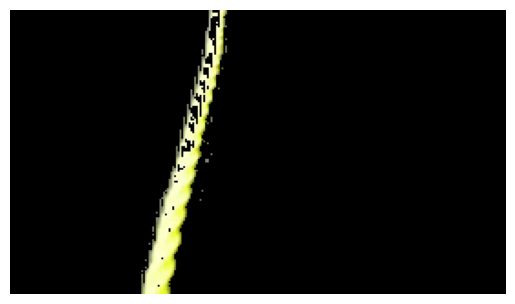

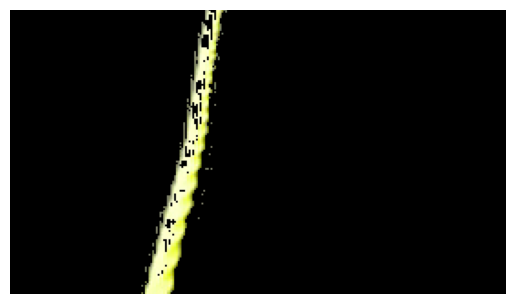

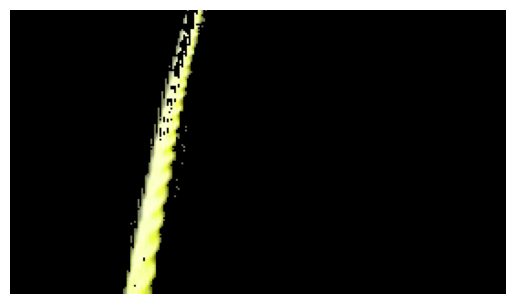

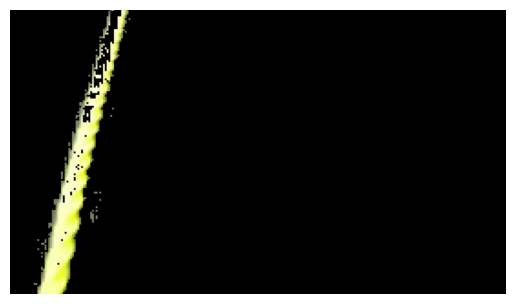

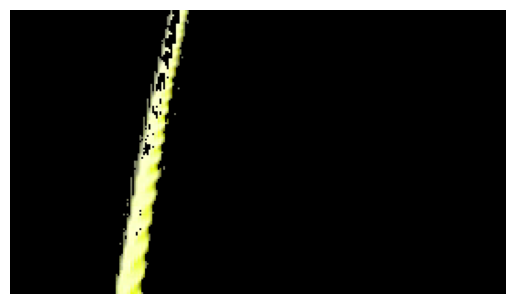

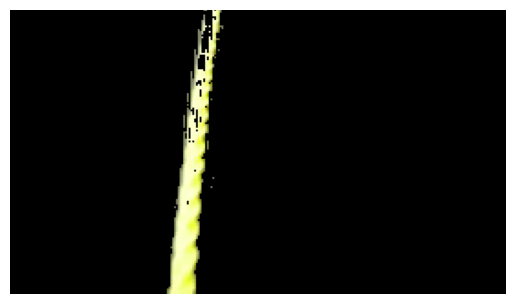

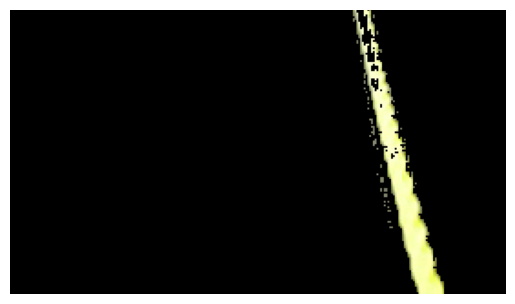

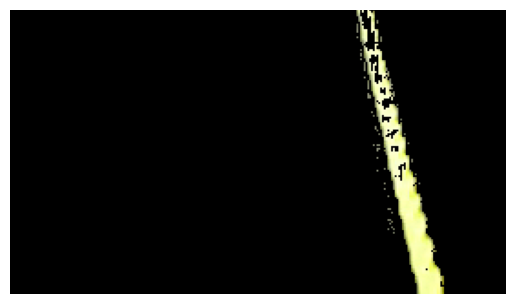

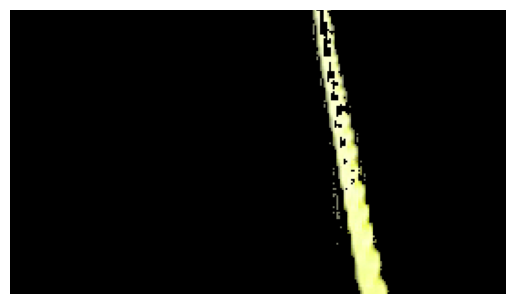

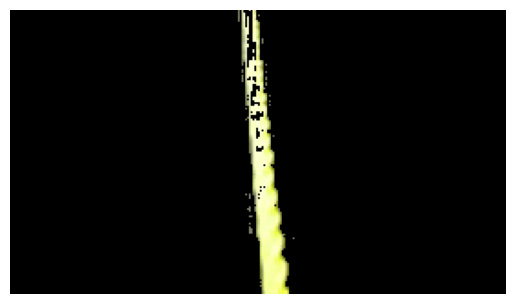

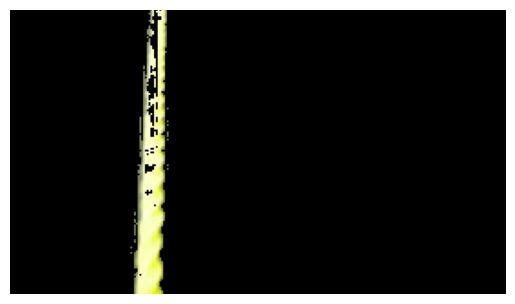

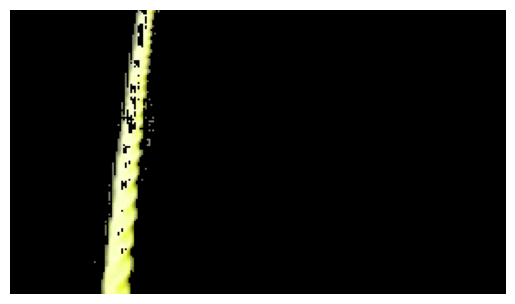

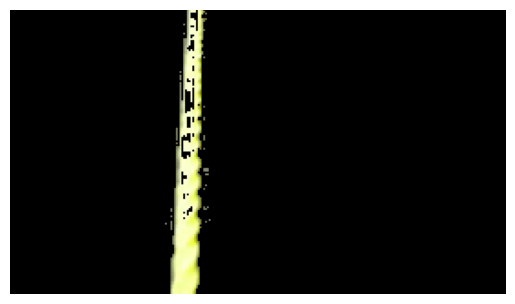

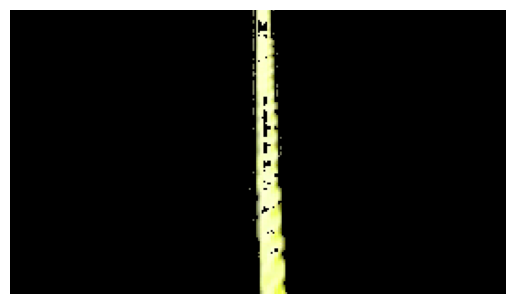

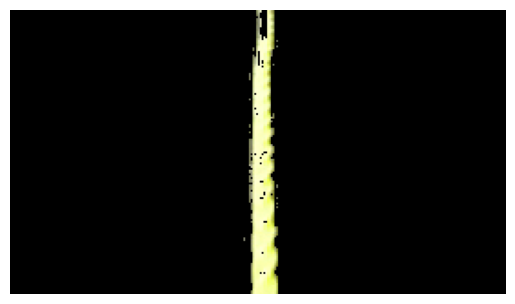

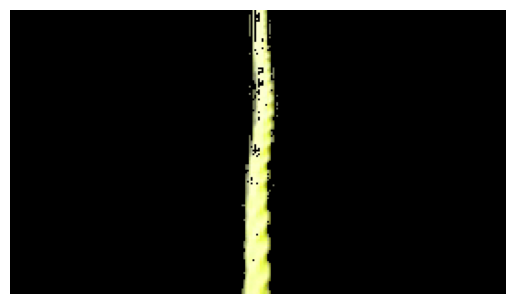

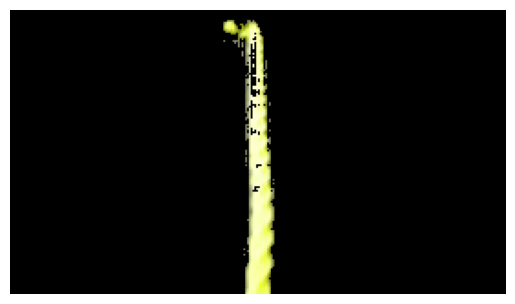

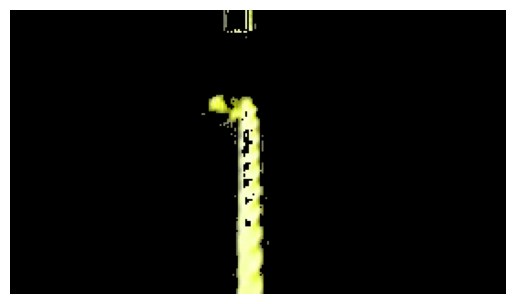

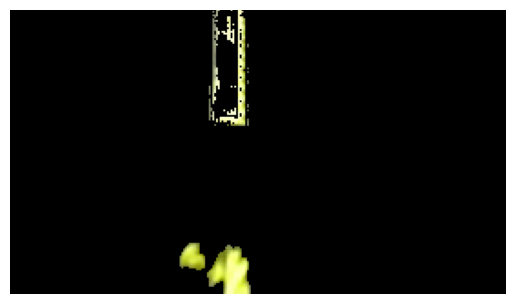

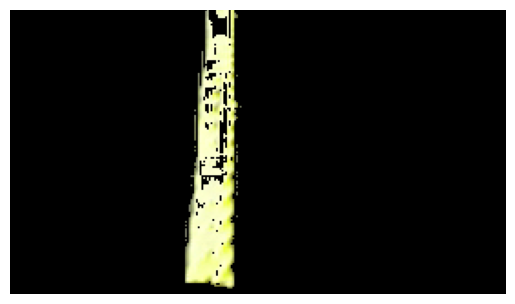

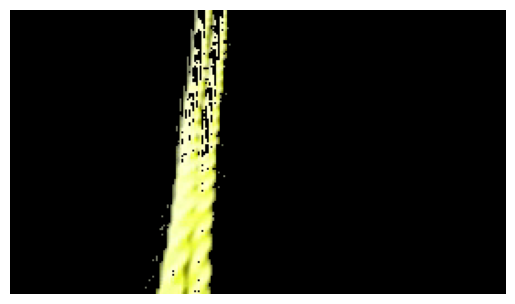

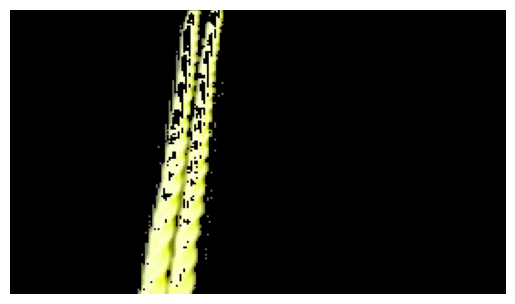

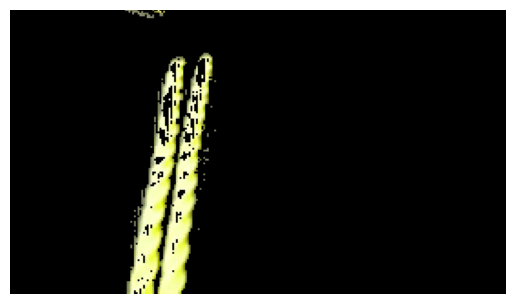

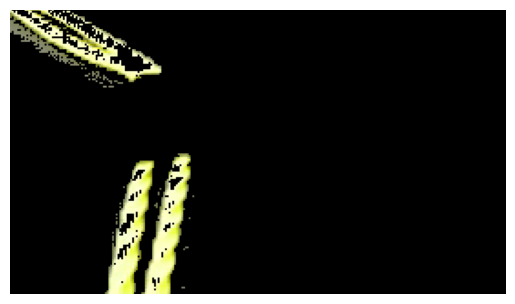

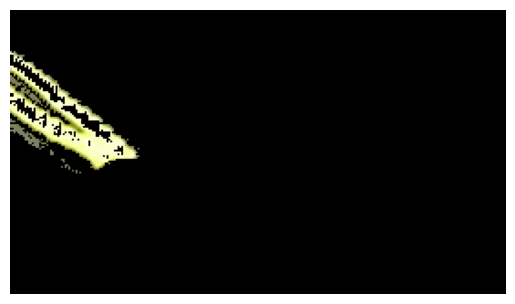

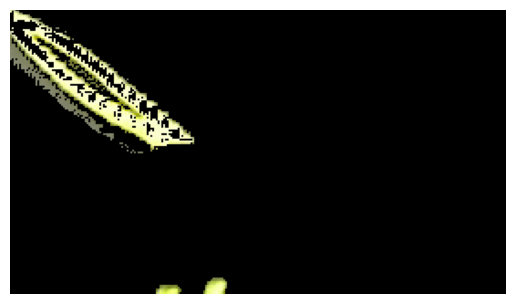

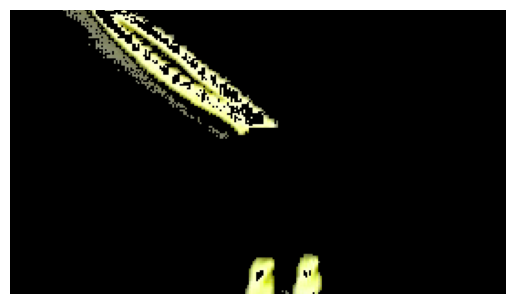

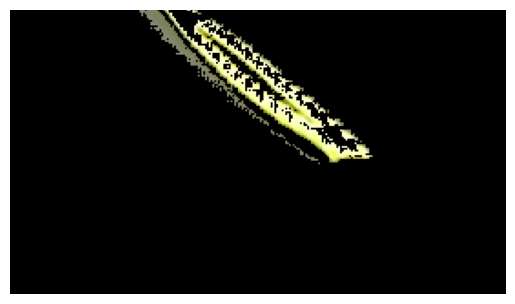

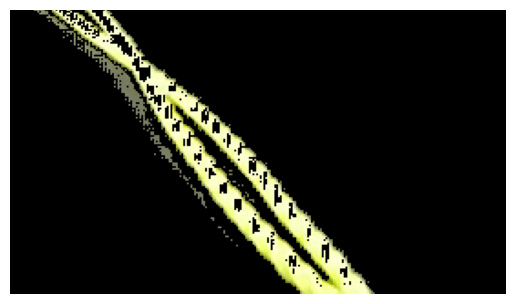

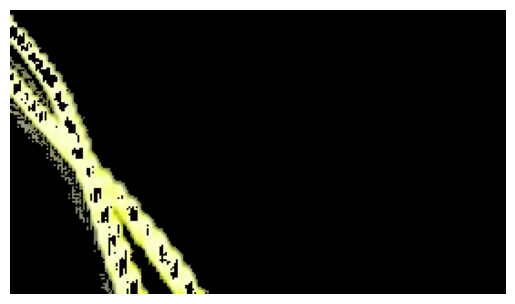

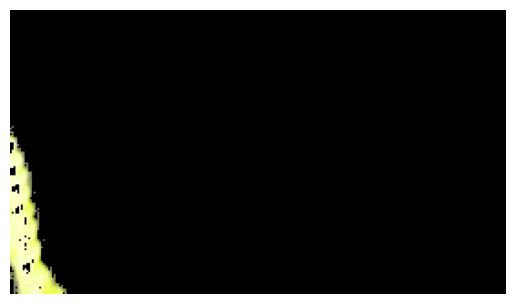

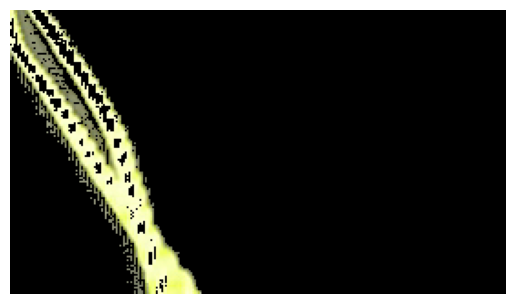

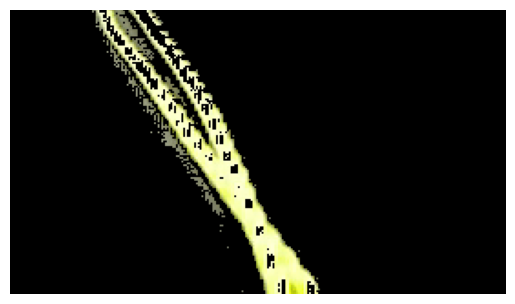

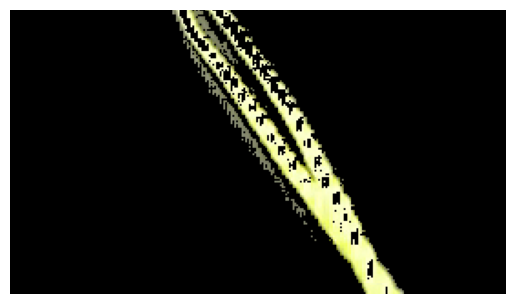

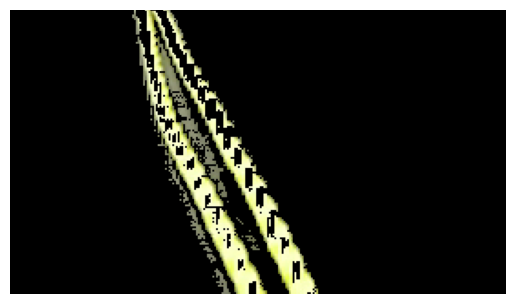

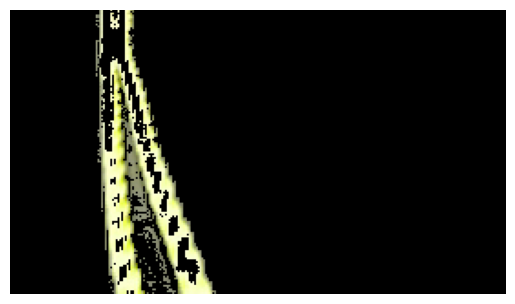

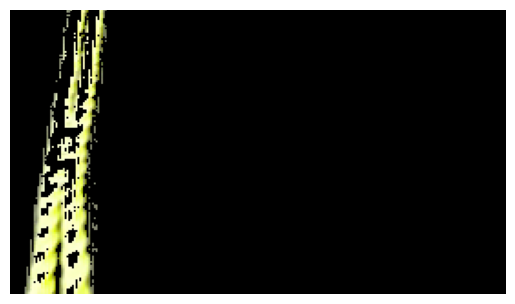

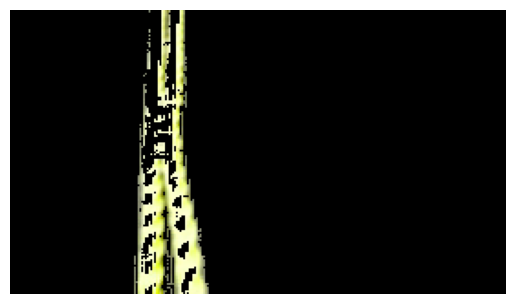

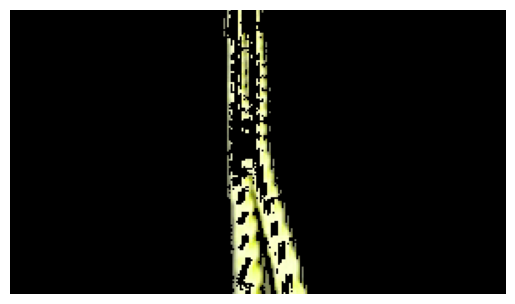

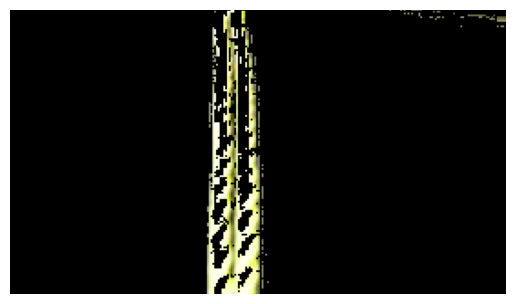

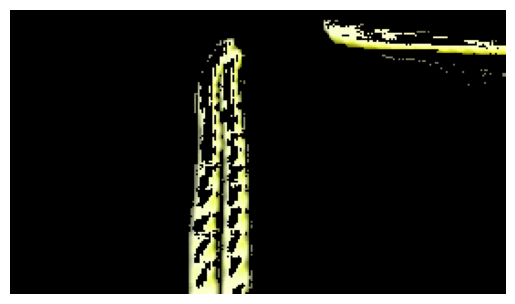

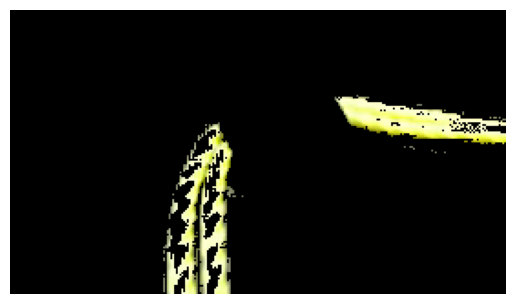

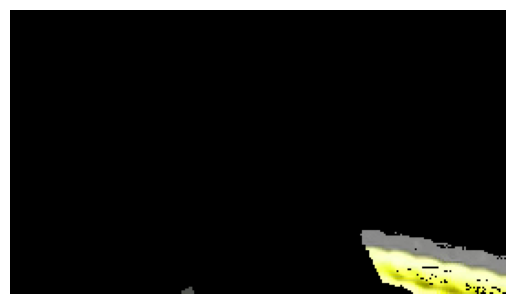

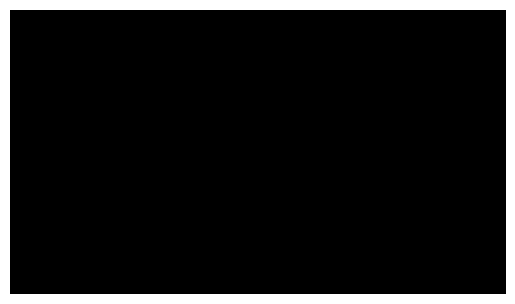

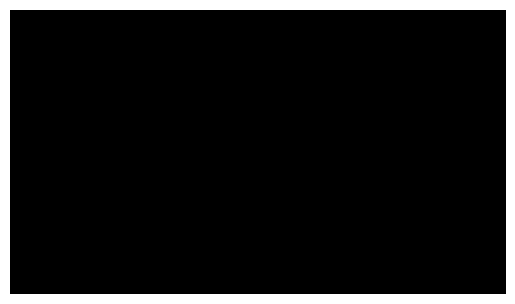

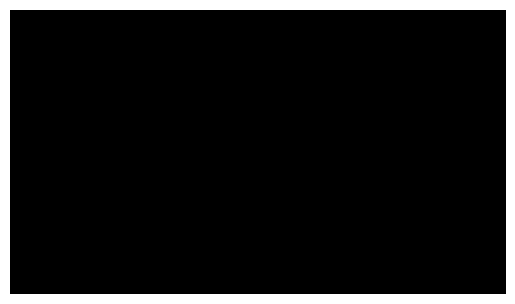

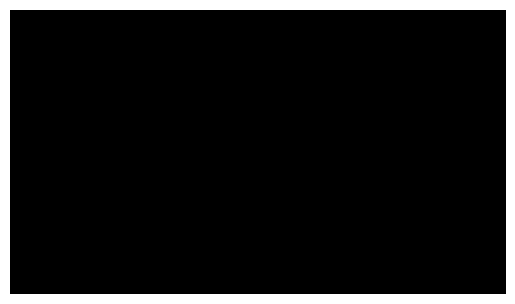

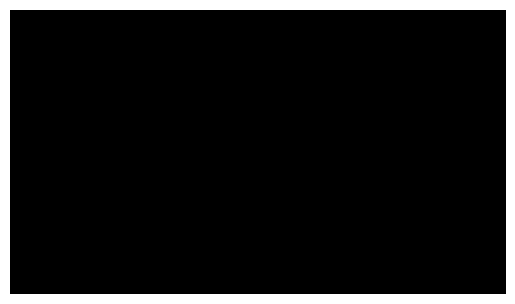

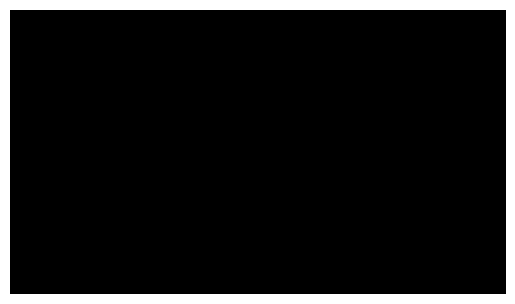

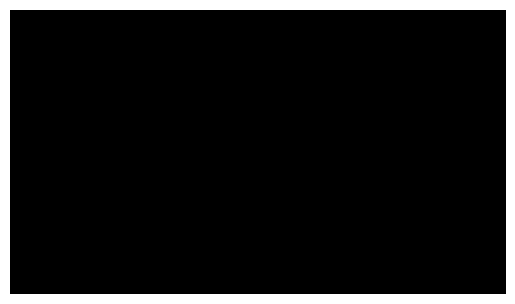

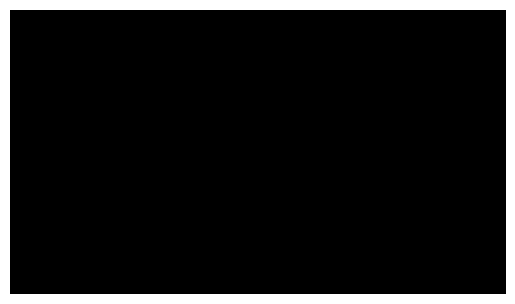

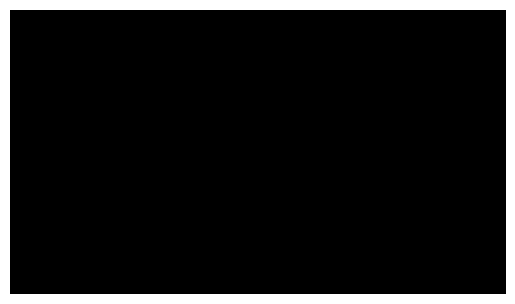

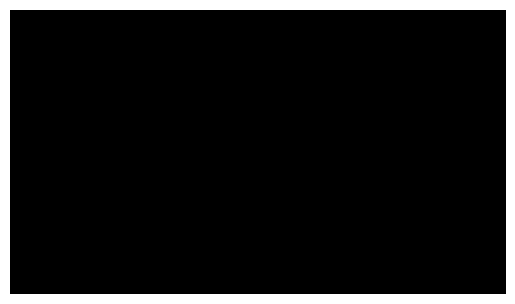

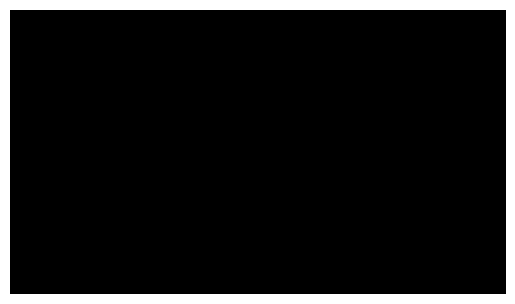

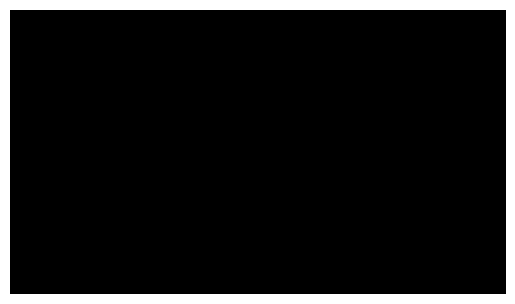

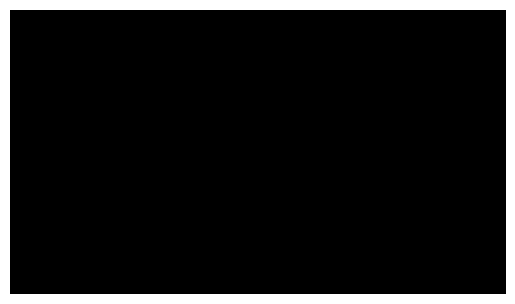

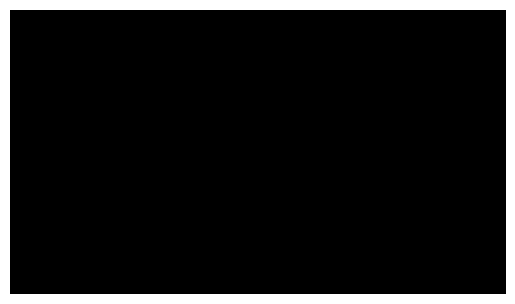

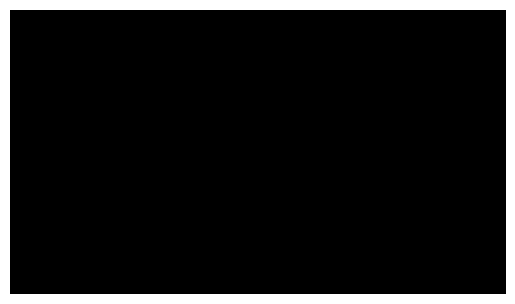

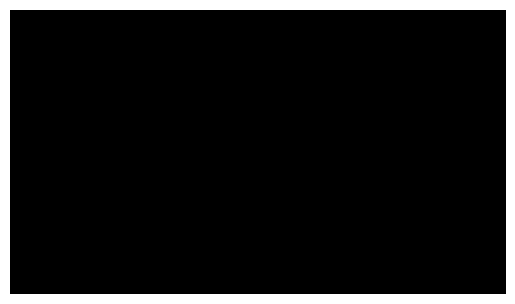

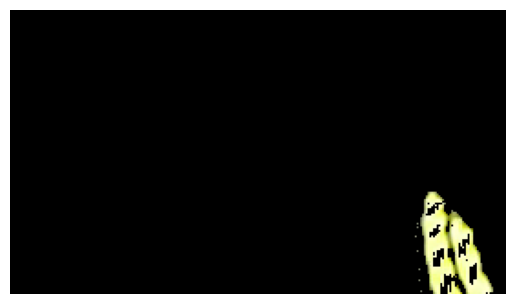

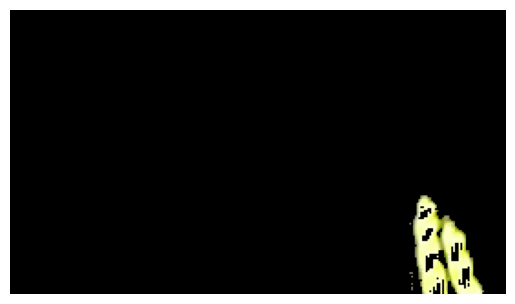

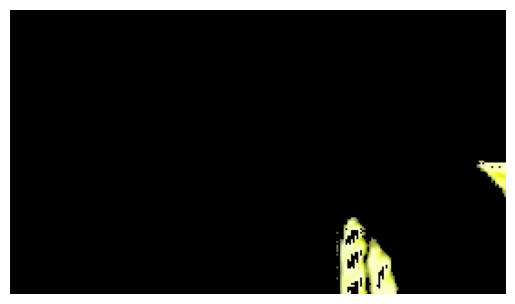

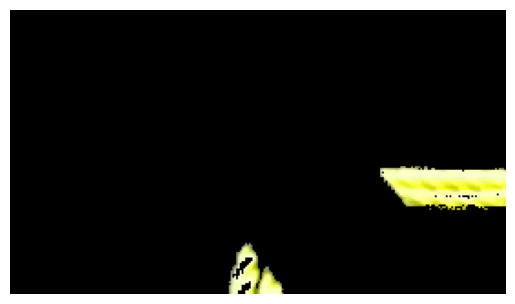

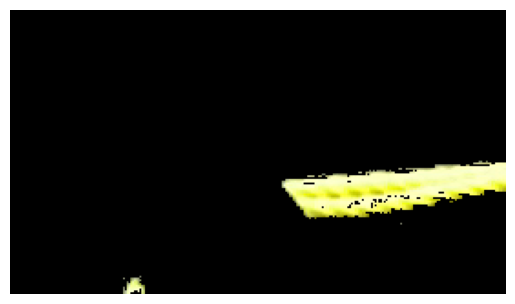

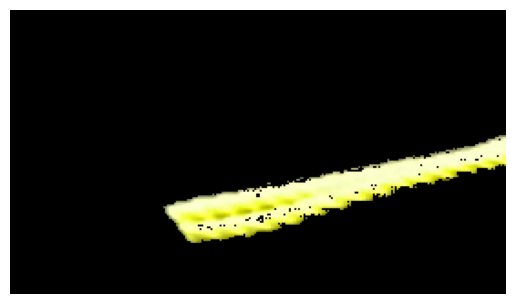

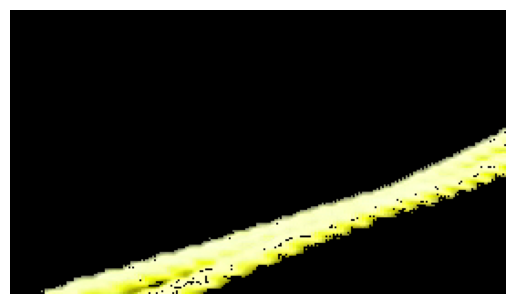

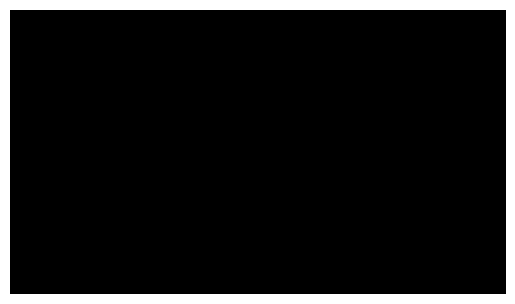

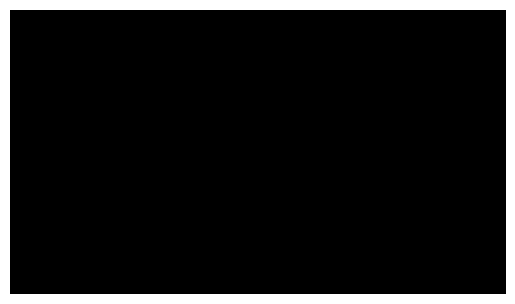

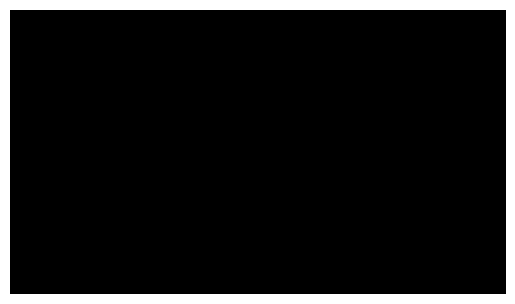

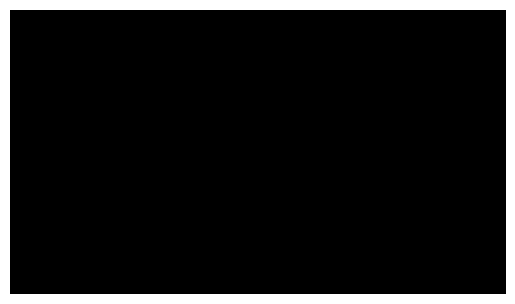

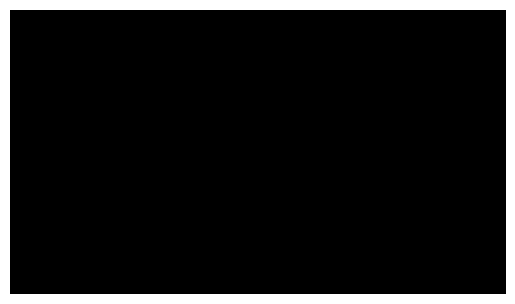

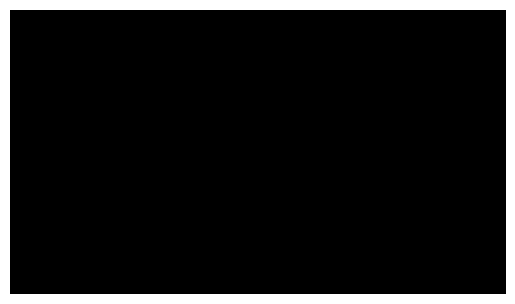

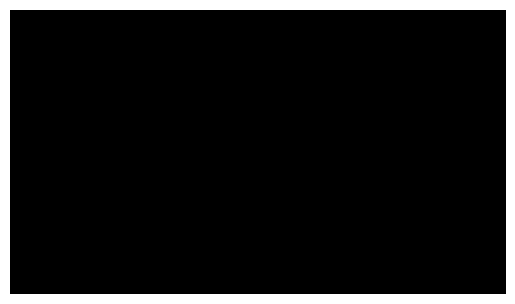

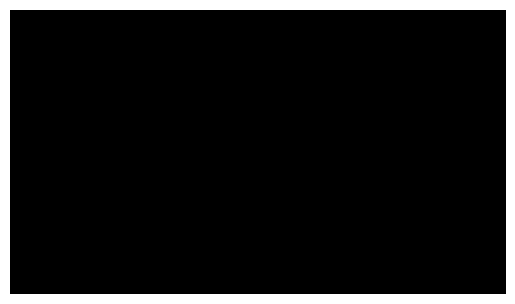

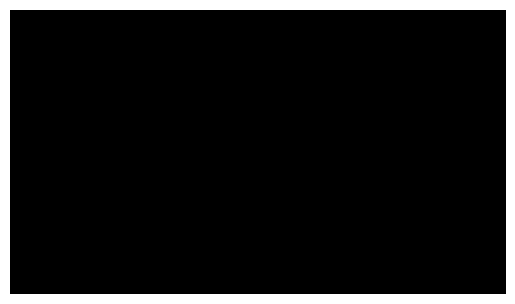

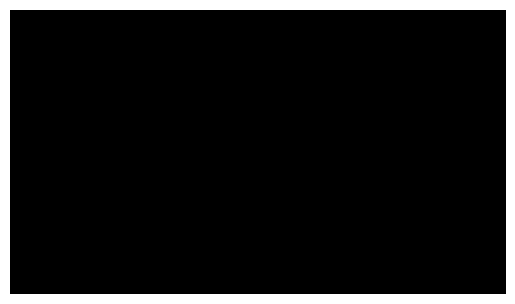

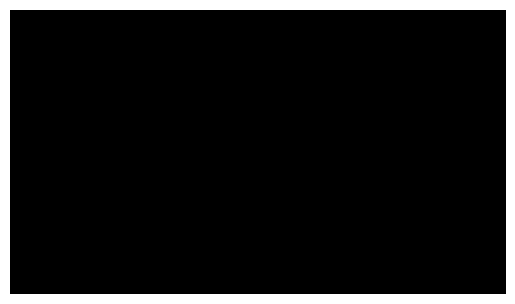

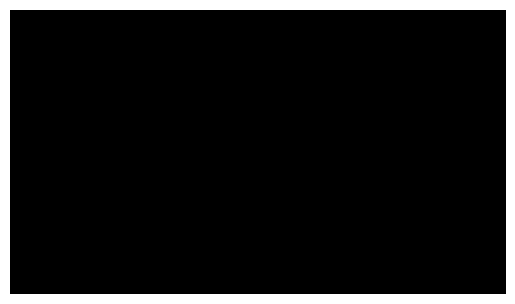

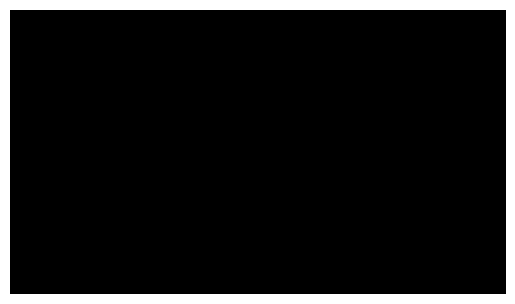

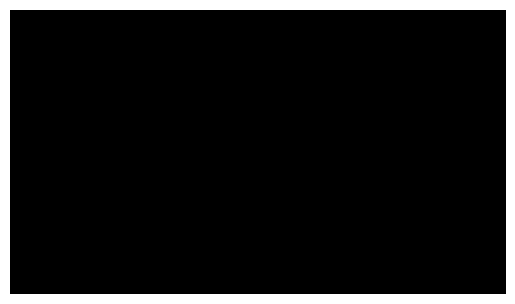

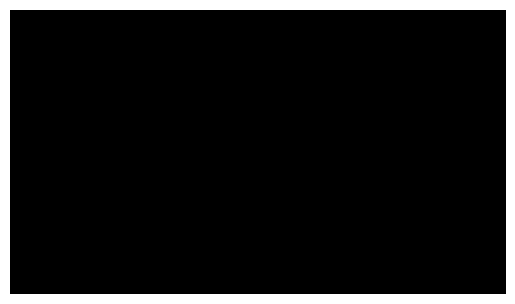

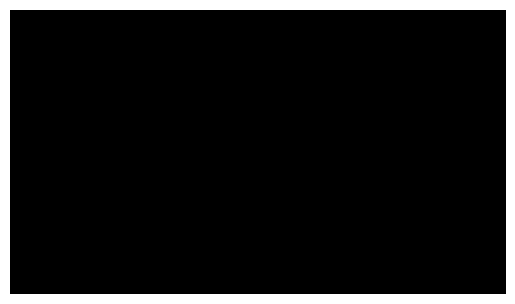

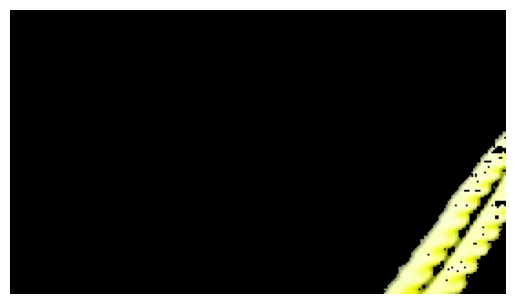

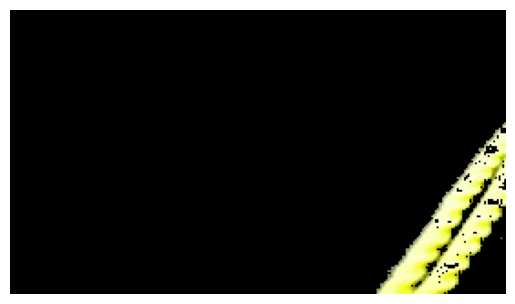

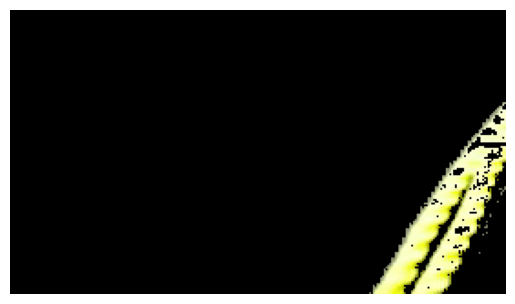

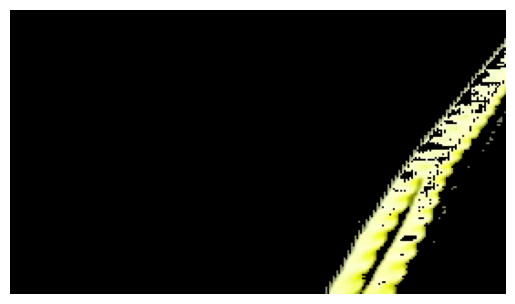

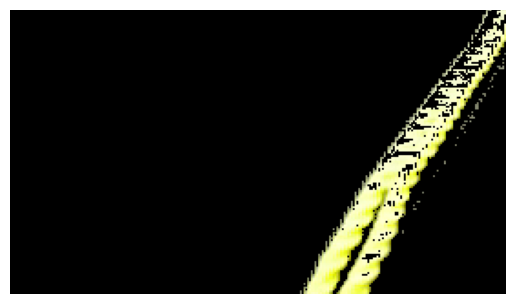

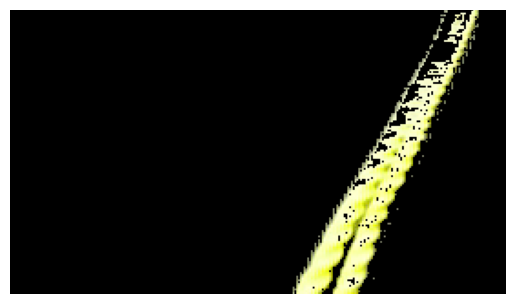

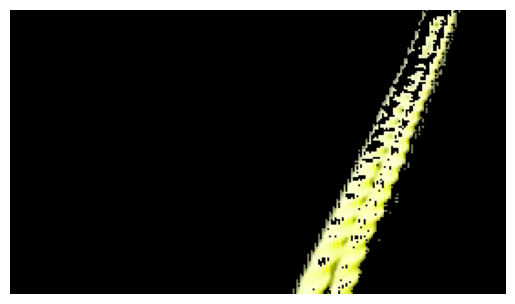

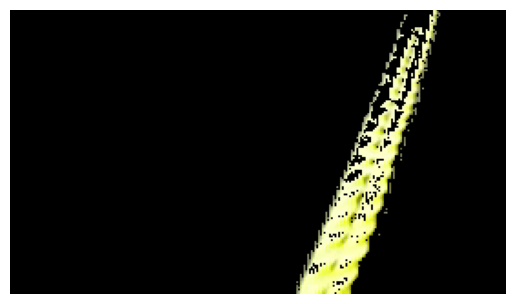

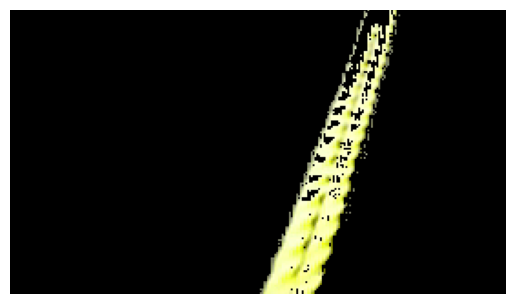

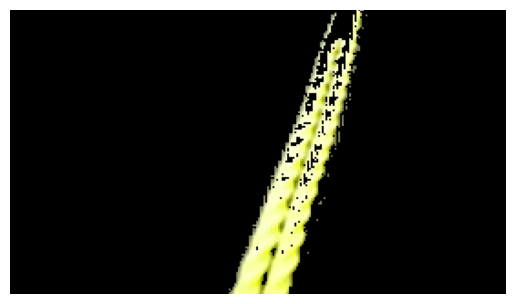

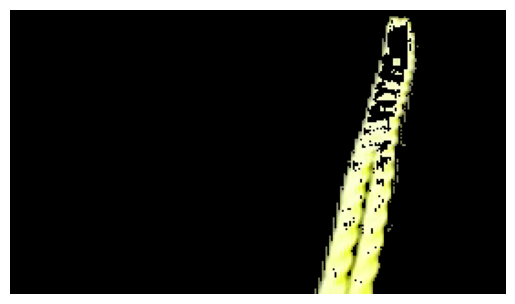

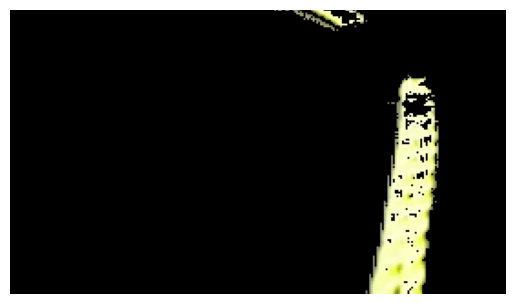

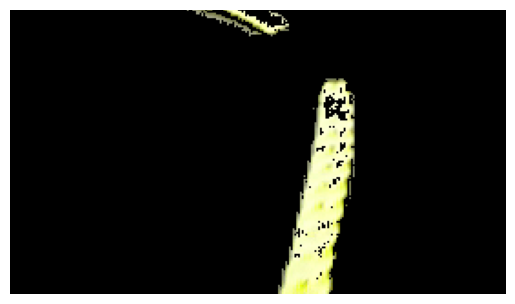

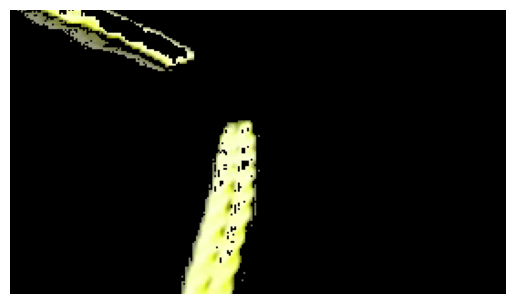

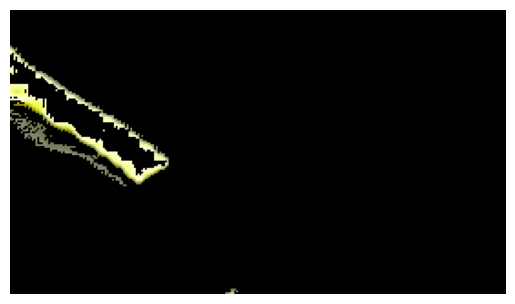

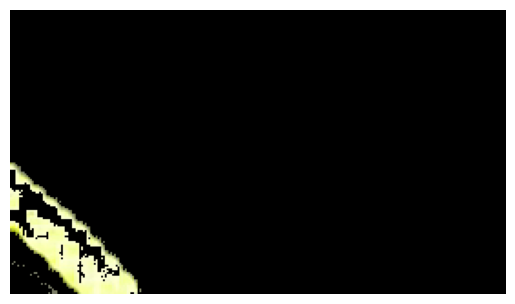

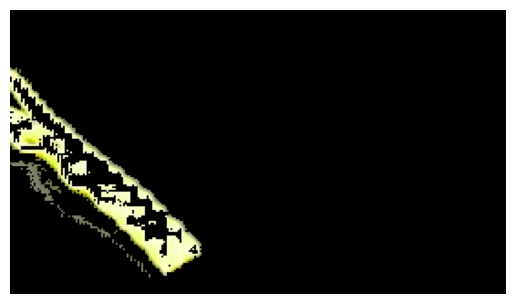

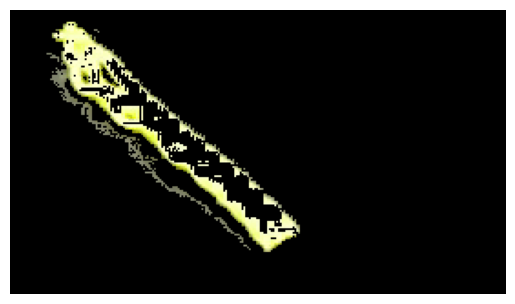

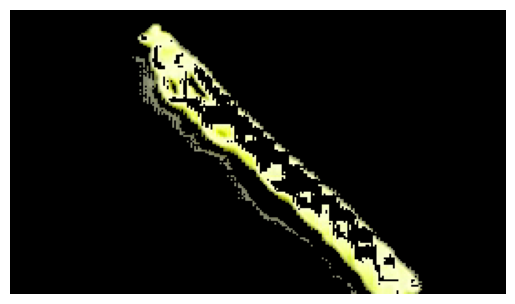

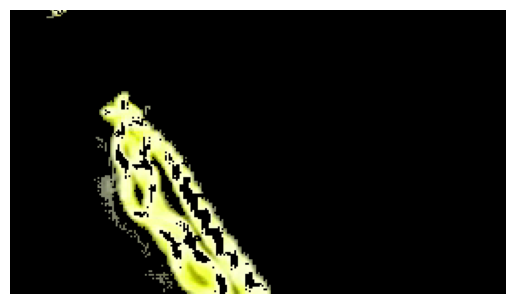

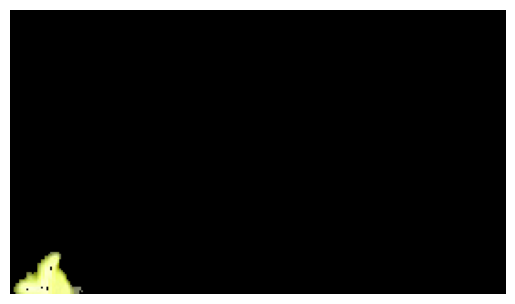

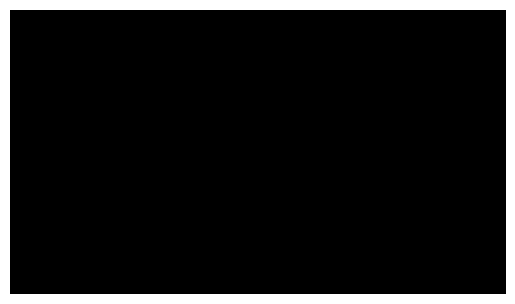

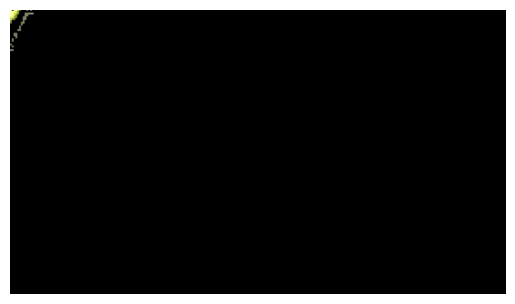

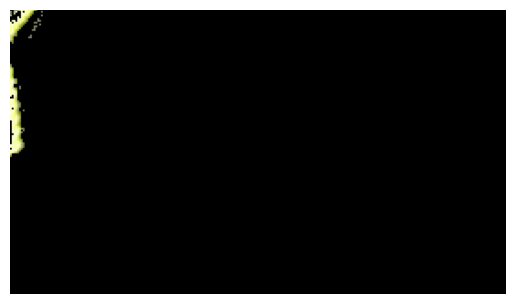

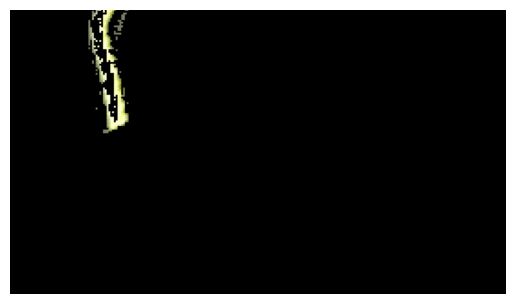

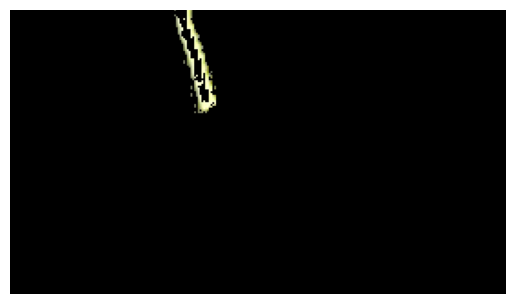

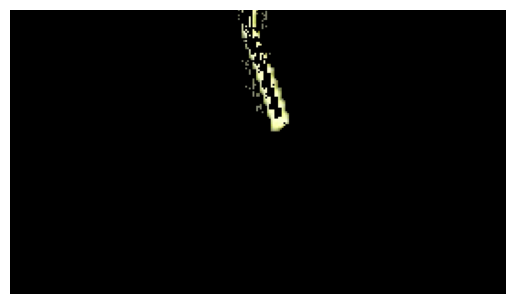

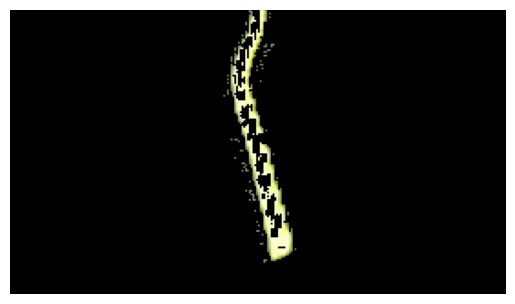

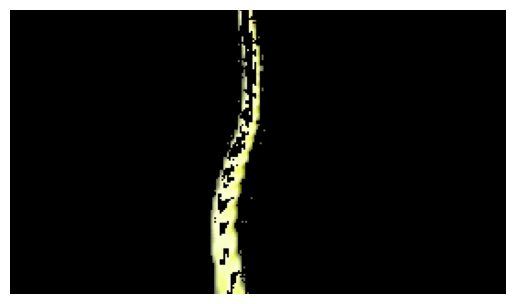

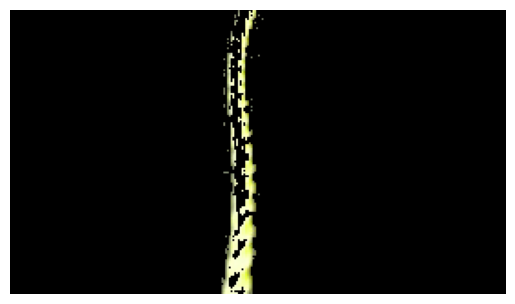

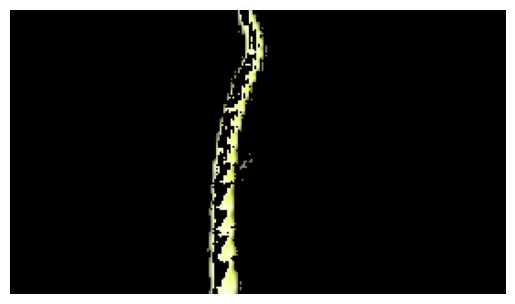

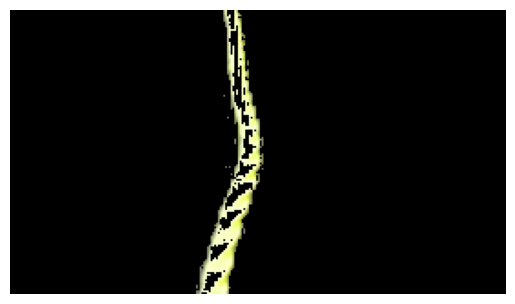

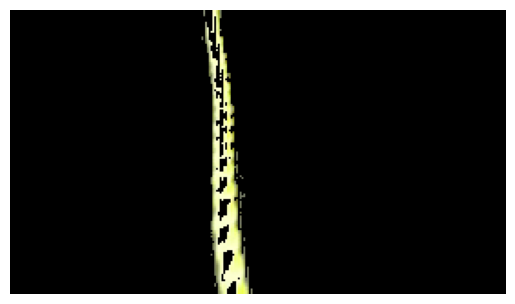

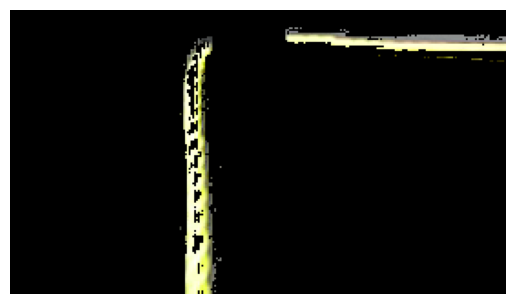

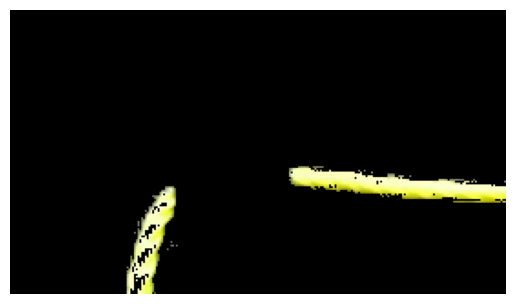

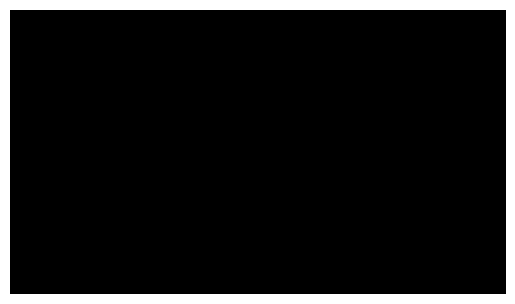

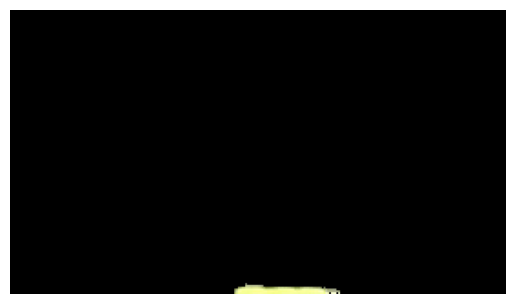

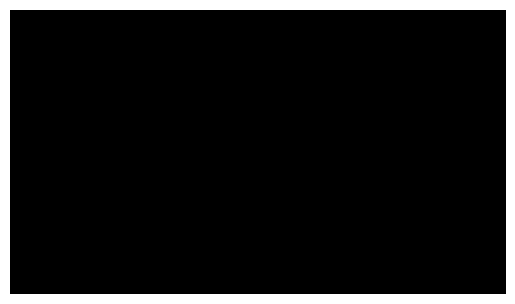

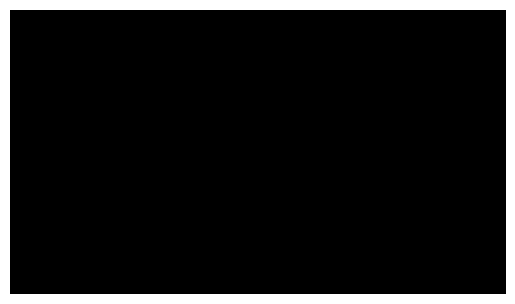

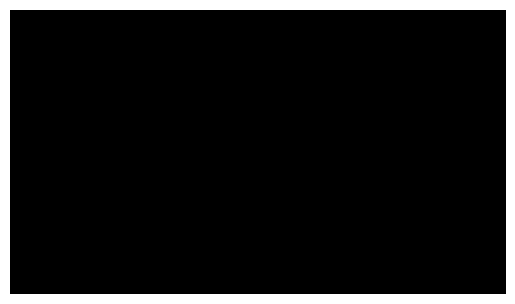

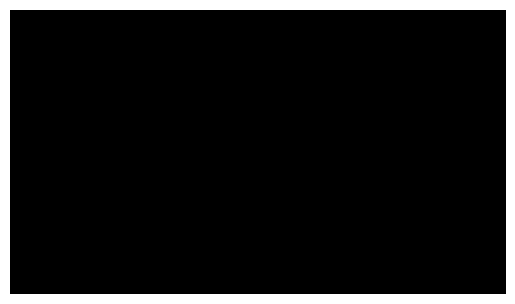

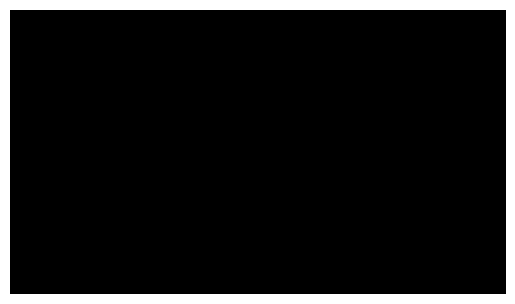

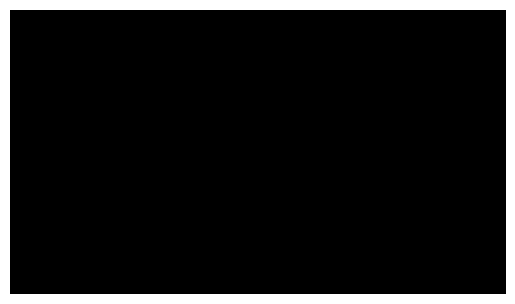

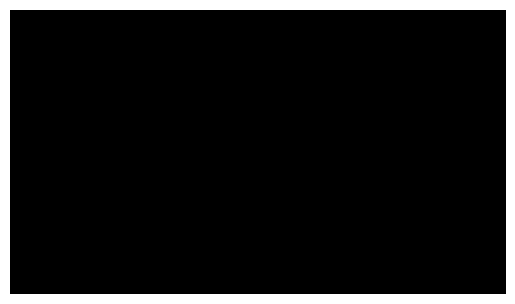

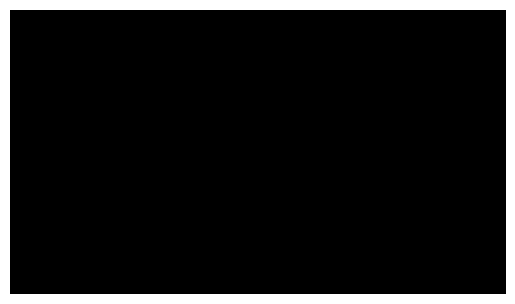

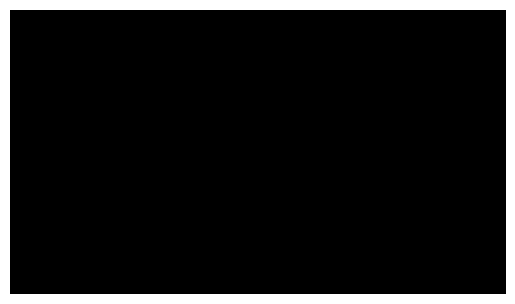

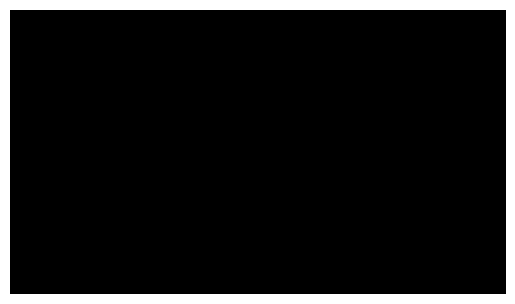

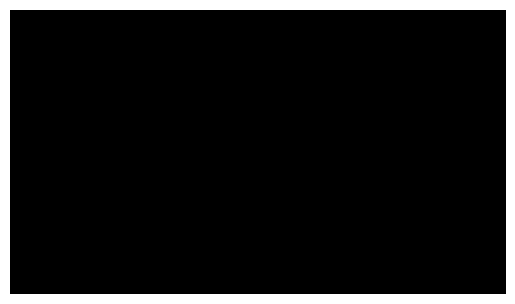

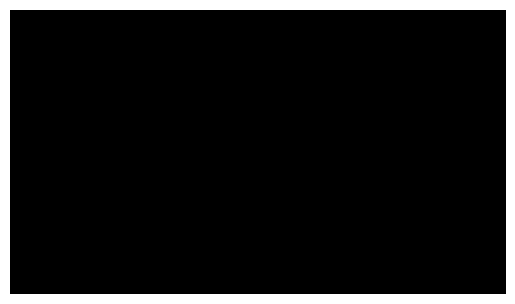

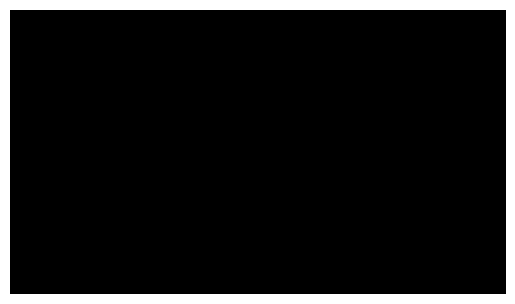

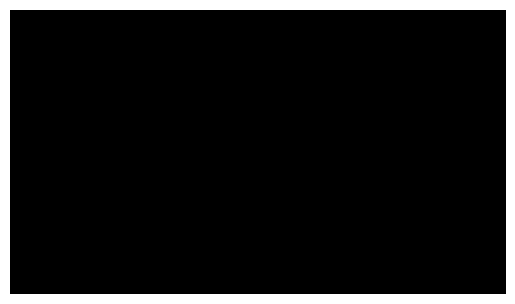

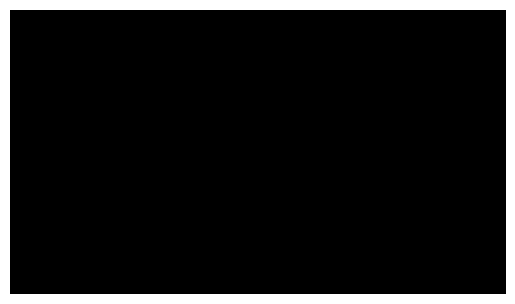

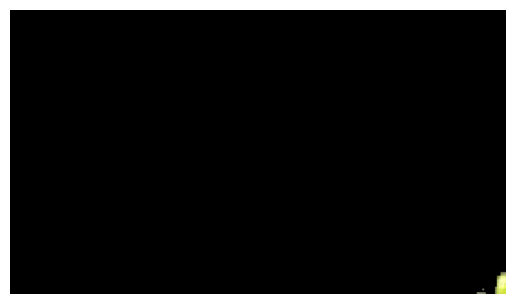

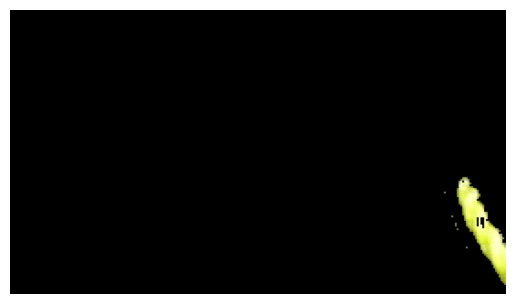

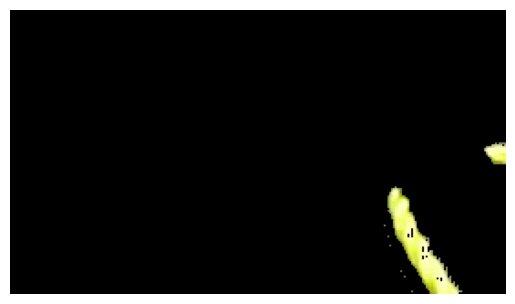

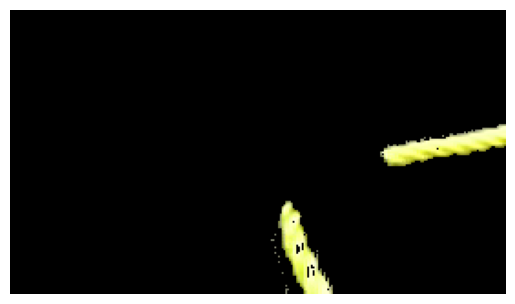

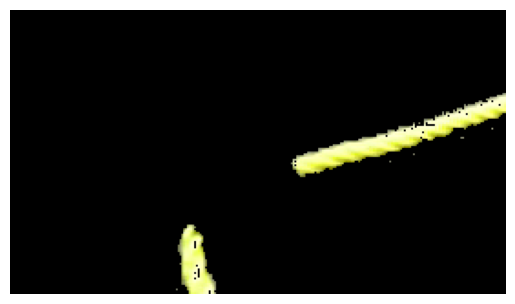

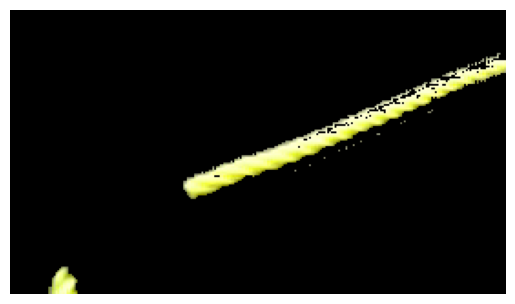

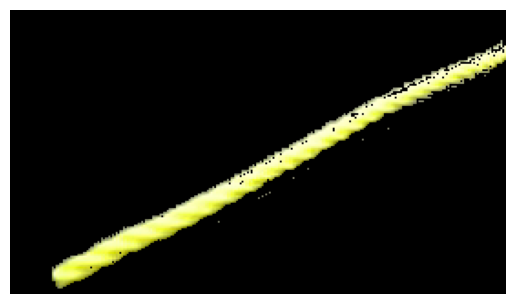

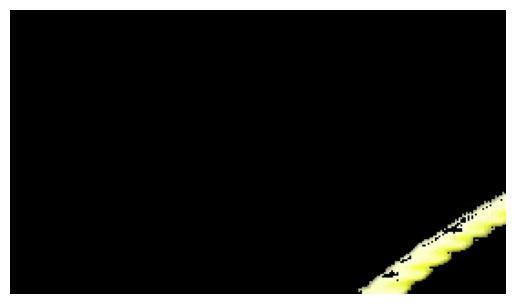

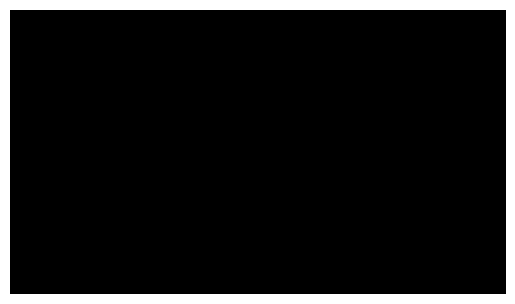

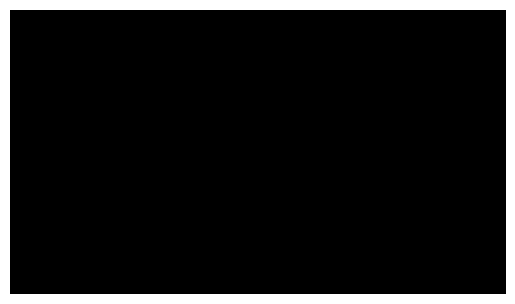

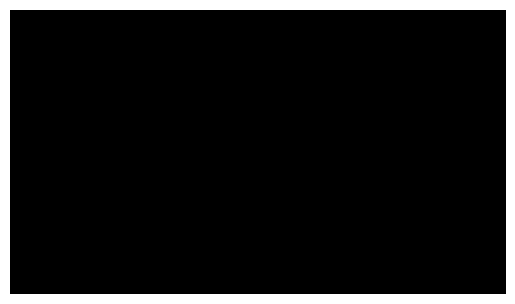

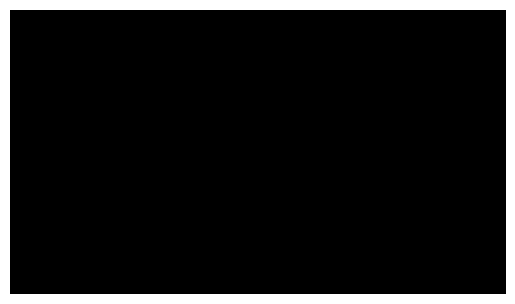

In [ ]:
count = 0
while True:
    img = camera.get_image()
    
    if img is not None:
        h, w = img.shape[:2]
        margin_width = 200
        margin_height = 220
        cropped_image = img[margin_height:,margin_width:w-margin_width]

        h, w = cropped_image.shape[:2]
        centre_x = w // 2
        centre_y = h // 2
        
        margin_width = 100
        margin_height = 100
        
        x1 = max(centre_x - margin_width // 2, 0)
        y1 = max(centre_y - margin_height // 2, 0)
        x2 = min(centre_x + margin_width // 2, cropped_image.shape[1])
        y2 = min(centre_y + margin_height // 2, cropped_image.shape[0])
        #cropped_image = cropped_image[y1:y2,x1:x2]
        
        frame_width = cropped_image.shape[1]
        frame, mask = extract_yellow(cropped_image)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)        

        rope_centre_x, mask = centre_rope(frame, mask)
        
        # Display using matplotlib
        plt.imshow(frame_rgb)
        plt.axis('off')  # Turn off axis
        #plt.text(rope_centre_x, 0, str(rope_centre_x), bbox=dict(fill=False, edgecolor='red', linewidth=2))
        plt.show()
        
        move_robot(rope_centre_x, frame_width, frame_rgb, count)
        count += 1

## Flip left and right images to programmatically expand dataset

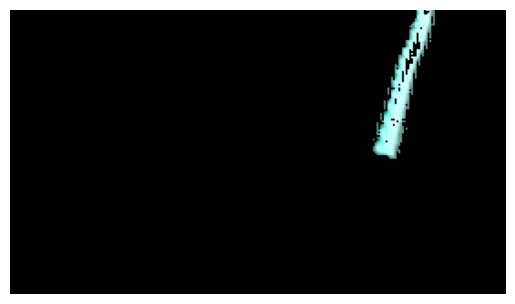

In [12]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("Task 1 Images/left/left_283_2.png")
image = cv2.flip(image, 1) 
frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
# Display using matplotlib
plt.imshow(frame_rgb)
plt.axis('off')  # Turn off axis
#plt.text(rope_centre_x, 0, str(rope_centre_x), bbox=dict(fill=False, edgecolor='red', linewidth=2))
plt.show()

In [5]:
import os
import cv2
count = 0
for filename in os.listdir("Task 1 Images/left"):
    left_filepath = os.path.join("Task 1 Images/left", filename)
    image = cv2.imread(left_filepath)
    image = cv2.flip(image, 1) 

    if image is None:
        continue
        
    #frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    ## Display using matplotlib
    #plt.imshow(frame_rgb)
    #plt.axis('off')  # Turn off axis
    #plt.text(rope_centre_x, 0, str(rope_centre_x), bbox=dict(fill=False, edgecolor='red', linewidth=2))
    #plt.show()
    
    file_without_extension = filename[:-4]
    filepath = os.path.join("Task 1 Images/right", f"right_{count}_flipped.png")
    print(filepath)
    cv2.imwrite(filepath+'_flipped.png', image)
    count += 1

Task 1 Images/right/right_0_flipped.png
Task 1 Images/right/right_1_flipped.png
Task 1 Images/right/right_2_flipped.png
Task 1 Images/right/right_3_flipped.png
Task 1 Images/right/right_4_flipped.png
Task 1 Images/right/right_5_flipped.png
Task 1 Images/right/right_6_flipped.png
Task 1 Images/right/right_7_flipped.png
Task 1 Images/right/right_8_flipped.png
Task 1 Images/right/right_9_flipped.png
Task 1 Images/right/right_10_flipped.png
Task 1 Images/right/right_11_flipped.png
Task 1 Images/right/right_12_flipped.png
Task 1 Images/right/right_13_flipped.png
Task 1 Images/right/right_14_flipped.png
Task 1 Images/right/right_15_flipped.png
Task 1 Images/right/right_16_flipped.png
Task 1 Images/right/right_17_flipped.png
Task 1 Images/right/right_18_flipped.png
Task 1 Images/right/right_19_flipped.png
Task 1 Images/right/right_20_flipped.png
Task 1 Images/right/right_21_flipped.png
Task 1 Images/right/right_22_flipped.png
Task 1 Images/right/right_23_flipped.png
Task 1 Images/right/right_

In [6]:
count = 0
for filename in os.listdir("Task 1 Images/right"):
    left_filepath = os.path.join("Task 1 Images/right", filename)
    image = cv2.imread(left_filepath)
    image = cv2.flip(image, 1) 

    if image is None:
        continue
        
    #frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
    ## Display using matplotlib
    #plt.imshow(frame_rgb)
    #plt.axis('off')  # Turn off axis
    #plt.text(rope_centre_x, 0, str(rope_centre_x), bbox=dict(fill=False, edgecolor='red', linewidth=2))
    #plt.show()
    
    file_without_extension = filename[:-4]
    filepath = os.path.join("Task 1 Images/left", f"left_{count}_flipped.png")
    print(filepath)
    cv2.imwrite(filepath+'_flipped.png', image)
    count += 1

Task 1 Images/left/left_0_flipped.png
Task 1 Images/left/left_1_flipped.png
Task 1 Images/left/left_2_flipped.png
Task 1 Images/left/left_3_flipped.png
Task 1 Images/left/left_4_flipped.png
Task 1 Images/left/left_5_flipped.png
Task 1 Images/left/left_6_flipped.png
Task 1 Images/left/left_7_flipped.png
Task 1 Images/left/left_8_flipped.png
Task 1 Images/left/left_9_flipped.png
Task 1 Images/left/left_10_flipped.png
Task 1 Images/left/left_11_flipped.png
Task 1 Images/left/left_12_flipped.png
Task 1 Images/left/left_13_flipped.png
Task 1 Images/left/left_14_flipped.png
Task 1 Images/left/left_15_flipped.png
Task 1 Images/left/left_16_flipped.png
Task 1 Images/left/left_17_flipped.png
Task 1 Images/left/left_18_flipped.png
Task 1 Images/left/left_19_flipped.png
Task 1 Images/left/left_20_flipped.png
Task 1 Images/left/left_21_flipped.png
Task 1 Images/left/left_22_flipped.png
Task 1 Images/left/left_23_flipped.png
Task 1 Images/left/left_24_flipped.png
Task 1 Images/left/left_25_flipped.

In [8]:
import os

for filename in os.listdir("Task 1 Images/left"):
    file_without_extension = filepath[:-4]
    print(file_without_extension)
    filepath = os.path.join("Task 1 Images/left", filename)
    os.rename(filepath, file_without_extension+'_2.png')

In [7]:
import shutil
from IPython.display import FileLink

# Path to the folder you want to zip
folder_path = 'Task 1 Images'
output_zip = 'images_cropped.zip'  # Desired name for the zip file

# Create a zip archive of the folder
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_path)

# Provide a download link
FileLink(output_zip)

/home/robotics/Documents/notebooks/images_cropped.zip